In [ ]:
import sys
import os
import pprint as pp
import numpy as np

os.chdir("/Users/valentingoupille/Documents/Rapport_stage/")

In [ ]:
import anndata as ad
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData

In [ ]:
path_to_anndata = "data/anndata_objects_with_gene_metadata/"

In [ ]:
os.listdir(path_to_anndata)

['final_adata_filtered.h5ad', 'GeneFull_raw_unique_mult.h5ad']

In [ ]:
adata_original = ad.read_h5ad(path_to_anndata + "GeneFull_raw_unique_mult.h5ad")

In [ ]:
adata = adata_original.copy()

In [ ]:
print("Loading annotation file...")
annotation_df = pd.read_csv("data/extracted_features_no_duplicates.tsv", sep="\t")
print(
    f"Annotation file loaded with {len(annotation_df)} rows and columns: {annotation_df.columns.tolist()}"
)

# Check if final_gene_name column exists in annotation
if "final_gene_name" in annotation_df.columns:
    print("'final_gene_name' column found in annotation file")

    # Create a mapping from final_gene_name to seq_type
    gene_to_seqtype = dict(
        zip(annotation_df["final_gene_name"], annotation_df["seq_type"])
    )

    # Check how many genes in adata.var_names are in the annotation
    genes_in_annotation = [gene for gene in adata.var_names if gene in gene_to_seqtype]
    print(
        f"Number of genes in adata that are in annotation: {len(genes_in_annotation)} out of {len(adata.var_names)}"
    )

    # Update the Chromosome column in adata.var
    if "Chromosome" in adata.var.columns:
        print("Updating existing Chromosome column...")
        # Create a new chromosome mapping
        new_chromosome_values = []
        for gene in adata.var_names:
            if gene in gene_to_seqtype:
                new_chromosome_values.append(gene_to_seqtype[gene])
            else:
                new_chromosome_values.append("unknown")

        adata.var["Chromosome"] = new_chromosome_values
        print("Chromosome column updated successfully!")

        # Show unique values in the updated Chromosome column
        unique_chromosomes = adata.var["Chromosome"].unique()
        print(f"Unique values in updated Chromosome column: {unique_chromosomes}")

        # Count genes per chromosome
        chromosome_counts = adata.var["Chromosome"].value_counts()
        print("Number of genes per chromosome:")
        for chrom, count in chromosome_counts.items():
            print(f"  {chrom}: {count} genes")
    else:
        print("Chromosome column not found in adata.var, creating new column...")
        # Create new chromosome mapping
        new_chromosome_values = []
        for gene in adata.var_names:
            if gene in gene_to_seqtype:
                new_chromosome_values.append(gene_to_seqtype[gene])
            else:
                new_chromosome_values.append("unknown")

        adata.var["Chromosome"] = new_chromosome_values
        print("New Chromosome column created successfully!")

        # Show unique values in the new Chromosome column
        unique_chromosomes = adata.var["Chromosome"].unique()
        print(f"Unique values in new Chromosome column: {unique_chromosomes}")

        # Count genes per chromosome
        chromosome_counts = adata.var["Chromosome"].value_counts()
        print("Number of genes per chromosome:")
        for chrom, count in chromosome_counts.items():
            print(f"  {chrom}: {count} genes")
else:
    print("'final_gene_name' column not found in annotation file!")
    print("Available columns in annotation file:")
    pp.pprint(annotation_df.columns.tolist())


# Create new Group variable by processing OD values
print("🔧 Creating new Group variable from OD column...")


def create_group_from_od(od_value):
    """
    Create Group variable from OD value.
    Extracts the medium and OD parts, removing the middle letter (A, B, C).

    Example: "OD M9_C_OD3" -> "M9_OD3"
    Example: "M9_C_OD3" -> "M9_OD3"
    """
    try:
        # Remove "OD " prefix if present
        if od_value.startswith("OD "):
            od_value = od_value[3:]  # Remove "OD "

        # Split by underscore to get parts
        parts = od_value.split("_")

        if len(parts) >= 3:
            # Get the medium part (first part) and OD part (last part)
            medium_part = parts[0]  # e.g., "M9"
            od_part = parts[-1]  # e.g., "OD3"

            # Combine them, removing the middle letter (A, B, C)
            group = f"{medium_part}_{od_part}"
            return group
        else:
            # If format is different, return original value
            return od_value
    except:
        # If any error occurs, return original value
        return od_value


# Apply the function to create Group variable
adata.obs["Group"] = adata.obs["OD"].apply(create_group_from_od)

# Display the mapping and results
print(f"📋 OD to Group mapping:")
od_to_group = {}
for od_val in adata.obs["OD"].unique():
    group_val = create_group_from_od(od_val)
    od_to_group[od_val] = group_val
    print(f"   {od_val} -> {group_val}")

print(f"\n🧬 New Group column created!")
print(f"🔢 Number of unique Group values: {len(adata.obs['Group'].unique())}")
print(f"📋 Unique Group values: {sorted(adata.obs['Group'].unique())}")

# Show distribution of cells per Group
print(f"\n📊 Distribution of cells per Group:")
group_counts = adata.obs["Group"].value_counts()
for group, count in group_counts.items():
    print(f"   {group}: {count:,} cells")

Loading annotation file...
Annotation file loaded with 6249 rows and columns: ['seq_type', 'feature', 'class', 'product_accession', 'name', 'symbol', 'locus_tag', 'symbol_old', 'locus_tag_old', 'symbol_renamed', 'locus_tag_a', 'final_gene_name']
'final_gene_name' column found in annotation file
Number of genes in adata that are in annotation: 4931 out of 6248
Updating existing Chromosome column...
Chromosome column updated successfully!
Unique values in updated Chromosome column: ['chromosome' 'unknown' 'plasmid']
Number of genes per chromosome:
  chromosome: 4594 genes
  unknown: 1317 genes
  plasmid: 337 genes
🔧 Creating new Group variable from OD column...
📋 OD to Group mapping:
   M9_B_OD1 -> M9_OD1
   M9F_B_OD1 -> M9F_OD1
   M9F_B_OD2 -> M9F_OD2
   M9_A_OD2 -> M9_OD2
   M9F_B_OD3 -> M9F_OD3
   M9_C_OD3 -> M9_OD3
   M9F_C_OD3 -> M9F_OD3
   M9F_C_OD1 -> M9F_OD1
   M9_A_OD1 -> M9_OD1
   M9F_C_OD2 -> M9F_OD2
   M9_C_OD1 -> M9_OD1
   M9F_A_OD2 -> M9F_OD2
   M9_B_OD3 -> M9_OD3
   M9_C_O

In [ ]:
# Calcul de statistiques simples
adata.obs["n_counts"] = adata.X.sum(axis=1).A1  # total counts
adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1  # nombre de gènes détectés

In [ ]:
adata.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,Gene Type,Transcripts accession,Transcript name,Protein accession,Protein name,Protein length,symbol_old,locus_tag_old,symbol_renamed,final_gene_name
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00005,gene-QLH64_00005,QLH64-00005,Gene Expression,CP125961.1,529,2065,chromosome,plus,16S ribosomal RNA,NaN,...,rRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00005,True,QLH64-00005
QLH64-00010,gene-QLH64_00010,QLH64-00010,Gene Expression,CP125961.1,2147,2223,chromosome,plus,tRNA-Ile,NaN,...,tRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00010,True,QLH64-00010
QLH64-00015,gene-QLH64_00015,QLH64-00015,Gene Expression,CP125961.1,2254,2329,chromosome,plus,tRNA-Ala,NaN,...,tRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00015,True,QLH64-00015
QLH64-00020,gene-QLH64_00020,QLH64-00020,Gene Expression,CP125961.1,2575,5466,chromosome,plus,23S ribosomal RNA,NaN,...,rRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00020,True,QLH64-00020
QLH64-00025,gene-QLH64_00025,QLH64-00025,Gene Expression,CP125961.1,5622,5737,unknown,plus,5S ribosomal RNA,rrf_1,...,rRNA,NaN,NaN,NaN,NaN,NaN,rrf,QLH64_00025,True,rrf_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,protein-coding,NaN,NaN,WHS57493.1,hypothetical protein,97.0,NaN,QLH64_31225,True,QLH64-31225
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,protein-coding,NaN,NaN,WHS57647.1,recombinase RecA,351.0,recA,QLH64_31230,True,recA_2
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,protein-coding,NaN,NaN,WHS57494.1,helix-hairpin-helix domain-containing protein,236.0,NaN,QLH64_31235,True,QLH64-31235


In [ ]:
adata.obs

,barcode,Well_loc_rd1,Well_loc_rd2,Well_loc_rd3,CultureMedium,RepBio,OD,RepTech,ODt,OD_theoric,OD_measured,Group,n_counts,n_genes
barcode,,,,,,,,,,,,,,
AAACATCG_AAACATCG_AAACGATA,AAACATCG_AAACATCG_AAACGATA,A2,A2,A2,M9,M9_B,M9_B_OD1,M9_B_OD1_1,OD1,0.1,0.13,M9_OD1,48,44
AACAACCA_AAACATCG_AAACGATA,AACAACCA_AAACATCG_AAACGATA,A2,A2,B1,M9,M9_B,M9_B_OD1,M9_B_OD1_1,OD1,0.1,0.13,M9_OD1,9,9
AACCGAGA_AAACATCG_AAACGATA,AACCGAGA_AAACATCG_AAACGATA,A2,A2,B2,M9,M9_B,M9_B_OD1,M9_B_OD1_1,OD1,0.1,0.13,M9_OD1,37,34
AACGCTTA_AAACATCG_AAACGATA,AACGCTTA_AAACATCG_AAACGATA,A2,A2,B3,M9,M9_B,M9_B_OD1,M9_B_OD1_1,OD1,0.1,0.13,M9_OD1,118,89
AACGTGAT_AAACATCG_AAACGATA,AACGTGAT_AAACATCG_AAACGATA,A2,A2,A1,M9,M9_B,M9_B_OD1,M9_B_OD1_1,OD1,0.1,0.13,M9_OD1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGAAGAGA_TTCACGCA_TTGTCTTA,TGAAGAGA_TTCACGCA_TTGTCTTA,B10,F8,F4,M9,M9_B,M9_B_OD1,M9_B_OD1_5,OD1,0.1,0.13,M9_OD1,21,16
TGGAACAA_TTCACGCA_TTGTCTTA,TGGAACAA_TTCACGCA_TTGTCTTA,B10,F8,F5,M9,M9_B,M9_B_OD1,M9_B_OD1_5,OD1,0.1,0.13,M9_OD1,25,22
TGGCTTCA_TTCACGCA_TTGTCTTA,TGGCTTCA_TTCACGCA_TTGTCTTA,B10,F8,F6,M9,M9_B,M9_B_OD1,M9_B_OD1_5,OD1,0.1,0.13,M9_OD1,10,5


In [ ]:
adata.obs["n_counts"].describe()

count    820800.000000
mean         62.851795
std         137.906700
min           0.000000
25%           6.000000
50%          19.000000
75%          56.000000
max        9449.000000
Name: n_counts, dtype: float64

In [ ]:
adata.obs["n_genes"].describe()

count    820800.000000
mean         38.745412
std          65.655428
min           0.000000
25%           6.000000
50%          16.000000
75%          40.000000
max        1956.000000
Name: n_genes, dtype: float64

In [ ]:
adata.obs.groupby("RepTech")["n_counts"].describe()
adata.obs.groupby("RepTech")["n_counts"].count()

<ipython-input-129-b2bd5b9637a3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("RepTech")["n_counts"].describe()
<ipython-input-129-b2bd5b9637a3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("RepTech")["n_counts"].count()


RepTech
M9F_A_OD1_1    9120
M9F_A_OD1_2    9120
M9F_A_OD1_3    9120
M9F_A_OD1_4    9120
M9F_A_OD1_5    9120
               ... 
M9_C_OD3_1     9120
M9_C_OD3_2     9120
M9_C_OD3_3     9120
M9_C_OD3_4     9120
M9_C_OD3_5     9120
Name: n_counts, Length: 90, dtype: int64

In [ ]:
adata.obs["RepTech_suffix"] = adata.obs["RepTech"].str.split("_").str[-1]

In [ ]:
adata.obs["RepBio_suffix"] = adata.obs["RepBio"].str.split("_").str[-1]

In [ ]:
# # %% filter cells by n_counts
# sc.pp.filter_cells(adata, min_counts=100)


# sc.pl.violin(adata, ["n_counts"], groupby="Group", multi_panel=True)

# Filter cells with n_counts < 100
print(f"📊 Before filtering: {adata.n_obs} cells")

# Create mask for cells to keep (n_counts >= 100)
cells_to_keep = adata.obs["n_counts"] >= 100

# Apply filtering
adata_filtered = adata[cells_to_keep, :].copy()

print(f"📊 After filtering (n_counts >= 100): {adata_filtered.n_obs} cells")
print(f"🗑️ Removed {adata.n_obs - adata_filtered.n_obs} cells")

# Update adata to the filtered version
adata_fcell_100UMI = adata_filtered

# Show summary statistics after filtering
print(f"\n📈 Summary statistics after filtering:")
print(f"   Mean n_counts: {adata_fcell_100UMI.obs['n_counts'].mean():.2f}")
print(f"   Median n_counts: {adata_fcell_100UMI.obs['n_counts'].median():.2f}")
print(f"   Min n_counts: {adata_fcell_100UMI.obs['n_counts'].min():.2f}")
print(f"   Max n_counts: {adata_fcell_100UMI.obs['n_counts'].max():.2f}")

📊 Before filtering: 820800 cells
📊 After filtering (n_counts >= 100): 132233 cells
🗑️ Removed 688567 cells

📈 Summary statistics after filtering:
   Mean n_counts: 276.52
   Median n_counts: 197.00
   Min n_counts: 100.00
   Max n_counts: 9449.00



🍽️ Statistics by Culture Medium:

   M9:
     Cells: 29,641
     Mean n_counts: 248
     Mean n_genes: 146

   M9F:
     Cells: 102,592
     Mean n_counts: 285
     Mean n_genes: 155


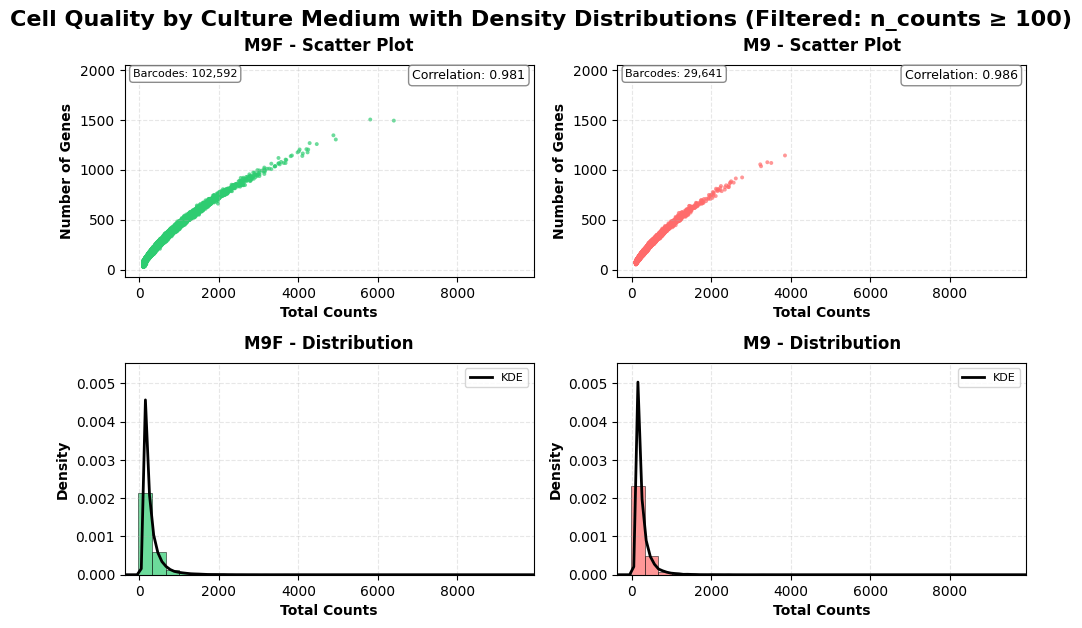


📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):

🍽️ M9F:
   📊 Total cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Min: 100, Max: 9449
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Min: 27, Max: 1956
   🔗 Correlation n_counts vs n_genes: 0.981

🍽️ M9:
   📊 Total cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Min: 100, Max: 3852
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Min: 53, Max: 1144
   🔗 Correlation n_counts vs n_genes: 0.986


In [ ]:
# Get unique culture mediums and create color map
culture_mediums = adata_fcell_100UMI.obs["CultureMedium"].unique()
# Create color map with red for M9 and green for M9F
color_map = {}
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:  # M9
        color_map[medium] = "#FF6B6B"  # Red
    elif "M9F" in medium:  # M9F
        color_map[medium] = "#2ECC71"  # Green
    else:  # Other mediums
        color_map[medium] = "#95A5A6"  # Gray for other

# Print statistics by culture medium
print(f"\n🍽️ Statistics by Culture Medium:")
for medium in culture_mediums:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]
    print(f"\n   {medium}:")
    print(f"     Cells: {len(medium_data):,}")
    print(f"     Mean n_counts: {medium_data['n_counts'].mean():.0f}")
    print(f"     Mean n_genes: {medium_data['n_genes'].mean():.0f}")


# Create separate scatter plots for each culture medium with density plots below
# Reorder culture mediums: M9F first (left), M9 second (right)
culture_mediums_ordered = []
for medium in culture_mediums:
    if "M9F" in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" not in medium:
        culture_mediums_ordered.append(medium)

n_mediums = len(culture_mediums_ordered)
n_cols = min(3, n_mediums)  # Maximum 3 columns
n_rows = 2 * n_mediums  # 2 rows per medium (scatter + density)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Calculate global min/max for consistent scaling
global_x_min = adata_fcell_100UMI.obs["n_counts"].min()
global_x_max = adata_fcell_100UMI.obs["n_counts"].max()
global_y_min = adata_fcell_100UMI.obs["n_genes"].min()
global_y_max = adata_fcell_100UMI.obs["n_genes"].max()

# Add 5% padding to global limits
x_padding = (global_x_max - global_x_min) * 0.05
y_padding = (global_y_max - global_y_min) * 0.05

global_x_lim = (global_x_min - x_padding, global_x_max + x_padding)
global_y_lim = (global_y_min - y_padding, global_y_max + y_padding)

# Calculate global density limits for consistent y-axis scaling in density plots
global_density_max = 0
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    if len(medium_data) > 1:
        # Calculate histogram density
        hist, bins = np.histogram(
            medium_data["n_counts"], bins=30, density=True, range=global_x_lim
        )
        hist_max = hist.max()

        # Calculate KDE density
        from scipy.stats import gaussian_kde

        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(global_x_lim[0], global_x_lim[1], 100)
        kde_density = kde(x_range)
        kde_max = kde_density.max()

        # Take the maximum of both
        medium_max = max(hist_max, kde_max)
        global_density_max = max(global_density_max, medium_max)

# Add 10% padding to density y-axis
global_density_y_lim = (0, global_density_max * 1.1)

for i, medium in enumerate(culture_mediums_ordered):
    # Calculate correct indices for 2-row layout
    col_idx = i % n_cols
    scatter_row = (i // n_cols) * 2
    density_row = (i // n_cols) * 2 + 1

    # Get data for this medium
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    # Create scatter plot (top row)
    scatter_idx = scatter_row * n_cols + col_idx
    ax_scatter = axes_flat[scatter_idx]
    ax_scatter.scatter(
        medium_data["n_counts"],
        medium_data["n_genes"],
        alpha=0.7,
        s=8,  # Reduced point size from 15 to 8
        c=color_map[medium],
        edgecolors="none",
    )

    # Calculate correlation for this medium
    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        # Position correlation text in upper right corner
        ax_scatter.text(
            0.98,
            0.98,
            f"Correlation: {corr:.3f}",
            transform=ax_scatter.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
            ),
        )

    # Add barcode count in upper left corner
    barcode_text = f"Barcodes: {len(medium_data):,}"
    ax_scatter.text(
        0.02,
        0.98,
        barcode_text,
        transform=ax_scatter.transAxes,
        fontsize=8,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

    # Customize scatter subplot
    ax_scatter.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_scatter.set_ylabel("Number of Genes", fontsize=10, fontweight="bold")
    ax_scatter.set_title(
        f"{medium} - Scatter Plot", fontsize=12, fontweight="bold", pad=10
    )
    ax_scatter.grid(True, alpha=0.3, linestyle="--")

    # Set consistent axis limits for all scatter subplots
    ax_scatter.set_xlim(global_x_lim)
    ax_scatter.set_ylim(global_y_lim)

    # Create density plot (bottom row)
    density_idx = density_row * n_cols + col_idx
    ax_density = axes_flat[density_idx]

    # Create density plot for n_counts with global x limits
    ax_density.hist(
        medium_data["n_counts"],
        bins=30,
        alpha=0.7,
        color=color_map[medium],
        edgecolor="black",
        linewidth=0.5,
        density=True,
        range=global_x_lim,  # Use global x limits for consistent scaling
    )

    # Add KDE curve with global x range
    from scipy.stats import gaussian_kde

    if len(medium_data) > 1:
        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(
            global_x_lim[0], global_x_lim[1], 100
        )  # Use global x range
        ax_density.plot(x_range, kde(x_range), color="black", linewidth=2, label="KDE")

    # Customize density subplot
    ax_density.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_density.set_ylabel("Density", fontsize=10, fontweight="bold")
    ax_density.set_title(
        f"{medium} - Distribution", fontsize=12, fontweight="bold", pad=10
    )
    ax_density.grid(True, alpha=0.3, linestyle="--")
    ax_density.legend(fontsize=8)

    # Set consistent x-axis and y-axis limits for all density plots
    ax_density.set_xlim(global_x_lim)
    ax_density.set_ylim(global_density_y_lim)

# Hide empty subplots
for i in range(n_mediums * 2, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.suptitle(
    "Cell Quality by Culture Medium with Density Distributions (Filtered: n_counts ≥ 100)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

# Print detailed statistics for each medium
print(f"\n📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):")
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    print(f"\n🍽️ {medium}:")
    print(f"   📊 Total cells: {len(medium_data):,}")
    print(
        f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
    )
    print(
        f"   📈 n_counts - Min: {medium_data['n_counts'].min():.0f}, Max: {medium_data['n_counts'].max():.0f}"
    )
    print(
        f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
    )
    print(
        f"   🧬 n_genes - Min: {medium_data['n_genes'].min():.0f}, Max: {medium_data['n_genes'].max():.0f}"
    )

    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        print(f"   🔗 Correlation n_counts vs n_genes: {corr:.3f}")


🍽️ Statistics by Culture Medium:

   M9:
     Cells: 29,641
     Mean n_counts: 248
     Mean n_genes: 146

   M9F:
     Cells: 102,592
     Mean n_counts: 285
     Mean n_genes: 155


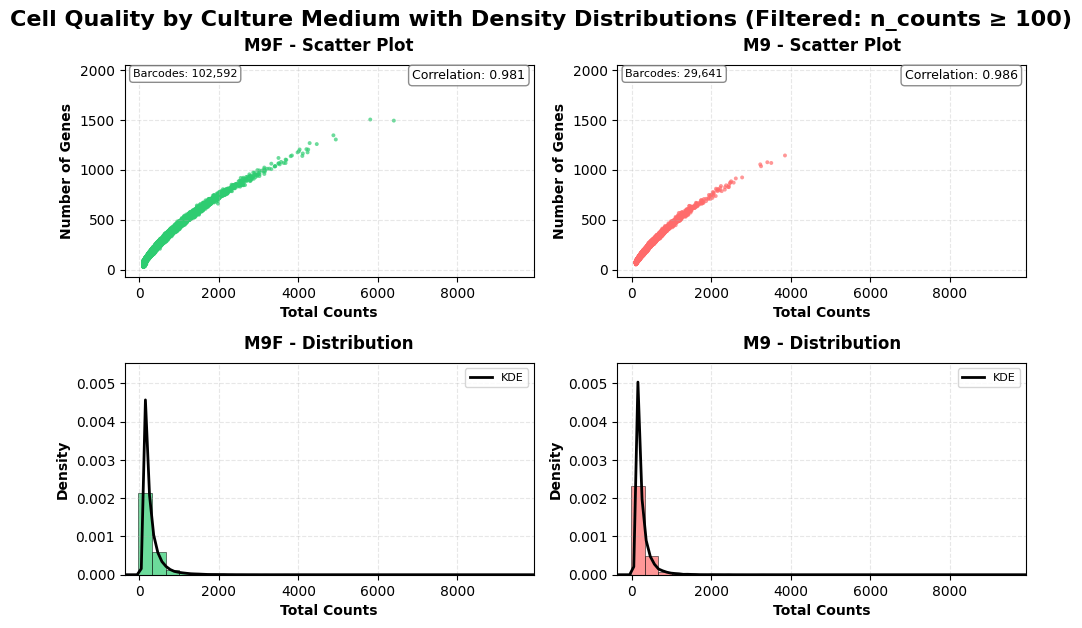


📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):

🍽️ M9F:
   📊 Total cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Min: 100, Max: 9449
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Min: 27, Max: 1956
   🔗 Correlation n_counts vs n_genes: 0.981

🍽️ M9:
   📊 Total cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Min: 100, Max: 3852
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Min: 53, Max: 1144
   🔗 Correlation n_counts vs n_genes: 0.986


In [ ]:
# Get unique culture mediums and create color map
culture_mediums = adata_fcell_100UMI.obs["CultureMedium"].unique()
# Create color map with red for M9 and green for M9F
color_map = {}
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:  # M9
        color_map[medium] = "#FF6B6B"  # Red
    elif "M9F" in medium:  # M9F
        color_map[medium] = "#2ECC71"  # Green
    else:  # Other mediums
        color_map[medium] = "#95A5A6"  # Gray for other

# Print statistics by culture medium
print(f"\n🍽️ Statistics by Culture Medium:")
for medium in culture_mediums:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]
    print(f"\n   {medium}:")
    print(f"     Cells: {len(medium_data):,}")
    print(f"     Mean n_counts: {medium_data['n_counts'].mean():.0f}")
    print(f"     Mean n_genes: {medium_data['n_genes'].mean():.0f}")


# Create separate scatter plots for each culture medium with density plots below
# Reorder culture mediums: M9F first (left), M9 second (right)
culture_mediums_ordered = []
for medium in culture_mediums:
    if "M9F" in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" not in medium:
        culture_mediums_ordered.append(medium)

n_mediums = len(culture_mediums_ordered)
n_cols = min(3, n_mediums)  # Maximum 3 columns
n_rows = 2 * n_mediums  # 2 rows per medium (scatter + density)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Calculate global min/max for consistent scaling
global_x_min = adata_fcell_100UMI.obs["n_counts"].min()
global_x_max = adata_fcell_100UMI.obs["n_counts"].max()
global_y_min = adata_fcell_100UMI.obs["n_genes"].min()
global_y_max = adata_fcell_100UMI.obs["n_genes"].max()

# Add 5% padding to global limits
x_padding = (global_x_max - global_x_min) * 0.05
y_padding = (global_y_max - global_y_min) * 0.05

global_x_lim = (global_x_min - x_padding, global_x_max + x_padding)
global_y_lim = (global_y_min - y_padding, global_y_max + y_padding)

# Calculate global density limits for consistent y-axis scaling in density plots
global_density_max = 0
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    if len(medium_data) > 1:
        # Calculate histogram density
        hist, bins = np.histogram(
            medium_data["n_counts"], bins=30, density=True, range=global_x_lim
        )
        hist_max = hist.max()

        # Calculate KDE density
        from scipy.stats import gaussian_kde

        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(global_x_lim[0], global_x_lim[1], 100)
        kde_density = kde(x_range)
        kde_max = kde_density.max()

        # Take the maximum of both
        medium_max = max(hist_max, kde_max)
        global_density_max = max(global_density_max, medium_max)

# Add 10% padding to density y-axis
global_density_y_lim = (0, global_density_max * 1.1)

for i, medium in enumerate(culture_mediums_ordered):
    # Calculate correct indices for 2-row layout
    col_idx = i % n_cols
    scatter_row = (i // n_cols) * 2
    density_row = (i // n_cols) * 2 + 1

    # Get data for this medium
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    # Create scatter plot (top row)
    scatter_idx = scatter_row * n_cols + col_idx
    ax_scatter = axes_flat[scatter_idx]
    ax_scatter.scatter(
        medium_data["n_counts"],
        medium_data["n_genes"],
        alpha=0.7,
        s=8,  # Reduced point size from 15 to 8
        c=color_map[medium],
        edgecolors="none",
    )

    # Calculate correlation for this medium
    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        # Position correlation text in upper right corner
        ax_scatter.text(
            0.98,
            0.98,
            f"Correlation: {corr:.3f}",
            transform=ax_scatter.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
            ),
        )

    # Add barcode count in upper left corner
    barcode_text = f"Barcodes: {len(medium_data):,}"
    ax_scatter.text(
        0.02,
        0.98,
        barcode_text,
        transform=ax_scatter.transAxes,
        fontsize=8,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

    # Customize scatter subplot
    ax_scatter.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_scatter.set_ylabel("Number of Genes", fontsize=10, fontweight="bold")
    ax_scatter.set_title(
        f"{medium} - Scatter Plot", fontsize=12, fontweight="bold", pad=10
    )
    ax_scatter.grid(True, alpha=0.3, linestyle="--")

    # Set consistent axis limits for all scatter subplots
    ax_scatter.set_xlim(global_x_lim)
    ax_scatter.set_ylim(global_y_lim)

    # Create density plot (bottom row)
    density_idx = density_row * n_cols + col_idx
    ax_density = axes_flat[density_idx]

    # Create density plot for n_counts with global x limits
    ax_density.hist(
        medium_data["n_counts"],
        bins=30,
        alpha=0.7,
        color=color_map[medium],
        edgecolor="black",
        linewidth=0.5,
        density=True,
        range=global_x_lim,  # Use global x limits for consistent scaling
    )

    # Add KDE curve with global x range
    from scipy.stats import gaussian_kde

    if len(medium_data) > 1:
        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(
            global_x_lim[0], global_x_lim[1], 100
        )  # Use global x range
        ax_density.plot(x_range, kde(x_range), color="black", linewidth=2, label="KDE")

    # Customize density subplot
    ax_density.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_density.set_ylabel("Density", fontsize=10, fontweight="bold")
    ax_density.set_title(
        f"{medium} - Distribution", fontsize=12, fontweight="bold", pad=10
    )
    ax_density.grid(True, alpha=0.3, linestyle="--")
    ax_density.legend(fontsize=8)

    # Set consistent x-axis and y-axis limits for all density plots
    ax_density.set_xlim(global_x_lim)
    ax_density.set_ylim(global_density_y_lim)

# Hide empty subplots
for i in range(n_mediums * 2, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.suptitle(
    "Cell Quality by Culture Medium with Density Distributions (Filtered: n_counts ≥ 100)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

# Print detailed statistics for each medium
print(f"\n📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):")
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    print(f"\n🍽️ {medium}:")
    print(f"   📊 Total cells: {len(medium_data):,}")
    print(
        f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
    )
    print(
        f"   📈 n_counts - Min: {medium_data['n_counts'].min():.0f}, Max: {medium_data['n_counts'].max():.0f}"
    )
    print(
        f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
    )
    print(
        f"   🧬 n_genes - Min: {medium_data['n_genes'].min():.0f}, Max: {medium_data['n_genes'].max():.0f}"
    )

    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        print(f"   🔗 Correlation n_counts vs n_genes: {corr:.3f}")

<ipython-input-135-5a0b809b2271>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-135-5a0b809b2271>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


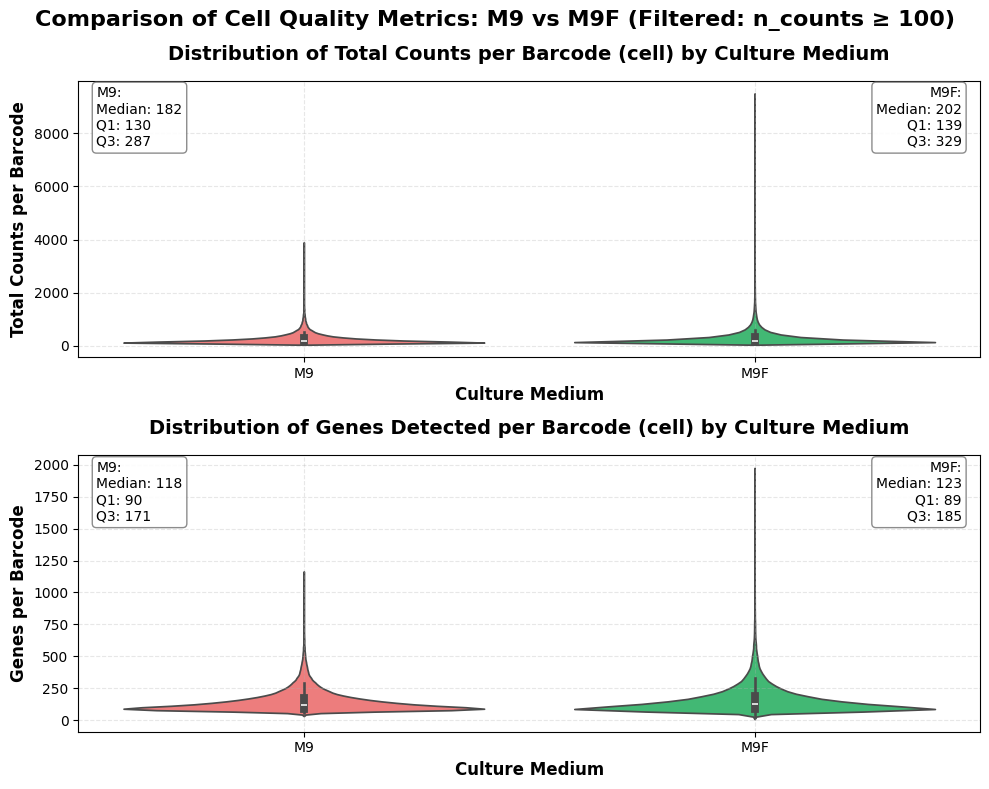


🎻 Violin Plot Comparison: M9 vs M9F
📊 Total cells in comparison: 132,233

🍽️ M9:
   📊 Cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Std: 203
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Std: 86

🍽️ M9F:
   📊 Cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Std: 257
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Std: 102


In [ ]:
# Create violin plots comparing M9 and M9F
# Filter data for M9 and M9F only
m9_m9f_mask = adata_fcell_100UMI.obs["CultureMedium"].isin(["M9", "M9F"])
adata_m9_m9f = adata_fcell_100UMI[m9_m9f_mask].copy()

if len(adata_m9_m9f) > 0:
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Violin plot for n_counts (top)
    sns.violinplot(
        data=adata_m9_m9f.obs,
        x="CultureMedium",
        y="n_counts",
        ax=ax1,
        palette=["#FF6B6B", "#2ECC71"],
    )
    ax1.set_title(
        "Distribution of Total Counts per Barcode (cell) by Culture Medium",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax1.set_xlabel("Culture Medium", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Total Counts per Barcode", fontsize=12, fontweight="bold")
    ax1.grid(True, alpha=0.3, linestyle="--")

    # Add statistics on the plot
    for i, medium in enumerate(["M9", "M9F"]):
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            median_val = medium_data["n_counts"].median()
            q1_val = medium_data["n_counts"].quantile(0.25)
            q3_val = medium_data["n_counts"].quantile(0.75)

            # Position M9 on the left, M9F on the right
            if medium == "M9":
                ax1.text(
                    0.02,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax1.transAxes,
                    fontsize=10,
                    ha="left",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )
            else:  # M9F
                ax1.text(
                    0.98,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax1.transAxes,
                    fontsize=10,
                    ha="right",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )

    # Violin plot for n_genes (bottom)
    sns.violinplot(
        data=adata_m9_m9f.obs,
        x="CultureMedium",
        y="n_genes",
        ax=ax2,
        palette=["#FF6B6B", "#2ECC71"],
    )
    ax2.set_title(
        "Distribution of Genes Detected per Barcode (cell) by Culture Medium",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax2.set_xlabel("Culture Medium", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Genes per Barcode", fontsize=12, fontweight="bold")
    ax2.grid(True, alpha=0.3, linestyle="--")

    # Add statistics on the plot
    for i, medium in enumerate(["M9", "M9F"]):
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            median_val = medium_data["n_genes"].median()
            q1_val = medium_data["n_genes"].quantile(0.25)
            q3_val = medium_data["n_genes"].quantile(0.75)

            # Position M9 on the left, M9F on the right
            if medium == "M9":
                ax2.text(
                    0.02,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax2.transAxes,
                    fontsize=10,
                    ha="left",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )
            else:  # M9F
                ax2.text(
                    0.98,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax2.transAxes,
                    fontsize=10,
                    ha="right",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )

    plt.suptitle(
        "Comparison of Cell Quality Metrics: M9 vs M9F (Filtered: n_counts ≥ 100)",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\n🎻 Violin Plot Comparison: M9 vs M9F")
    print(f"📊 Total cells in comparison: {len(adata_m9_m9f):,}")

    for medium in ["M9", "M9F"]:
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            print(f"\n🍽️ {medium}:")
            print(f"   📊 Cells: {len(medium_data):,}")
            print(
                f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
            )
            print(f"   📈 n_counts - Std: {medium_data['n_counts'].std():.0f}")
            print(
                f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
            )
            print(f"   🧬 n_genes - Std: {medium_data['n_genes'].std():.0f}")
else:
    print("⚠️ No M9 or M9F data found for violin plot comparison")

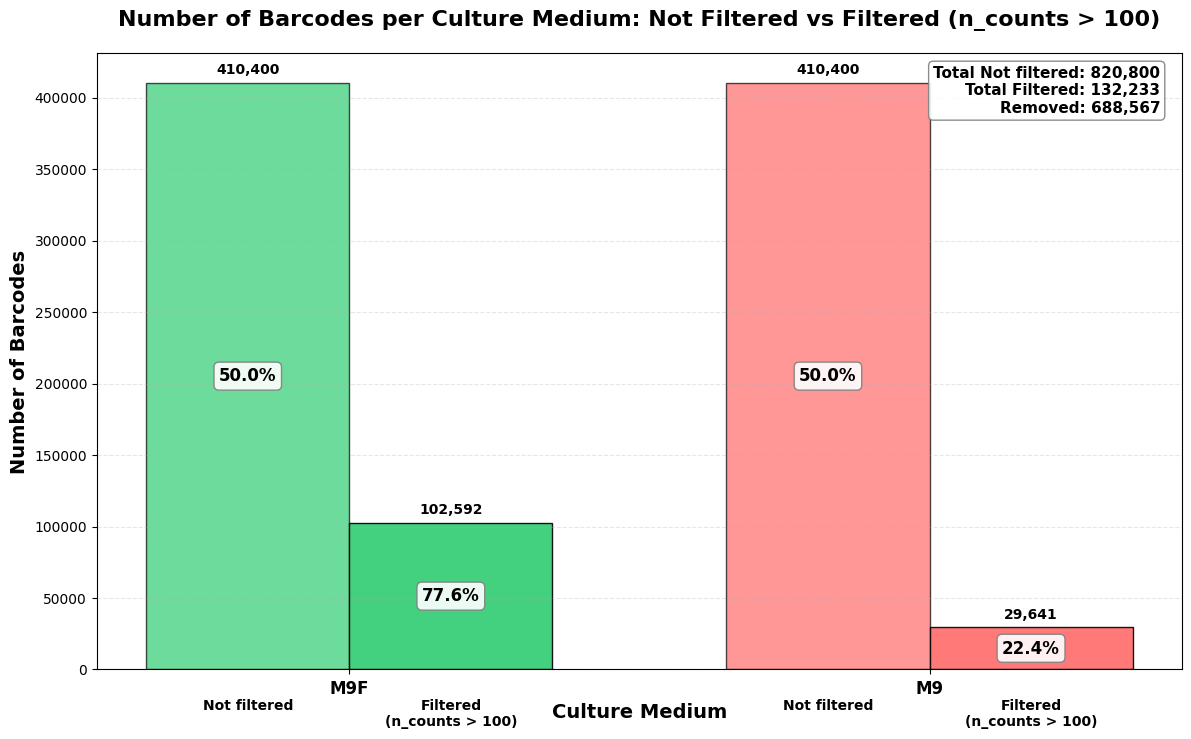


📊 Cell Count Summary: Before vs After Filtering (n_counts ≥ 100):
📈 Total barcodes before filtering: 820,800
📈 Total barcodes after filtering: 132,233
🗑️ Barcodes removed: 688,567 (83.9%)

🍽️ Breakdown by Culture Medium:

   M9F:
     Before: 410,400 barcodes
     After: 102,592 barcodes
     Removed: 307,808 barcodes (75.0%)

   M9:
     Before: 410,400 barcodes
     After: 29,641 barcodes
     Removed: 380,759 barcodes (92.8%)


In [ ]:
# Create beautiful plot of number of cells per culture medium
plt.figure(figsize=(14, 8))

# Count cells per culture medium BEFORE filtering
cell_counts_before = adata_original.obs["CultureMedium"].value_counts()

# Count cells per culture medium AFTER filtering
cell_counts_after = adata_fcell_100UMI.obs["CultureMedium"].value_counts()

# Reorder culture mediums: M9F first (left), M9 second (right)
culture_mediums_ordered = []
for medium in cell_counts_before.index:
    if "M9F" in medium:
        culture_mediums_ordered.append(medium)
for medium in cell_counts_before.index:
    if "M9" in medium and "F" not in medium:
        culture_mediums_ordered.append(medium)
for medium in cell_counts_before.index:
    if "M9" not in medium:
        culture_mediums_ordered.append(medium)

# Reorder the data according to the new order
cell_counts_before_ordered = cell_counts_before.reindex(culture_mediums_ordered)
cell_counts_after_ordered = cell_counts_after.reindex(culture_mediums_ordered)

# Create color palette
colors = []
for medium in culture_mediums_ordered:
    if "M9" in medium and "F" not in medium:  # M9
        colors.append("#FF6B6B")  # Red
    elif "M9F" in medium:  # M9F
        colors.append("#2ECC71")  # Green
    else:  # Other mediums
        colors.append("#95A5A6")  # Gray for other

# Set up the bar positions
x = np.arange(len(culture_mediums_ordered))
width = 0.35

# Create bar plot
bars_before = plt.bar(
    x - width / 2,
    cell_counts_before_ordered.values,
    width,
    color=colors,
    alpha=0.7,
    edgecolor="black",
    linewidth=1,
)
bars_after = plt.bar(
    x + width / 2,
    cell_counts_after_ordered.values,
    width,
    color=colors,
    alpha=0.9,
    edgecolor="black",
    linewidth=1,
)

# Customize the plot
plt.title(
    "Number of Barcodes per Culture Medium: Not Filtered vs Filtered (n_counts > 100)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Culture Medium", fontsize=14, fontweight="bold")
plt.ylabel("Number of Barcodes", fontsize=14, fontweight="bold")

# Set x-axis labels
plt.xticks(
    x, culture_mediums_ordered, rotation=0, ha="center", fontsize=12, fontweight="bold"
)

# Add "Before" and "After" labels under each bar group
for i, medium in enumerate(culture_mediums_ordered):
    plt.text(
        x[i] - width / 2,
        -max(cell_counts_before_ordered.values) * 0.05,
        "Not filtered",
        ha="center",
        va="top",
        fontsize=10,
        fontweight="bold",
    )
    plt.text(
        x[i] + width / 2,
        -max(cell_counts_before_ordered.values) * 0.05,
        "Filtered\n(n_counts > 100)",
        ha="center",
        va="top",
        fontsize=10,
        fontweight="bold",
    )

# Add value labels on top of each bar
for bar, count in zip(bars_before, cell_counts_before_ordered.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(cell_counts_before_ordered.values) * 0.01,
        f"{count:,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

for bar, count in zip(bars_after, cell_counts_after_ordered.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(cell_counts_before_ordered.values) * 0.01,
        f"{count:,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# Add percentage labels inside bars
total_before = cell_counts_before_ordered.sum()
total_after = cell_counts_after_ordered.sum()

for bar, count in zip(bars_before, cell_counts_before_ordered.values):
    percentage = (count / total_before) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{percentage:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

for bar, count in zip(bars_after, cell_counts_after_ordered.values):
    percentage = (count / total_after) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{percentage:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle="--", axis="y")

# Add total counts in the upper right corner
total_text = f"Total Not filtered: {total_before:,}\nTotal Filtered: {total_after:,}\nRemoved: {total_before - total_after:,}"
plt.text(
    0.98,
    0.98,
    total_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    fontweight="bold",
    ha="right",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"),
)

# Show the plot
plt.show()

# Print detailed statistics
print(f"\n📊 Cell Count Summary: Before vs After Filtering (n_counts ≥ 100):")
print(f"📈 Total barcodes before filtering: {total_before:,}")
print(f"📈 Total barcodes after filtering: {total_after:,}")
print(
    f"🗑️ Barcodes removed: {total_before - total_after:,} ({(total_before - total_after)/total_before*100:.1f}%)"
)

print(f"\n🍽️ Breakdown by Culture Medium:")
for medium in culture_mediums_ordered:
    before_count = cell_counts_before_ordered[medium]
    after_count = cell_counts_after_ordered.get(medium, 0)
    removed_count = before_count - after_count
    removed_percentage = (removed_count / before_count) * 100 if before_count > 0 else 0

    print(f"\n   {medium}:")
    print(f"     Before: {before_count:,} barcodes")
    print(f"     After: {after_count:,} barcodes")
    print(f"     Removed: {removed_count:,} barcodes ({removed_percentage:.1f}%)")

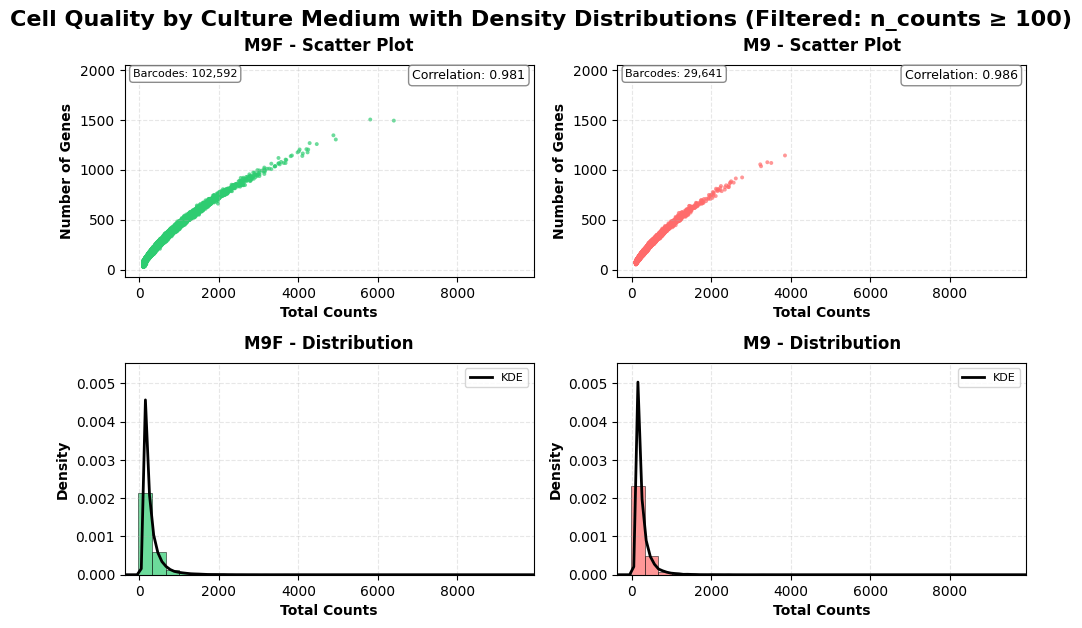


📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):

🍽️ M9F:
   📊 Total cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Min: 100, Max: 9449
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Min: 27, Max: 1956
   🔗 Correlation n_counts vs n_genes: 0.981

🍽️ M9:
   📊 Total cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Min: 100, Max: 3852
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Min: 53, Max: 1144
   🔗 Correlation n_counts vs n_genes: 0.986


In [ ]:
# Create separate scatter plots for each culture medium with density plots below
# Reorder culture mediums: M9F first (left), M9 second (right)
culture_mediums_ordered = []
for medium in culture_mediums:
    if "M9F" in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" not in medium:
        culture_mediums_ordered.append(medium)

n_mediums = len(culture_mediums_ordered)
n_cols = min(3, n_mediums)  # Maximum 3 columns
n_rows = 2 * n_mediums  # 2 rows per medium (scatter + density)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Calculate global min/max for consistent scaling
global_x_min = adata_fcell_100UMI.obs["n_counts"].min()
global_x_max = adata_fcell_100UMI.obs["n_counts"].max()
global_y_min = adata_fcell_100UMI.obs["n_genes"].min()
global_y_max = adata_fcell_100UMI.obs["n_genes"].max()

# Add 5% padding to global limits
x_padding = (global_x_max - global_x_min) * 0.05
y_padding = (global_y_max - global_y_min) * 0.05

global_x_lim = (global_x_min - x_padding, global_x_max + x_padding)
global_y_lim = (global_y_min - y_padding, global_y_max + y_padding)

# Calculate global density limits for consistent y-axis scaling in density plots
global_density_max = 0
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    if len(medium_data) > 1:
        # Calculate histogram density
        hist, bins = np.histogram(
            medium_data["n_counts"], bins=30, density=True, range=global_x_lim
        )
        hist_max = hist.max()

        # Calculate KDE density
        from scipy.stats import gaussian_kde

        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(global_x_lim[0], global_x_lim[1], 100)
        kde_density = kde(x_range)
        kde_max = kde_density.max()

        # Take the maximum of both
        medium_max = max(hist_max, kde_max)
        global_density_max = max(global_density_max, medium_max)

# Add 10% padding to density y-axis
global_density_y_lim = (0, global_density_max * 1.1)

for i, medium in enumerate(culture_mediums_ordered):
    # Calculate correct indices for 2-row layout
    col_idx = i % n_cols
    scatter_row = (i // n_cols) * 2
    density_row = (i // n_cols) * 2 + 1

    # Get data for this medium
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    # Create scatter plot (top row)
    scatter_idx = scatter_row * n_cols + col_idx
    ax_scatter = axes_flat[scatter_idx]
    ax_scatter.scatter(
        medium_data["n_counts"],
        medium_data["n_genes"],
        alpha=0.7,
        s=8,  # Reduced point size from 15 to 8
        c=color_map[medium],
        edgecolors="none",
    )

    # Calculate correlation for this medium
    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        # Position correlation text in upper right corner
        ax_scatter.text(
            0.98,
            0.98,
            f"Correlation: {corr:.3f}",
            transform=ax_scatter.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
            ),
        )

    # Add barcode count in upper left corner
    barcode_text = f"Barcodes: {len(medium_data):,}"
    ax_scatter.text(
        0.02,
        0.98,
        barcode_text,
        transform=ax_scatter.transAxes,
        fontsize=8,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

    # Customize scatter subplot
    ax_scatter.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_scatter.set_ylabel("Number of Genes", fontsize=10, fontweight="bold")
    ax_scatter.set_title(
        f"{medium} - Scatter Plot", fontsize=12, fontweight="bold", pad=10
    )
    ax_scatter.grid(True, alpha=0.3, linestyle="--")

    # Set consistent axis limits for all scatter subplots
    ax_scatter.set_xlim(global_x_lim)
    ax_scatter.set_ylim(global_y_lim)

    # Create density plot (bottom row)
    density_idx = density_row * n_cols + col_idx
    ax_density = axes_flat[density_idx]

    # Create density plot for n_counts with global x limits
    ax_density.hist(
        medium_data["n_counts"],
        bins=30,
        alpha=0.7,
        color=color_map[medium],
        edgecolor="black",
        linewidth=0.5,
        density=True,
        range=global_x_lim,  # Use global x limits for consistent scaling
    )

    # Add KDE curve with global x range
    from scipy.stats import gaussian_kde

    if len(medium_data) > 1:
        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(
            global_x_lim[0], global_x_lim[1], 100
        )  # Use global x range
        ax_density.plot(x_range, kde(x_range), color="black", linewidth=2, label="KDE")

    # Customize density subplot
    ax_density.set_xlabel("Total Counts", fontsize=10, fontweight="bold")
    ax_density.set_ylabel("Density", fontsize=10, fontweight="bold")
    ax_density.set_title(
        f"{medium} - Distribution", fontsize=12, fontweight="bold", pad=10
    )
    ax_density.grid(True, alpha=0.3, linestyle="--")
    ax_density.legend(fontsize=8)

    # Set consistent x-axis and y-axis limits for all density plots
    ax_density.set_xlim(global_x_lim)
    ax_density.set_ylim(global_density_y_lim)

# Hide empty subplots
for i in range(n_mediums * 2, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.suptitle(
    "Cell Quality by Culture Medium with Density Distributions (Filtered: n_counts ≥ 100)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

# Print detailed statistics for each medium
print(f"\n📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):")
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    print(f"\n🍽️ {medium}:")
    print(f"   📊 Total cells: {len(medium_data):,}")
    print(
        f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
    )
    print(
        f"   📈 n_counts - Min: {medium_data['n_counts'].min():.0f}, Max: {medium_data['n_counts'].max():.0f}"
    )
    print(
        f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
    )
    print(
        f"   🧬 n_genes - Min: {medium_data['n_genes'].min():.0f}, Max: {medium_data['n_genes'].max():.0f}"
    )

    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        print(f"   🔗 Correlation n_counts vs n_genes: {corr:.3f}")

<ipython-input-138-25a4aa90d1fc>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-138-25a4aa90d1fc>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-138-25a4aa90d1fc>:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI.obs.groupby("CultureMedium")


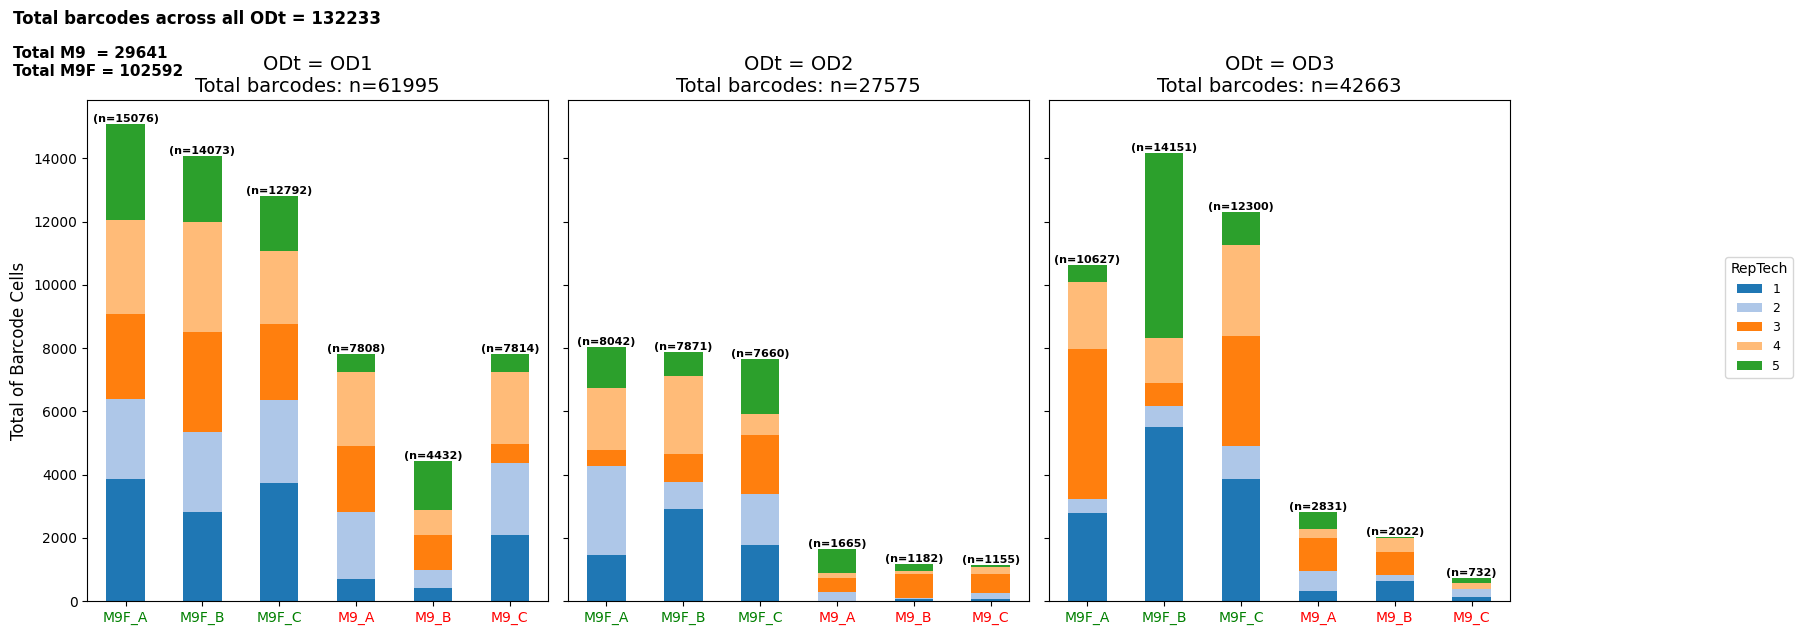


🍽️ Statistics by Culture Medium:

   M9:
     Cells: 29,641
     Mean n_counts: 248
     Mean n_genes: 146

   M9F:
     Cells: 102,592
     Mean n_counts: 285
     Mean n_genes: 155


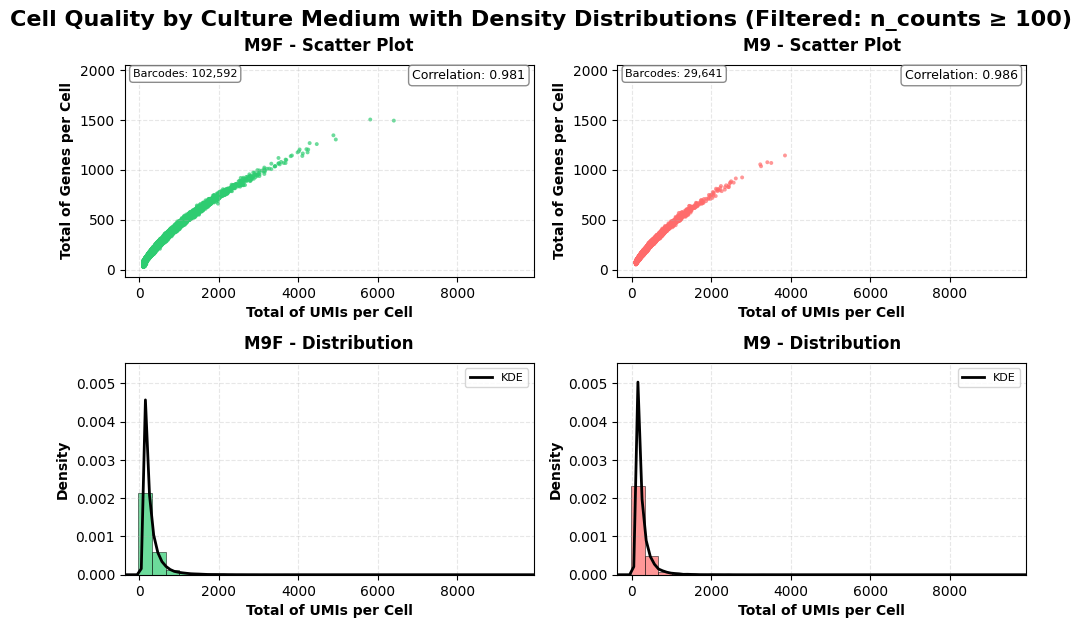


📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):

🍽️ M9F:
   📊 Total cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Min: 100, Max: 9449
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Min: 27, Max: 1956
   🔗 Correlation n_counts vs n_genes: 0.981

🍽️ M9:
   📊 Total cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Min: 100, Max: 3852
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Min: 53, Max: 1144
   🔗 Correlation n_counts vs n_genes: 0.986


<ipython-input-138-25a4aa90d1fc>:397: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-138-25a4aa90d1fc>:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


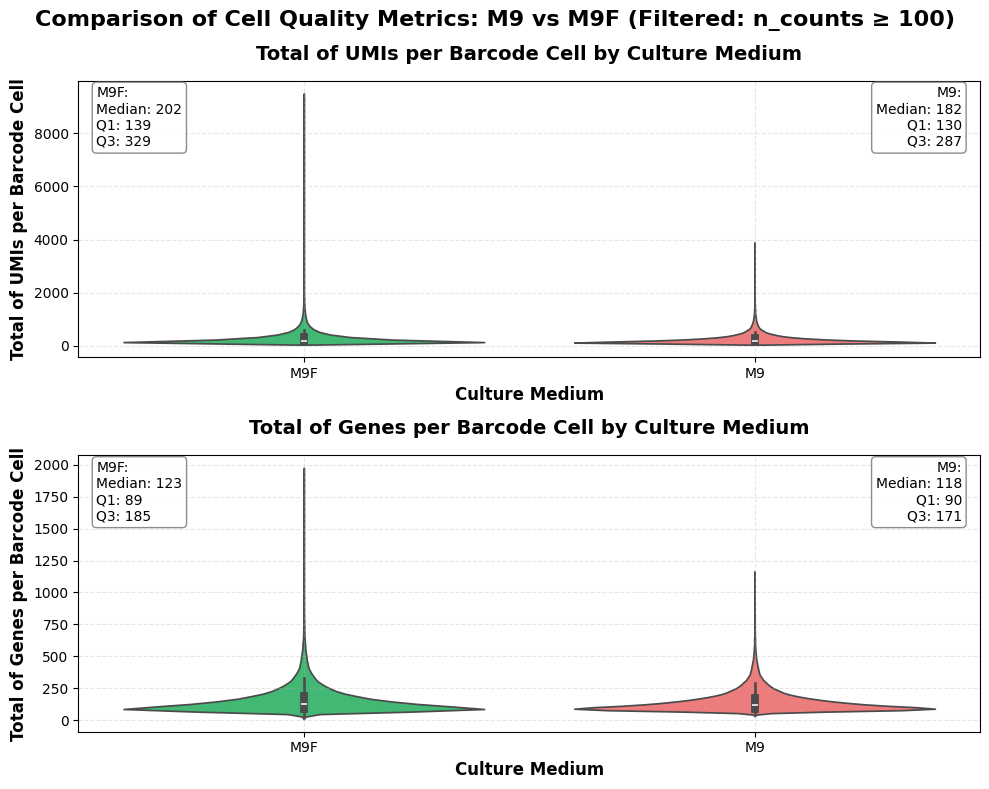


🎻 Violin Plot Comparison: M9 vs M9F
📊 Total cells in comparison: 132,233

🍽️ M9F:
   📊 Cells: 102,592
   📈 n_counts - Mean: 285, Median: 202
   📈 n_counts - Std: 257
   🧬 n_genes - Mean: 155, Median: 123
   🧬 n_genes - Std: 102

🍽️ M9:
   📊 Cells: 29,641
   📈 n_counts - Mean: 248, Median: 182
   📈 n_counts - Std: 203
   🧬 n_genes - Mean: 146, Median: 118
   🧬 n_genes - Std: 86


In [ ]:
adata_fcell_100UMI.obs["RepBio_suffix"] = (
    adata_fcell_100UMI.obs["RepBio"].str.split("_").str[-1]
)


# describe the original adata_fcell_100UMI

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ajouter suffixe de RepTech si pas déjà fait
if "RepTech_suffix" not in adata_fcell_100UMI.obs.columns:
    adata_fcell_100UMI.obs["RepTech_suffix"] = (
        adata_fcell_100UMI.obs["RepTech"].str.split("_").str[-1]
    )

# Grouper les données
counts = (
    adata.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata_fcell_100UMI.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Get unique culture mediums and create color map
culture_mediums = adata_fcell_100UMI.obs["CultureMedium"].unique()
# Create color map with red for M9 and green for M9F
color_map = {}
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:  # M9
        color_map[medium] = "#FF6B6B"  # Red
    elif "M9F" in medium:  # M9F
        color_map[medium] = "#2ECC71"  # Green
    else:  # Other mediums
        color_map[medium] = "#95A5A6"  # Gray for other

# Print statistics by culture medium
print(f"\n🍽️ Statistics by Culture Medium:")
for medium in culture_mediums:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]
    print(f"\n   {medium}:")
    print(f"     Cells: {len(medium_data):,}")
    print(f"     Mean n_counts: {medium_data['n_counts'].mean():.0f}")
    print(f"     Mean n_genes: {medium_data['n_genes'].mean():.0f}")


# Create separate scatter plots for each culture medium with density plots below
# Reorder culture mediums: M9F first (left), M9 second (right)
culture_mediums_ordered = []
for medium in culture_mediums:
    if "M9F" in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" in medium and "F" not in medium:
        culture_mediums_ordered.append(medium)
for medium in culture_mediums:
    if "M9" not in medium:
        culture_mediums_ordered.append(medium)

n_mediums = len(culture_mediums_ordered)
n_cols = min(3, n_mediums)  # Maximum 3 columns
n_rows = 2 * n_mediums  # 2 rows per medium (scatter + density)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Calculate global min/max for consistent scaling
global_x_min = adata_fcell_100UMI.obs["n_counts"].min()
global_x_max = adata_fcell_100UMI.obs["n_counts"].max()
global_y_min = adata_fcell_100UMI.obs["n_genes"].min()
global_y_max = adata_fcell_100UMI.obs["n_genes"].max()

# Add 5% padding to global limits
x_padding = (global_x_max - global_x_min) * 0.05
y_padding = (global_y_max - global_y_min) * 0.05

global_x_lim = (global_x_min - x_padding, global_x_max + x_padding)
global_y_lim = (global_y_min - y_padding, global_y_max + y_padding)

# Calculate global density limits for consistent y-axis scaling in density plots
global_density_max = 0
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    if len(medium_data) > 1:
        # Calculate histogram density
        hist, bins = np.histogram(
            medium_data["n_counts"], bins=30, density=True, range=global_x_lim
        )
        hist_max = hist.max()

        # Calculate KDE density
        from scipy.stats import gaussian_kde

        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(global_x_lim[0], global_x_lim[1], 100)
        kde_density = kde(x_range)
        kde_max = kde_density.max()

        # Take the maximum of both
        medium_max = max(hist_max, kde_max)
        global_density_max = max(global_density_max, medium_max)

# Add 10% padding to density y-axis
global_density_y_lim = (0, global_density_max * 1.1)

for i, medium in enumerate(culture_mediums_ordered):
    # Calculate correct indices for 2-row layout
    col_idx = i % n_cols
    scatter_row = (i // n_cols) * 2
    density_row = (i // n_cols) * 2 + 1

    # Get data for this medium
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    # Create scatter plot (top row)
    scatter_idx = scatter_row * n_cols + col_idx
    ax_scatter = axes_flat[scatter_idx]
    ax_scatter.scatter(
        medium_data["n_counts"],
        medium_data["n_genes"],
        alpha=0.7,
        s=8,  # Reduced point size from 15 to 8
        c=color_map[medium],
        edgecolors="none",
    )

    # Calculate correlation for this medium
    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        # Position correlation text in upper right corner
        ax_scatter.text(
            0.98,
            0.98,
            f"Correlation: {corr:.3f}",
            transform=ax_scatter.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
            ),
        )

    # Add barcode count in upper left corner
    barcode_text = f"Barcodes: {len(medium_data):,}"
    ax_scatter.text(
        0.02,
        0.98,
        barcode_text,
        transform=ax_scatter.transAxes,
        fontsize=8,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="gray"
        ),
    )

    # Customize scatter subplot
    ax_scatter.set_xlabel("Total of UMIs per Cell", fontsize=10, fontweight="bold")
    ax_scatter.set_ylabel("Total of Genes per Cell", fontsize=10, fontweight="bold")
    ax_scatter.set_title(
        f"{medium} - Scatter Plot", fontsize=12, fontweight="bold", pad=10
    )
    ax_scatter.grid(True, alpha=0.3, linestyle="--")

    # Set consistent axis limits for all scatter subplots
    ax_scatter.set_xlim(global_x_lim)
    ax_scatter.set_ylim(global_y_lim)

    # Create density plot (bottom row)
    density_idx = density_row * n_cols + col_idx
    ax_density = axes_flat[density_idx]

    # Create density plot for n_counts with global x limits
    ax_density.hist(
        medium_data["n_counts"],
        bins=30,
        alpha=0.7,
        color=color_map[medium],
        edgecolor="black",
        linewidth=0.5,
        density=True,
        range=global_x_lim,  # Use global x limits for consistent scaling
    )

    # Add KDE curve with global x range
    from scipy.stats import gaussian_kde

    if len(medium_data) > 1:
        kde = gaussian_kde(medium_data["n_counts"])
        x_range = np.linspace(
            global_x_lim[0], global_x_lim[1], 100
        )  # Use global x range
        ax_density.plot(x_range, kde(x_range), color="black", linewidth=2, label="KDE")

    # Customize density subplot
    ax_density.set_xlabel("Total of UMIs per Cell", fontsize=10, fontweight="bold")
    ax_density.set_ylabel("Density", fontsize=10, fontweight="bold")
    ax_density.set_title(
        f"{medium} - Distribution", fontsize=12, fontweight="bold", pad=10
    )
    ax_density.grid(True, alpha=0.3, linestyle="--")
    ax_density.legend(fontsize=8)

    # Set consistent x-axis and y-axis limits for all density plots
    ax_density.set_xlim(global_x_lim)
    ax_density.set_ylim(global_density_y_lim)

# Hide empty subplots
for i in range(n_mediums * 2, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.suptitle(
    "Cell Quality by Culture Medium with Density Distributions (Filtered: n_counts ≥ 100)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

# Print detailed statistics for each medium
print(f"\n📊 Detailed Statistics by Culture Medium (After filtering: n_counts ≥ 100):")
for medium in culture_mediums_ordered:
    mask = adata_fcell_100UMI.obs["CultureMedium"] == medium
    medium_data = adata_fcell_100UMI.obs.loc[mask]

    print(f"\n🍽️ {medium}:")
    print(f"   📊 Total cells: {len(medium_data):,}")
    print(
        f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
    )
    print(
        f"   📈 n_counts - Min: {medium_data['n_counts'].min():.0f}, Max: {medium_data['n_counts'].max():.0f}"
    )
    print(
        f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
    )
    print(
        f"   🧬 n_genes - Min: {medium_data['n_genes'].min():.0f}, Max: {medium_data['n_genes'].max():.0f}"
    )

    if len(medium_data) > 1:
        corr = np.corrcoef(medium_data["n_counts"], medium_data["n_genes"])[0, 1]
        print(f"   🔗 Correlation n_counts vs n_genes: {corr:.3f}")

# Create violin plots comparing M9 and M9F
# Filter data for M9 and M9F only
m9_m9f_mask = adata_fcell_100UMI.obs["CultureMedium"].isin(["M9", "M9F"])
adata_m9_m9f = adata_fcell_100UMI[m9_m9f_mask].copy()

if len(adata_m9_m9f) > 0:
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Violin plot for n_counts (top)
    sns.violinplot(
        data=adata_m9_m9f.obs,
        x="CultureMedium",
        y="n_counts",
        ax=ax1,
        order=["M9F", "M9"],
        palette=["#2ECC71", "#FF6B6B"],
    )
    ax1.set_title(
        "Total of UMIs per Barcode Cell by Culture Medium",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax1.set_xlabel("Culture Medium", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Total of UMIs per Barcode Cell", fontsize=12, fontweight="bold")
    ax1.grid(True, alpha=0.3, linestyle="--")

    # Add statistics on the plot
    for i, medium in enumerate(["M9F", "M9"]):
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            median_val = medium_data["n_counts"].median()
            q1_val = medium_data["n_counts"].quantile(0.25)
            q3_val = medium_data["n_counts"].quantile(0.75)

            # Position M9F on the left, M9 on the right
            if medium == "M9F":
                ax1.text(
                    0.02,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax1.transAxes,
                    fontsize=10,
                    ha="left",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )
            else:  # M9
                ax1.text(
                    0.98,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax1.transAxes,
                    fontsize=10,
                    ha="right",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )

    # Violin plot for n_genes (bottom)
    sns.violinplot(
        data=adata_m9_m9f.obs,
        x="CultureMedium",
        y="n_genes",
        ax=ax2,
        order=["M9F", "M9"],
        palette=["#2ECC71", "#FF6B6B"],
    )
    ax2.set_title(
        "Total of Genes per Barcode Cell by Culture Medium",
        fontsize=14,
        fontweight="bold",
        pad=15,
    )
    ax2.set_xlabel("Culture Medium", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Total of Genes per Barcode Cell", fontsize=12, fontweight="bold")
    ax2.grid(True, alpha=0.3, linestyle="--")

    # Add statistics on the plot
    for i, medium in enumerate(["M9F", "M9"]):
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            median_val = medium_data["n_genes"].median()
            q1_val = medium_data["n_genes"].quantile(0.25)
            q3_val = medium_data["n_genes"].quantile(0.75)

            # Position M9F on the left, M9 on the right
            if medium == "M9F":
                ax2.text(
                    0.02,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax2.transAxes,
                    fontsize=10,
                    ha="left",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )
            else:  # M9
                ax2.text(
                    0.98,
                    0.98,
                    f"{medium}:\nMedian: {median_val:.0f}\nQ1: {q1_val:.0f}\nQ3: {q3_val:.0f}",
                    transform=ax2.transAxes,
                    fontsize=10,
                    ha="right",
                    va="top",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        alpha=0.9,
                        edgecolor="gray",
                    ),
                )

    plt.suptitle(
        "Comparison of Cell Quality Metrics: M9 vs M9F (Filtered: n_counts ≥ 100)",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\n🎻 Violin Plot Comparison: M9 vs M9F")
    print(f"📊 Total cells in comparison: {len(adata_m9_m9f):,}")

    for medium in ["M9F", "M9"]:
        if medium in adata_m9_m9f.obs["CultureMedium"].values:
            medium_data = adata_m9_m9f.obs[adata_m9_m9f.obs["CultureMedium"] == medium]
            print(f"\n🍽️ {medium}:")
            print(f"   📊 Cells: {len(medium_data):,}")
            print(
                f"   📈 n_counts - Mean: {medium_data['n_counts'].mean():.0f}, Median: {medium_data['n_counts'].median():.0f}"
            )
            print(f"   📈 n_counts - Std: {medium_data['n_counts'].std():.0f}")
            print(
                f"   🧬 n_genes - Mean: {medium_data['n_genes'].mean():.0f}, Median: {medium_data['n_genes'].median():.0f}"
            )
            print(f"   🧬 n_genes - Std: {medium_data['n_genes'].std():.0f}")
else:
    print("⚠️ No M9 or M9F data found for violin plot comparison")


# filter Top 5 cells with highest n_counts
##### filter cell

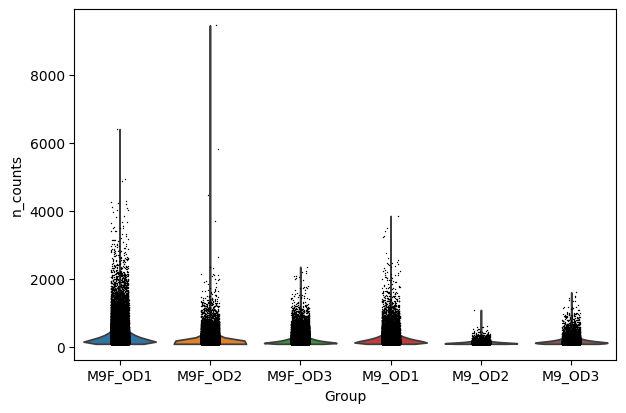

In [ ]:
sc.pl.violin(adata_fcell_100UMI, ["n_counts"], groupby="Group", multi_panel=True)

🗑️ Removing the 5 cells with highest n_counts...
📊 Top 5 n_counts values to remove:
   1. Cell GCTAACGA_ATCCTGTA_GCAAATTC: 9,449 counts
   2. Cell CAACCACA_GTCTGTCA_TTCATCGC: 6,402 counts
   3. Cell ATAGCGAC_CCAGTTCA_GCAAATTC: 5,809 counts
   4. Cell GGTGCGAA_AACGTGAT_TTCATCGC: 4,942 counts
   5. Cell CACCTTAC_TGAAGAGA_GTGGGTTC: 4,882 counts
📊 After removing top 5 cells: 132,228 cells
🗑️ Removed 5 cells with highest n_counts


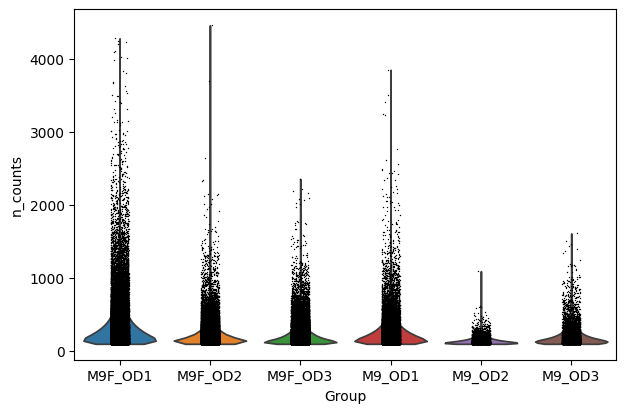

In [ ]:
print("🗑️ Removing the 5 cells with highest n_counts...")

# Get the 5 highest n_counts values
top_5_ncounts = adata_fcell_100UMI.obs["n_counts"].nlargest(5)
print(f"📊 Top 5 n_counts values to remove:")
for i, (idx, value) in enumerate(top_5_ncounts.items(), 1):
    print(f"   {i}. Cell {idx}: {value:,} counts")

# Create mask to exclude these 5 cells
cells_to_remove = top_5_ncounts.index
cells_to_keep = ~adata_fcell_100UMI.obs.index.isin(cells_to_remove)

# Apply filtering
adata_fcell_100UMI_noOut = adata_fcell_100UMI[cells_to_keep].copy()

print(f"📊 After removing top 5 cells: {adata_fcell_100UMI_noOut.n_obs:,} cells")
print(f"🗑️ Removed {len(cells_to_remove)} cells with highest n_counts")

sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

<ipython-input-141-864039366c0b>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-141-864039366c0b>:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut.obs.groupby("CultureMedium")


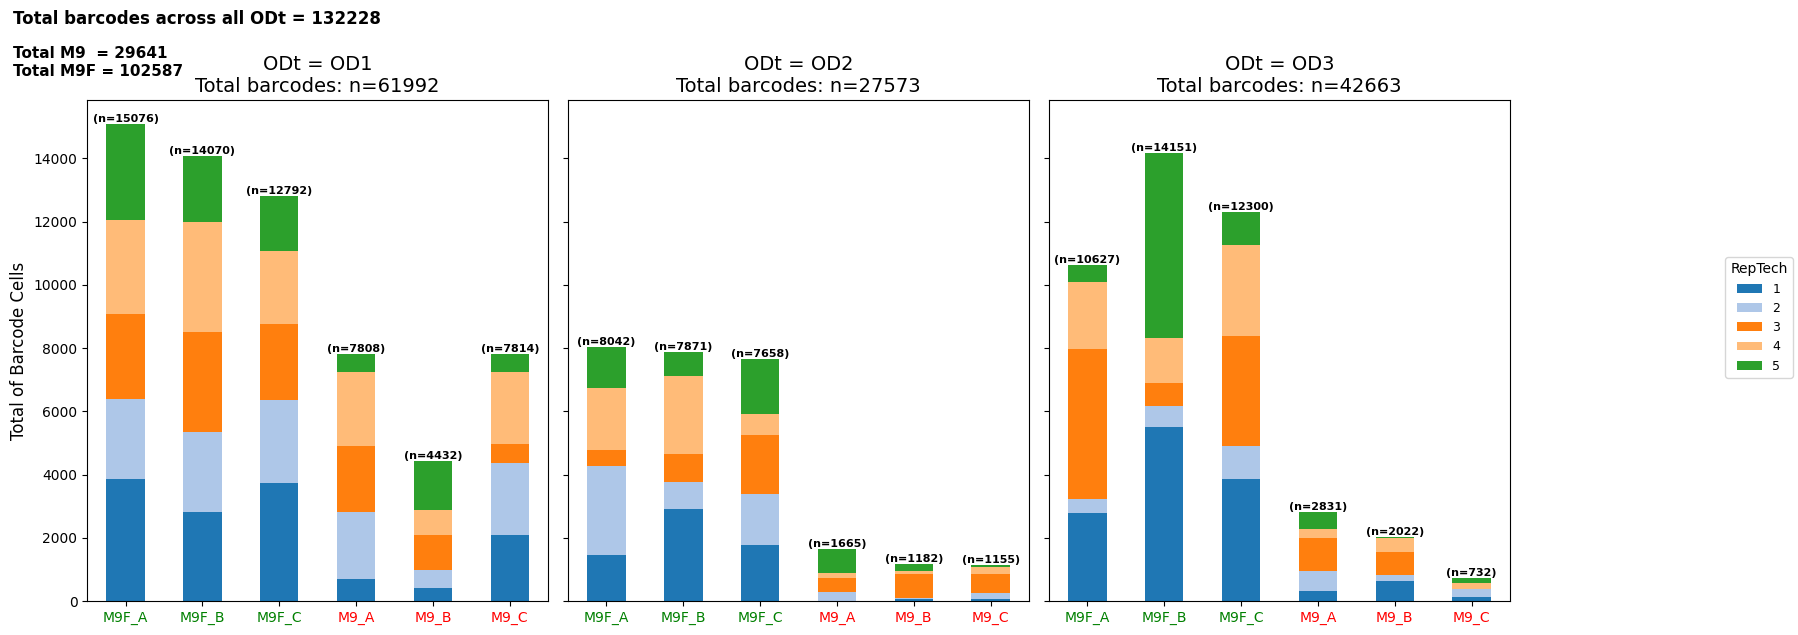

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata_fcell_100UMI_noOut.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

🗑️ Removing the highest M9F_OD2 cell...
📊 Highest n_counts for M9F_OD2: 4,463 counts


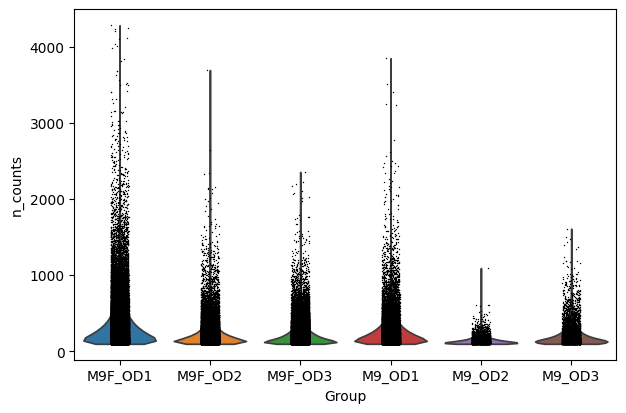

In [ ]:
print("🗑️ Removing the highest M9F_OD2 cell...")
# Get the highest n_counts value for M9F_OD2
highest_m9f_od2 = adata_fcell_100UMI_noOut.obs[
    adata_fcell_100UMI_noOut.obs["Group"] == "M9F_OD2"
]["n_counts"].nlargest(1)
print(f"📊 Highest n_counts for M9F_OD2: {highest_m9f_od2.iloc[0]:,} counts")
# Create mask to exclude this cell
cells_to_remove = highest_m9f_od2.index

adata_fcell_100UMI_noOut = adata_fcell_100UMI_noOut[
    ~adata_fcell_100UMI_noOut.obs.index.isin(cells_to_remove)
].copy()
sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

🗑️ Removing the highest M9_OD2 cell...
📊 Highest n_counts for M9_OD2: 1,095 counts


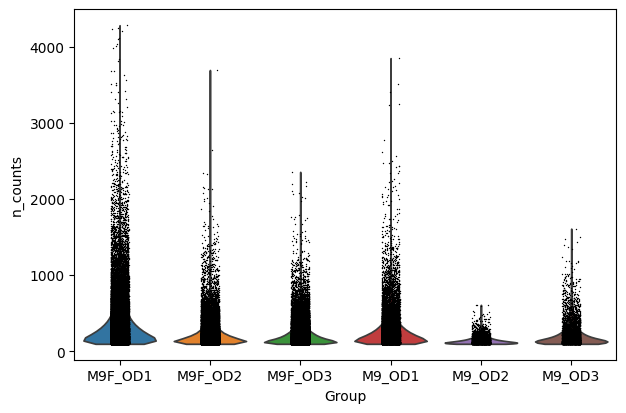

In [ ]:
print("🗑️ Removing the highest M9_OD2 cell...")
# Get the highest n_counts value for M9_OD2
highest_m9_od2 = adata_fcell_100UMI_noOut.obs[
    adata_fcell_100UMI_noOut.obs["Group"] == "M9_OD2"
]["n_counts"].nlargest(1)
print(f"📊 Highest n_counts for M9_OD2: {highest_m9_od2.iloc[0]:,} counts")
# Create mask to exclude this cell
cells_to_remove = highest_m9_od2.index

adata_fcell_100UMI_noOut = adata_fcell_100UMI_noOut[
    ~adata_fcell_100UMI_noOut.obs.index.isin(cells_to_remove)
].copy()
sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

🗑️ Removing the highest M9_OD1 cell...
📊 Highest n_counts for M9_OD1: 3,852 counts


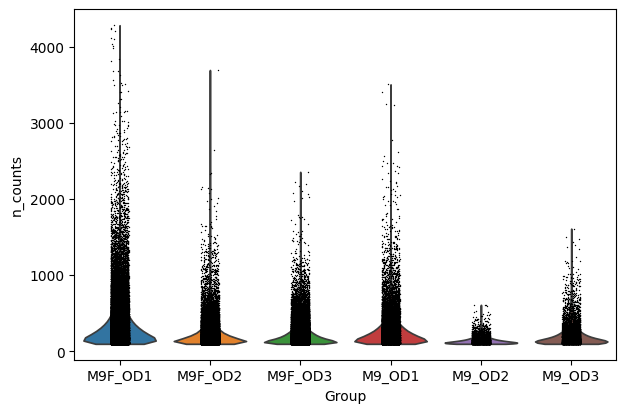

In [ ]:
print("🗑️ Removing the highest M9_OD1 cell...")
# Get the highest n_counts value for M9_OD1
highest_m9_od1 = adata_fcell_100UMI_noOut.obs[
    adata_fcell_100UMI_noOut.obs["Group"] == "M9_OD1"
]["n_counts"].nlargest(1)
print(f"📊 Highest n_counts for M9_OD1: {highest_m9_od1.iloc[0]:,} counts")
# Create mask to exclude this cell
cells_to_remove = highest_m9_od1.index

adata_fcell_100UMI_noOut = adata_fcell_100UMI_noOut[
    ~adata_fcell_100UMI_noOut.obs.index.isin(cells_to_remove)
].copy()
sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

🗑️ Removing the highest M9_OD2 cell...
📊 Highest n_counts for M9_OD2: 611 counts


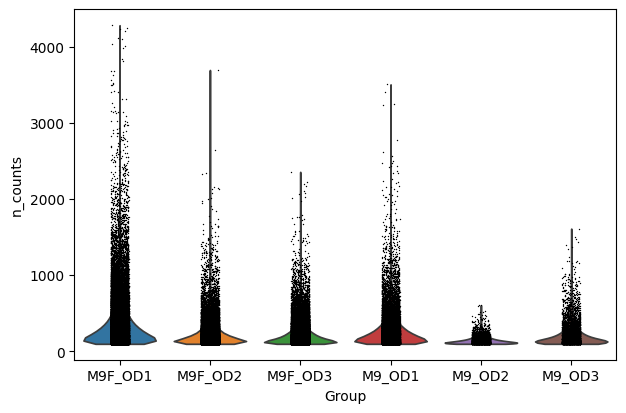

In [ ]:
print("🗑️ Removing the highest M9_OD2 cell...")
# Get the highest n_counts value for M9_OD2
highest_m9_od2 = adata_fcell_100UMI_noOut.obs[
    adata_fcell_100UMI_noOut.obs["Group"] == "M9_OD2"
]["n_counts"].nlargest(1)
print(f"📊 Highest n_counts for M9_OD2: {highest_m9_od2.iloc[0]:,} counts")
# Create mask to exclude this cell
cells_to_remove = highest_m9_od2.index

adata_fcell_100UMI_noOut = adata_fcell_100UMI_noOut[
    ~adata_fcell_100UMI_noOut.obs.index.isin(cells_to_remove)
].copy()
sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

🗑️ Removing the highest M9_OD2 cell...
📊 Highest n_counts for M9F_OD2: 3,696 counts


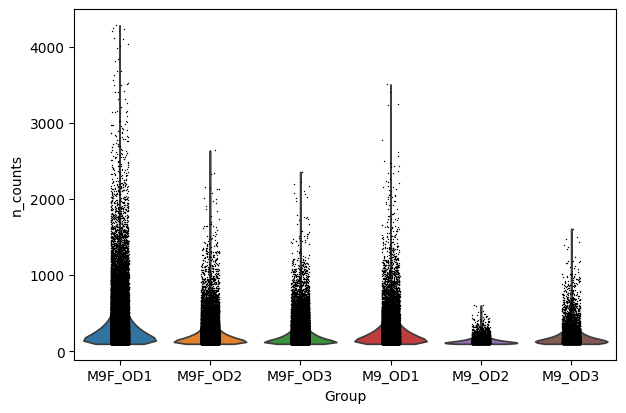

In [ ]:
print("🗑️ Removing the highest M9_OD2 cell...")
# Get the highest n_counts value for M9_OD2
highest_m9f_od2 = adata_fcell_100UMI_noOut.obs[
    adata_fcell_100UMI_noOut.obs["Group"] == "M9F_OD2"
]["n_counts"].nlargest(1)
print(f"📊 Highest n_counts for M9F_OD2: {highest_m9f_od2.iloc[0]:,} counts")
# Create mask to exclude this cell
cells_to_remove = highest_m9f_od2.index

adata_fcell_100UMI_noOut = adata_fcell_100UMI_noOut[
    ~adata_fcell_100UMI_noOut.obs.index.isin(cells_to_remove)
].copy()
sc.pl.violin(adata_fcell_100UMI_noOut, ["n_counts"], groupby="Group", multi_panel=True)

In [ ]:
adata_fcell_100UMI_noOut.obs["n_counts"].describe()

count    132223.000000
mean        276.200154
std         242.964781
min         100.000000
25%         136.000000
50%         197.000000
75%         319.000000
max        4284.000000
Name: n_counts, dtype: float64

In [ ]:
adata_fcell_100UMI_noOut.obs["Group"].value_counts()

Group
M9F_OD1    41938
M9F_OD3    37078
M9F_OD2    23569
M9_OD1     20053
M9_OD3      5585
M9_OD2      4000
Name: count, dtype: int64

In [ ]:
def select_cells_by_group(
    adata: AnnData,
    target_total_cells: int,
    group_by: str = "RepBio",
    sort_by: str = "n_counts",  # souvent stocké dans adata.obs
    random: bool = False,
    seed: int = None,
    descending: bool = True,
):
    meta = adata.obs.copy()
    meta["cell_barcode"] = meta.index

    if group_by not in meta.columns:
        raise ValueError(f"Group column '{group_by}' not found in adata.obs.")
    if sort_by not in meta.columns:
        raise ValueError(f"Sort column '{sort_by}' not found in adata.obs.")

    n_groups = meta[group_by].nunique()
    target_per_group = int(target_total_cells // n_groups)

    print(f"🎯 Target total cells: {target_total_cells}")
    print(f"📁 Group column: '{group_by}' — {n_groups} groups")
    print(f"🧮 Sort by: '{sort_by}' | Descending: {descending}")
    print(f"🔢 Cells per group: {target_per_group}")
    if random and seed is not None:
        print(f"🎲 Random sampling with seed {seed}")

    selected_cells = []

    for group, df_group in meta.groupby(group_by):
        n_available = df_group.shape[0]
        print(f"🔍 Group '{group}': {n_available} cells available")

        if n_available <= target_per_group:
            print(f"✅ Keeping all {n_available} cells")
            selected = df_group["cell_barcode"].tolist()
        else:
            if random:
                selected = df_group.sample(n=target_per_group, random_state=seed)[
                    "cell_barcode"
                ].tolist()
            else:
                df_sorted = df_group.sort_values(by=sort_by, ascending=not descending)
                selected = df_sorted.head(target_per_group)["cell_barcode"].tolist()
        selected_cells.extend(selected)

    adata_filtered = adata[selected_cells].copy()

    # Résumé par groupe
    summary = adata_filtered.obs.groupby(group_by).size().reset_index(name="n_cells")

    return {"adata": adata_filtered, "summary": summary}

In [ ]:
adata_fcell_100UMI_noOut.obs["OD"].value_counts()

OD
M9F_A_OD1    15076
M9F_B_OD3    14151
M9F_B_OD1    14070
M9F_C_OD1    12792
M9F_C_OD3    12300
M9F_A_OD3    10627
M9F_A_OD2     8041
M9F_B_OD2     7871
M9_C_OD1      7813
M9_A_OD1      7808
M9F_C_OD2     7657
M9_B_OD1      4432
M9_A_OD3      2831
M9_B_OD3      2022
M9_A_OD2      1665
M9_B_OD2      1181
M9_C_OD2      1154
M9_C_OD3       732
Name: count, dtype: int64

In [ ]:
# Ajoute les totaux d'ARN si nécessaire
adata_fcell_100UMI_noOut.obs["n_counts"] = (
    adata_fcell_100UMI_noOut.X.sum(axis=1).A1
    if hasattr(adata_fcell_100UMI_noOut.X, "A1")
    else adata_fcell_100UMI_noOut.X.sum(axis=1)
)

# Sous-échantillonne
result = select_cells_by_group(
    adata=adata_fcell_100UMI_noOut,
    target_total_cells=3000,
    group_by="OD",
    sort_by="n_counts",
    random=False,
    seed=42,
    descending=True,
)

adata_filtered = result["adata"]
print(result["summary"])

adata_fcell_100UMI_noOut_OD = adata_filtered.copy()

🎯 Target total cells: 3000
📁 Group column: 'OD' — 18 groups
🧮 Sort by: 'n_counts' | Descending: True
🔢 Cells per group: 166
🔍 Group 'M9F_A_OD1': 15076 cells available
🔍 Group 'M9F_A_OD2': 8041 cells available
🔍 Group 'M9F_A_OD3': 10627 cells available
🔍 Group 'M9F_B_OD1': 14070 cells available
🔍 Group 'M9F_B_OD2': 7871 cells available
🔍 Group 'M9F_B_OD3': 14151 cells available
🔍 Group 'M9F_C_OD1': 12792 cells available
🔍 Group 'M9F_C_OD2': 7657 cells available
🔍 Group 'M9F_C_OD3': 12300 cells available
🔍 Group 'M9_A_OD1': 7808 cells available
🔍 Group 'M9_A_OD2': 1665 cells available
🔍 Group 'M9_A_OD3': 2831 cells available
🔍 Group 'M9_B_OD1': 4432 cells available
🔍 Group 'M9_B_OD2': 1181 cells available
🔍 Group 'M9_B_OD3': 2022 cells available
🔍 Group 'M9_C_OD1': 7813 cells available
🔍 Group 'M9_C_OD2': 1154 cells available
🔍 Group 'M9_C_OD3': 732 cells available
           OD  n_cells
0   M9F_A_OD1      166
1   M9F_A_OD2      166
2   M9F_A_OD3      166
3   M9F_B_OD1      166
4   M9F_B

<ipython-input-149-ceeeeaa609e8>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df_group in meta.groupby(group_by):
<ipython-input-149-ceeeeaa609e8>:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = adata_filtered.obs.groupby(group_by).size().reset_index(name="n_cells")


In [ ]:
adata_fcell_100UMI_noOut_OD.obs["OD"].value_counts()

OD
M9F_A_OD1    166
M9F_A_OD2    166
M9_C_OD2     166
M9_C_OD1     166
M9_B_OD3     166
M9_B_OD2     166
M9_B_OD1     166
M9_A_OD3     166
M9_A_OD2     166
M9_A_OD1     166
M9F_C_OD3    166
M9F_C_OD2    166
M9F_C_OD1    166
M9F_B_OD3    166
M9F_B_OD2    166
M9F_B_OD1    166
M9F_A_OD3    166
M9_C_OD3     166
Name: count, dtype: int64

<ipython-input-153-7da5d124b6cb>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_OD.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-153-7da5d124b6cb>:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_OD.obs.groupby("CultureMedium")


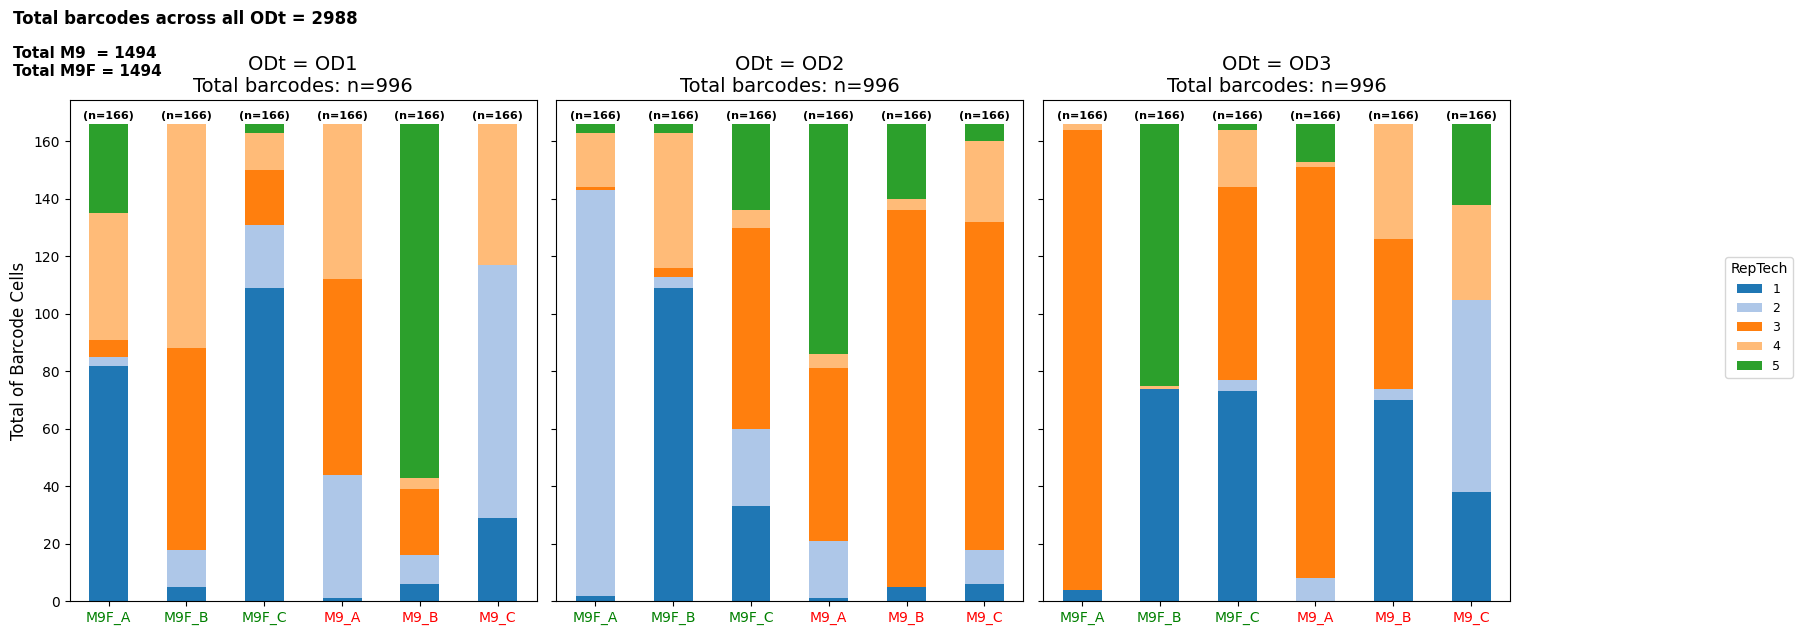

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata_fcell_100UMI_noOut_OD.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut_OD.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
adata_fcell_100UMI_noOut_OD.obs["n_counts"].describe()

count    2988.000000
mean      936.328648
std       647.878541
min       193.000000
25%       431.750000
50%       840.000000
75%      1181.000000
max      4284.000000
Name: n_counts, dtype: float64

In [ ]:
adata_fcell_100UMI_noOut_OD.obs.groupby("RepTech")["n_counts"].describe()

<ipython-input-155-5a57df136369>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_OD.obs.groupby("RepTech")["n_counts"].describe()


,count,mean,std,min,25%,50%,75%,max
RepTech,,,,,,,,
M9F_A_OD1_1,82.0,1704.048780,382.682214,1330.0,1451.00,1574.0,1832.00,3566.0
M9F_A_OD1_2,3.0,1388.000000,22.605309,1369.0,1375.50,1382.0,1397.50,1413.0
M9F_A_OD1_3,6.0,1546.166667,119.045229,1343.0,1532.25,1549.0,1588.25,1708.0
M9F_A_OD1_4,44.0,1589.613636,270.890025,1329.0,1377.50,1516.5,1679.00,2536.0
M9F_A_OD1_5,31.0,1611.967742,354.706497,1342.0,1427.50,1501.0,1627.50,3021.0
...,...,...,...,...,...,...,...,...
M9_C_OD2_5,6.0,238.666667,42.443688,204.0,208.25,225.0,251.50,315.0
M9_C_OD3_1,38.0,270.631579,89.126518,200.0,215.75,242.5,264.75,589.0
M9_C_OD3_2,67.0,295.044776,96.796480,200.0,234.00,265.0,324.50,720.0


In [ ]:
adata_fcell_100UMI_noOut_OD.obs.groupby("OD")["n_counts"].describe()

<ipython-input-156-659924ae4b1d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_OD.obs.groupby("OD")["n_counts"].describe()


,count,mean,std,min,25%,50%,75%,max
OD,,,,,,,,
M9F_A_OD1,166.0,1645.102410,344.439389,1329.0,1413.75,1545.0,1729.50,3566.0
M9F_A_OD2,166.0,1086.222892,296.382500,796.0,885.00,985.5,1161.75,2150.0
M9F_A_OD3,166.0,1129.554217,271.848855,871.0,950.25,1053.5,1180.75,2227.0
M9F_B_OD1,166.0,2693.162651,531.712696,2127.0,2282.50,2548.5,2915.50,4284.0
M9F_B_OD2,166.0,1084.174699,266.045906,797.0,890.00,1018.0,1232.00,2344.0
M9F_B_OD3,166.0,923.975904,203.233407,748.0,786.25,875.0,987.50,2193.0
M9F_C_OD1,166.0,1037.879518,190.276252,824.0,880.25,984.5,1138.50,1796.0
M9F_C_OD2,166.0,913.734940,307.083251,652.0,718.00,780.5,1022.50,2639.0
M9F_C_OD3,166.0,814.132530,273.551580,612.0,659.00,715.0,869.75,2358.0


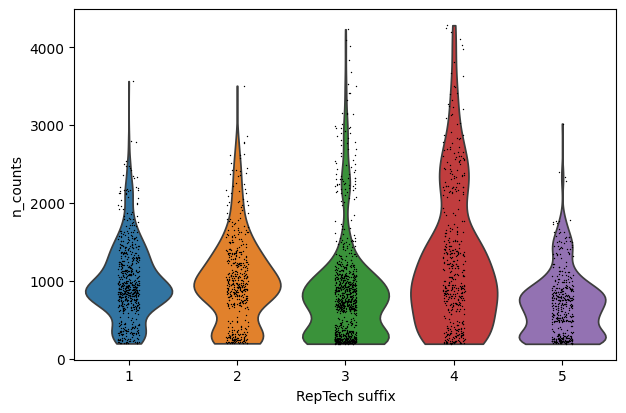

In [ ]:
sc.pl.violin(
    adata_fcell_100UMI_noOut_OD,
    ["n_counts"],
    groupby="RepTech_suffix",
    multi_panel=True,
)

In [ ]:
adata_fcell_100UMI_noOut_no = adata_fcell_100UMI_noOut_OD.copy()

In [ ]:
test = adata_fcell_100UMI_noOut_no.obs["RepTech"].value_counts()
pd.DataFrame(test)

# M9F_A_OD1_1
# M9F_A_OD1_5
# M9_A_OD1_1
# M9_A_OD1_3
# M9_C_OD1_2

# M9F_A_OD2_1
# M9F_A_OD2_3
# M9F_C_OD2_3
# M9F_C_OD2_5
# M9F_A_OD2_5 x2


# M9F_B_OD3_1
# M9F_B_OD3_4

# M9F_C_OD3_3
# M9_A_OD3_4
# M9_B_OD3_3

,count
RepTech,
M9F_A_OD3_3,160
M9_A_OD3_3,143
M9F_A_OD2_2,141
M9_B_OD2_3,131
M9_B_OD1_5,123
...,...
M9_A_OD3_4,2
M9F_A_OD2_3,1
M9_A_OD2_1,1


📊 Number of cells before removing outliers: 2,988 cells
🗑️ Removing 16 outlier cells...
📊 Cells to remove: ['TCTTCACA_GAATCTGA_TACCTAGA', 'GAGCTGAA_AACTCACC_CTGCTTTG', 'AATGTTGC_GCCACATA_CGAACGTC', 'ATTGGCTC_GTCTGTCA_GACGGGAC', 'CGAACTTA_AGCACCTC_TACCTAGA', 'ACAGCAGA_ACACAGAA_ACCGTACG', 'CGCATACA_AACGCTTA_ACTCGTAA', 'GAACAGGC_ATTGAGGA_AGGATTAA', 'GTCTGTCA_CCATCCTC_TCTTAATC', 'GACAGTGC_AACGTGAT_TGCTTGGG', 'CAATGGAA_CAAGGAGC_TACGGTTA', 'CCTAATCC_CCAGTTCA_CCGAGAAA', 'ATCATTCC_ACACAGAA_CTGTCCCG', 'AGCCATGC_GTGTTCTA_GACAAAGC', 'ATCATTCC_CCTAATCC_TTCCGATC', 'AACCGAGA_TCTTCACA_GCAAATTC']
📊 After removing outliers: 2,972 cells
🗑️ Removed 16 outlier cells


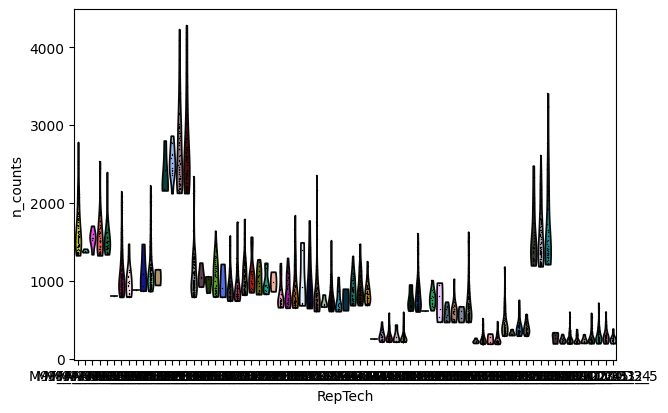

In [ ]:
# Collect all cells to remove

# Print number of cells before removing outliers
print(
    f"📊 Number of cells before removing outliers: {adata_fcell_100UMI_noOut_no.n_obs:,} cells"
)

# Initialize list to store cells to remove
cells_to_remove = []

# Process OD1 groups
od1_groups = {
    "M9F_A_OD1_1": 1,
    "M9F_A_OD1_5": 1,
    "M9_A_OD1_1": 1,
    "M9_A_OD1_3": 1,
    "M9_C_OD1_2": 1,
}

for od, n_cells in od1_groups.items():
    highest = adata_fcell_100UMI_noOut_no.obs[
        adata_fcell_100UMI_noOut_no.obs["RepTech"] == od
    ]["n_counts"].nlargest(n_cells)
    cells_to_remove.extend(highest.index.tolist())

# Process OD2 groups
od2_groups = {
    "M9F_A_OD2_1": 1,
    "M9F_A_OD2_3": 1,
    "M9F_C_OD2_3": 1,
    "M9F_C_OD2_5": 1,
    "M9F_A_OD2_5": 2,  # Remove 2 cells for this group
}

for od, n_cells in od2_groups.items():
    highest = adata_fcell_100UMI_noOut_no.obs[
        adata_fcell_100UMI_noOut_no.obs["RepTech"] == od
    ]["n_counts"].nlargest(n_cells)
    cells_to_remove.extend(highest.index.tolist())

# Process OD3 groups
od3_groups = {
    "M9F_B_OD3_1": 1,
    "M9F_B_OD3_4": 1,
    "M9F_C_OD3_3": 1,
    "M9_A_OD3_4": 1,
    "M9_B_OD3_3": 1,
}

for od, n_cells in od3_groups.items():
    highest = adata_fcell_100UMI_noOut_no.obs[
        adata_fcell_100UMI_noOut_no.obs["RepTech"] == od
    ]["n_counts"].nlargest(n_cells)
    cells_to_remove.extend(highest.index.tolist())

# Remove duplicate cells
cells_to_remove = list(set(cells_to_remove))

print(f"🗑️ Removing {len(cells_to_remove)} outlier cells...")
print(f"📊 Cells to remove: {cells_to_remove}")

# Create mask to exclude these cells
cells_to_keep = ~adata_fcell_100UMI_noOut_no.obs.index.isin(cells_to_remove)

# Apply filtering
adata_fcell_100UMI_noOut_no = adata_fcell_100UMI_noOut_no[cells_to_keep].copy()

print(f"📊 After removing outliers: {adata_fcell_100UMI_noOut_no.n_obs:,} cells")
print(f"🗑️ Removed {len(cells_to_remove)} outlier cells")

# Show violin plot after outlier removal
sc.pl.violin(
    adata_fcell_100UMI_noOut_no, ["n_counts"], groupby="RepTech", multi_panel=True
)

In [ ]:
adata_fcell_100UMI_noOut_OD

AnnData object with n_obs × n_vars = 2988 × 6248
    obs: 'barcode', 'Well_loc_rd1', 'Well_loc_rd2', 'Well_loc_rd3', 'CultureMedium', 'RepBio', 'OD', 'RepTech', 'ODt', 'OD_theoric', 'OD_measured', 'Group', 'n_counts', 'n_genes', 'RepTech_suffix', 'RepBio_suffix'
    var: 'feature_id', 'gene_id', 'feature_type', 'Accession', 'Begin', 'End', 'Chromosome', 'Orientation', 'Name', 'Symbol', 'Gene ID', 'Gene Type', 'Transcripts accession', 'Transcript name', 'Protein accession', 'Protein name', 'Protein length', 'symbol_old', 'locus_tag_old', 'symbol_renamed', 'final_gene_name'
    uns: 'gene_metadata_added', 'gene_metadata_source', 'genes_with_metadata', 'matrix_type', 'name', 'source', 'total_genes', 'Group_colors', 'RepTech_suffix_colors'

In [ ]:
adata_fcell_100UMI_noOut_no

AnnData object with n_obs × n_vars = 2972 × 6248
    obs: 'barcode', 'Well_loc_rd1', 'Well_loc_rd2', 'Well_loc_rd3', 'CultureMedium', 'RepBio', 'OD', 'RepTech', 'ODt', 'OD_theoric', 'OD_measured', 'Group', 'n_counts', 'n_genes', 'RepTech_suffix', 'RepBio_suffix'
    var: 'feature_id', 'gene_id', 'feature_type', 'Accession', 'Begin', 'End', 'Chromosome', 'Orientation', 'Name', 'Symbol', 'Gene ID', 'Gene Type', 'Transcripts accession', 'Transcript name', 'Protein accession', 'Protein name', 'Protein length', 'symbol_old', 'locus_tag_old', 'symbol_renamed', 'final_gene_name'
    uns: 'gene_metadata_added', 'gene_metadata_source', 'genes_with_metadata', 'matrix_type', 'name', 'source', 'total_genes', 'Group_colors', 'RepTech_suffix_colors', 'RepTech_colors'

In [ ]:
# nombre de cellules total
n_cells_before_filtering = adata_fcell_100UMI_noOut_OD.n_obs
print(f"Number of cells before filtering: {n_cells_before_filtering}")

Number of cells before filtering: 2988


In [ ]:
n_cells_after_filtering = adata_fcell_100UMI_noOut_no.n_obs
print(f"Number of cells after filtering: {n_cells_after_filtering}")

Number of cells after filtering: 2972


In [ ]:
n_cells_removed = n_cells_before_filtering - n_cells_after_filtering
print(f"Number of cells removed: {n_cells_removed}")

Number of cells removed: 16


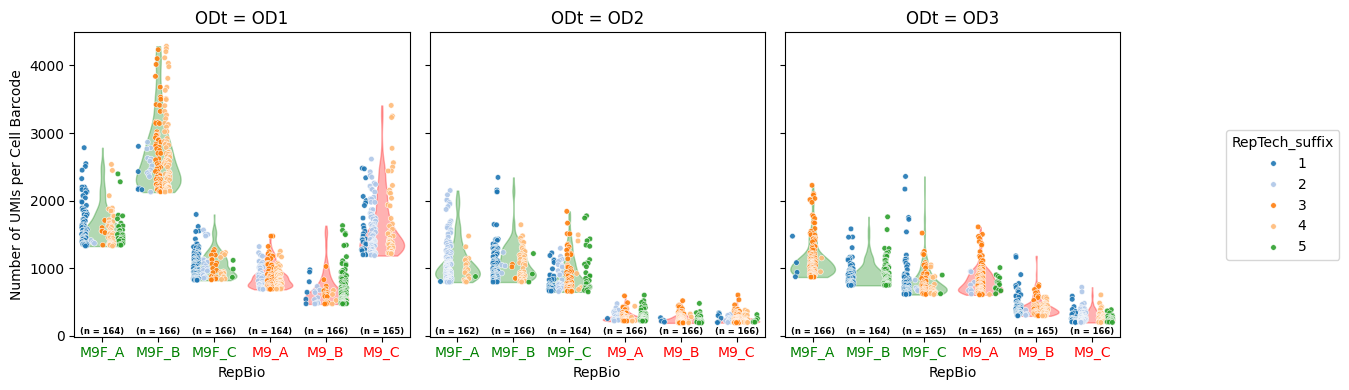

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Preprocessing
df = adata_fcell_100UMI_noOut_no.obs.copy()
df["n_counts"] = adata_fcell_100UMI_noOut_no.obs["n_counts"]
df["RepTech_suffix"] = df["RepTech"].astype(str).str.split("_").str[-1]
df["ODt"] = df["ODt"].astype(str)
df["RepBio"] = df["RepBio"].astype(str)
df["RepTech_suffix"] = df["RepTech_suffix"].astype(str)

# Paramètres
col_wrap = 3
repbios = sorted(df["RepBio"].unique())
odts = sorted(df["ODt"].unique())

# Palette tab20 personnalisée dans l'ordre numérique
reptech_suffixes = sorted(df["RepTech_suffix"].unique(), key=lambda x: int(x))
tab20_colors = sns.color_palette("tab20", n_colors=len(reptech_suffixes))
palette = dict(zip(reptech_suffixes, tab20_colors))

# Groupes à colorer
group_vert = ["M9F_A", "M9F_B", "M9F_C"]
group_rouge = ["M9_A", "M9_B", "M9_C"]
repbio_colors = {
    repbio: (
        "green" if repbio in group_vert else "red" if repbio in group_rouge else "gray"
    )
    for repbio in repbios
}

# Setup grid
n_cols = col_wrap
n_rows = int(np.ceil(len(odts) / col_wrap))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, odt in enumerate(odts):
    ax = axes[i]
    data_odt = df[df["ODt"] == odt]

    for j, repbio in enumerate(repbios):
        data_subset = data_odt[data_odt["RepBio"] == repbio]
        values = data_subset["n_counts"].dropna()

        if len(values) < 2:
            continue

        # KDE
        kde = gaussian_kde(values, bw_method=0.3)
        x_vals = np.linspace(values.min(), values.max(), 100)
        density = kde(x_vals)
        width = 0.4
        density = density / density.max() * width

        violin_color = repbio_colors.get(repbio, "gray")

        # Tracé du violon
        ax.fill_betweenx(
            x_vals, j - density, j + density, color=violin_color, alpha=0.3, linewidth=1
        )

        # Affiche n
        ax.text(
            j,
            -0.2,
            f"(n = {len(values)})",
            ha="center",
            va="bottom",
            fontsize=6,
            fontweight="bold",
            color="black",
        )

    # Stripplot avec hue_order pour contrôler l'ordre de la légende
    sns.stripplot(
        data=data_odt,
        x="RepBio",
        y="n_counts",
        hue="RepTech_suffix",
        dodge=True,
        jitter=0.25,
        size=4,
        ax=ax,
        alpha=0.9,
        edgecolor="white",
        linewidth=0.4,
        palette=palette,
        order=repbios,
        hue_order=reptech_suffixes,  # Ordre numérique 1 à 5
    )

    if handles is None and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        ax.legend_.remove()

    ax.set_title(f"ODt = {odt}")
    ax.set_xticks(range(len(repbios)))
    ax.set_xticklabels(repbios, rotation=0)
    ax.set_ylabel("Number of UMIs per Cell Barcode")

    # Colorer étiquettes x
    for tick_label in ax.get_xticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(repbio_colors.get(label_text, "gray"))

# Supprimer les axes vides
for j in range(len(odts), len(axes)):
    fig.delaxes(axes[j])

# Légende commune dans l'ordre voulu
if handles is not None:
    fig.legend(
        handles,
        labels,
        title="RepTech_suffix",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
    )

plt.tight_layout(rect=[0, 0, 0.95, 1])


plt.show()

<ipython-input-167-c92752d79a4b>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_no.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-167-c92752d79a4b>:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")


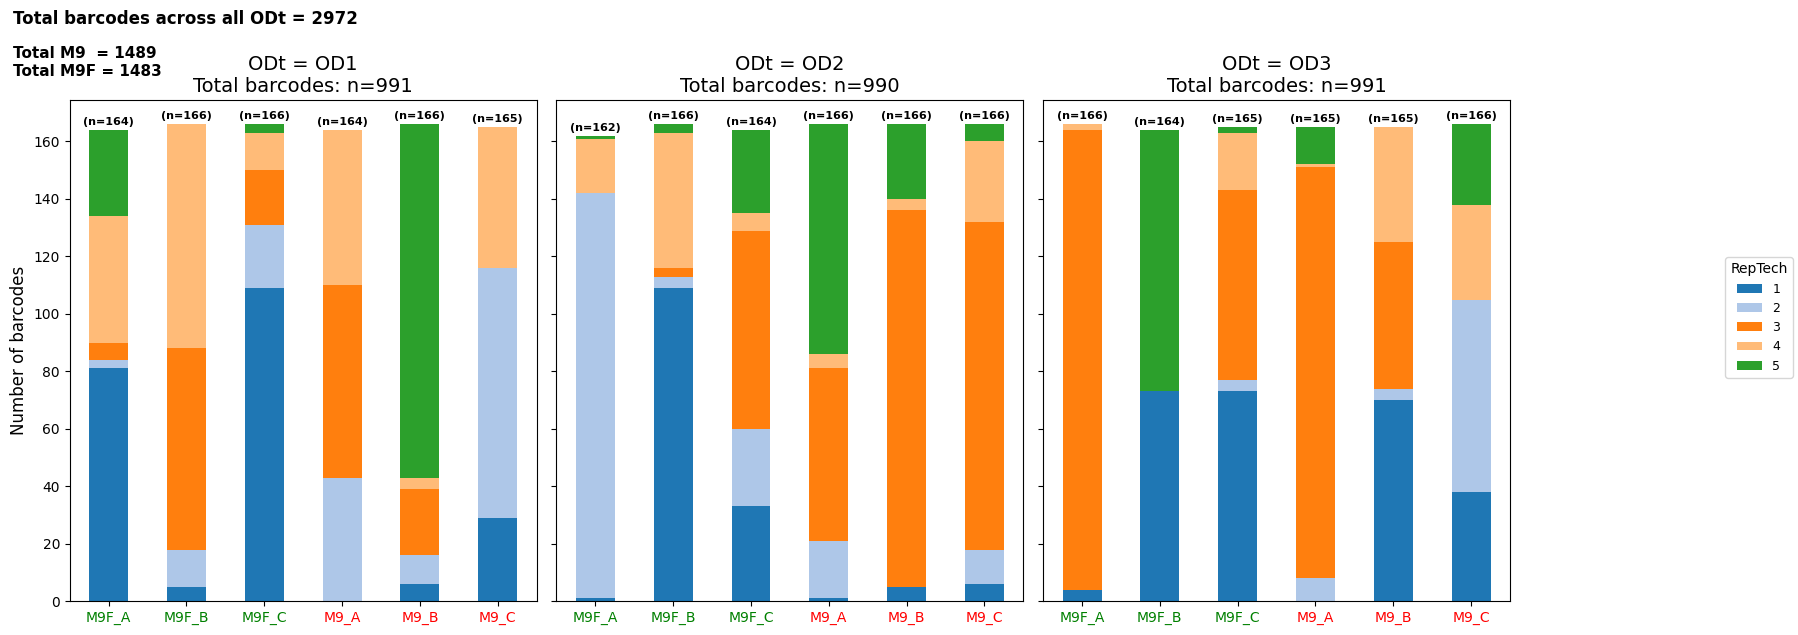

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata_fcell_100UMI_noOut_no.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Number of barcodes", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
adata_fcell_100UMI_noOut_OD.var["Gene Type"].value_counts()

adata_fcell_100UMI_noOut_OD.var["Gene Type"].unique()

['rRNA', 'tRNA', 'protein-coding', 'other', 'pseudogene', 'RNase_P_RNA', 'ncRNA']
Categories (7, object): ['RNase_P_RNA', 'ncRNA', 'other', 'protein-coding', 'pseudogene', 'rRNA', 'tRNA']

In [ ]:
adata1 = adata_fcell_100UMI_noOut_no.copy()

In [ ]:
adata1.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,Gene Type,Transcripts accession,Transcript name,Protein accession,Protein name,Protein length,symbol_old,locus_tag_old,symbol_renamed,final_gene_name
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00005,gene-QLH64_00005,QLH64-00005,Gene Expression,CP125961.1,529,2065,chromosome,plus,16S ribosomal RNA,NaN,...,rRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00005,True,QLH64-00005
QLH64-00010,gene-QLH64_00010,QLH64-00010,Gene Expression,CP125961.1,2147,2223,chromosome,plus,tRNA-Ile,NaN,...,tRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00010,True,QLH64-00010
QLH64-00015,gene-QLH64_00015,QLH64-00015,Gene Expression,CP125961.1,2254,2329,chromosome,plus,tRNA-Ala,NaN,...,tRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00015,True,QLH64-00015
QLH64-00020,gene-QLH64_00020,QLH64-00020,Gene Expression,CP125961.1,2575,5466,chromosome,plus,23S ribosomal RNA,NaN,...,rRNA,NaN,NaN,NaN,NaN,NaN,NaN,QLH64_00020,True,QLH64-00020
QLH64-00025,gene-QLH64_00025,QLH64-00025,Gene Expression,CP125961.1,5622,5737,unknown,plus,5S ribosomal RNA,rrf_1,...,rRNA,NaN,NaN,NaN,NaN,NaN,rrf,QLH64_00025,True,rrf_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,protein-coding,NaN,NaN,WHS57493.1,hypothetical protein,97.0,NaN,QLH64_31225,True,QLH64-31225
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,protein-coding,NaN,NaN,WHS57647.1,recombinase RecA,351.0,recA,QLH64_31230,True,recA_2
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,protein-coding,NaN,NaN,WHS57494.1,helix-hairpin-helix domain-containing protein,236.0,NaN,QLH64_31235,True,QLH64-31235


In [ ]:
adata1.obs

,barcode,Well_loc_rd1,Well_loc_rd2,Well_loc_rd3,CultureMedium,RepBio,OD,RepTech,ODt,OD_theoric,OD_measured,Group,n_counts,n_genes,RepTech_suffix,RepBio_suffix
barcode,,,,,,,,,,,,,,,,
GATGAATC_AATGTTGC_CTGCTTTG,GATGAATC_AATGTTGC_CTGCTTTG,E1,G1,H11,M9F,M9F_A,M9F_A_OD1,M9F_A_OD1_1,OD1,0.1,0.173,M9F_OD1,2783,887,1,A
ACTATGCA_GAGCTGAA_CTGCTTTG,ACTATGCA_GAGCTGAA_CTGCTTTG,E1,D12,B11,M9F,M9F_A,M9F_A_OD1,M9F_A_OD1_1,OD1,0.1,0.173,M9F_OD1,2547,891,1,A
CGAACTTA_GTCTGTCA_CTACCCTA,CGAACTTA_GTCTGTCA_CTACCCTA,H1,E10,D4,M9F,M9F_A,M9F_A_OD1,M9F_A_OD1_4,OD1,0.1,0.173,M9F_OD1,2536,832,4,A
TATCAGCA_GACTAGTA_CTGCTTTG,TATCAGCA_GACTAGTA_CTGCTTTG,E1,C7,F1,M9F,M9F_A,M9F_A_OD1,M9F_A_OD1_1,OD1,0.1,0.173,M9F_OD1,2506,861,1,A
ACCACTGT_ATCCTGTA_CTGCTTTG,ACCACTGT_ATCCTGTA_CTGCTTTG,E1,C4,A5,M9F,M9F_A,M9F_A_OD1,M9F_A_OD1_1,OD1,0.1,0.173,M9F_OD1,2451,853,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGAGCCA_AATCCGTC_ATTCATGG,CTGAGCCA_AATCCGTC_ATTCATGG,A9,F12,D8,M9,M9_C,M9_C_OD3,M9_C_OD3_1,OD3,0.8,0.260,M9_OD3,201,132,1,C
ACGCTCGA_AAGACGGA_ATCGCATA,ACGCTCGA_AAGACGGA_ATCGCATA,A11,B4,B9,M9,M9_C,M9_C_OD3,M9_C_OD3_5,OD3,0.8,0.260,M9_OD3,200,135,5,C
CGGATTGC_CACCTTAC_ACGCCGGC,CGGATTGC_CACCTTAC_ACGCCGGC,B9,G12,H6,M9,M9_C,M9_C_OD3,M9_C_OD3_2,OD3,0.8,0.260,M9_OD3,200,129,2,C


In [ ]:
adata1 = adata1[:, adata1.var["Gene Type"] == "protein-coding"]

adata1.var["Gene Type"].value_counts()

Gene Type
protein-coding    6099
Name: count, dtype: int64

In [ ]:
# remove ncount column
adata1.obs.drop(columns=["n_counts"], inplace=True)

In [ ]:
adata1.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,Gene Type,Transcripts accession,Transcript name,Protein accession,Protein name,Protein length,symbol_old,locus_tag_old,symbol_renamed,final_gene_name
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00030,gene-QLH64_00030,QLH64-00030,Gene Expression,CP125961.1,5894,9346,unknown,plus,exodeoxyribonuclease V subunit gamma,recC,...,protein-coding,NaN,NaN,WHS54405.1,exodeoxyribonuclease V subunit gamma,1150.0,recC,QLH64_00030,False,recC
QLH64-00035,gene-QLH64_00035,QLH64-00035,Gene Expression,CP125961.1,9343,13032,unknown,plus,exodeoxyribonuclease V subunit beta,recB,...,protein-coding,NaN,NaN,WHS54406.1,exodeoxyribonuclease V subunit beta,1229.0,recB,QLH64_00035,False,recB
QLH64-00040,gene-QLH64_00040,QLH64-00040,Gene Expression,CP125961.1,13029,15125,unknown,plus,exodeoxyribonuclease V subunit alpha,recD,...,protein-coding,NaN,NaN,WHS54407.1,exodeoxyribonuclease V subunit alpha,698.0,recD,QLH64_00040,False,recD
QLH64-00045,gene-QLH64_00045,QLH64-00045,Gene Expression,CP125961.1,15265,15840,chromosome,plus,YfiR family protein,NaN,...,protein-coding,NaN,NaN,WHS54408.1,YfiR family protein,191.0,NaN,QLH64_00045,True,QLH64-00045
QLH64-00050,gene-QLH64_00050,QLH64-00050,Gene Expression,CP125961.1,15837,17105,chromosome,plus,diguanylate cyclase,NaN,...,protein-coding,NaN,NaN,WHS54409.1,diguanylate cyclase,422.0,NaN,QLH64_00050,True,QLH64-00050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,protein-coding,NaN,NaN,WHS57493.1,hypothetical protein,97.0,NaN,QLH64_31225,True,QLH64-31225
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,protein-coding,NaN,NaN,WHS57647.1,recombinase RecA,351.0,recA,QLH64_31230,True,recA_2
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,protein-coding,NaN,NaN,WHS57494.1,helix-hairpin-helix domain-containing protein,236.0,NaN,QLH64_31235,True,QLH64-31235


In [ ]:
sc.pp.calculate_qc_metrics(adata1, inplace=True, log1p=True)
adata1.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,symbol_old,locus_tag_old,symbol_renamed,final_gene_name,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00030,gene-QLH64_00030,QLH64-00030,Gene Expression,CP125961.1,5894,9346,unknown,plus,exodeoxyribonuclease V subunit gamma,recC,...,recC,QLH64_00030,False,recC,156,0.054172,0.052756,94.751009,161,5.087596
QLH64-00035,gene-QLH64_00035,QLH64-00035,Gene Expression,CP125961.1,9343,13032,unknown,plus,exodeoxyribonuclease V subunit beta,recB,...,recB,QLH64_00035,False,recB,119,0.041050,0.040230,95.995962,122,4.812184
QLH64-00040,gene-QLH64_00040,QLH64-00040,Gene Expression,CP125961.1,13029,15125,unknown,plus,exodeoxyribonuclease V subunit alpha,recD,...,recD,QLH64_00040,False,recD,109,0.038358,0.037641,96.332436,114,4.744932
QLH64-00045,gene-QLH64_00045,QLH64-00045,Gene Expression,CP125961.1,15265,15840,chromosome,plus,YfiR family protein,NaN,...,NaN,QLH64_00045,True,QLH64-00045,58,0.019515,0.019327,98.048452,58,4.077537
QLH64-00050,gene-QLH64_00050,QLH64-00050,Gene Expression,CP125961.1,15837,17105,chromosome,plus,diguanylate cyclase,NaN,...,NaN,QLH64_00050,True,QLH64-00050,44,0.015141,0.015028,98.519515,45,3.828641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,NaN,QLH64_31225,True,QLH64-31225,98,0.034993,0.034395,96.702557,104,4.653960
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,recA,QLH64_31230,True,recA_2,58,0.020188,0.019987,98.048452,60,4.110874
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,NaN,QLH64_31235,True,QLH64-31235,34,0.011440,0.011375,98.855989,34,3.555348


In [ ]:
adata1.n_obs

2972

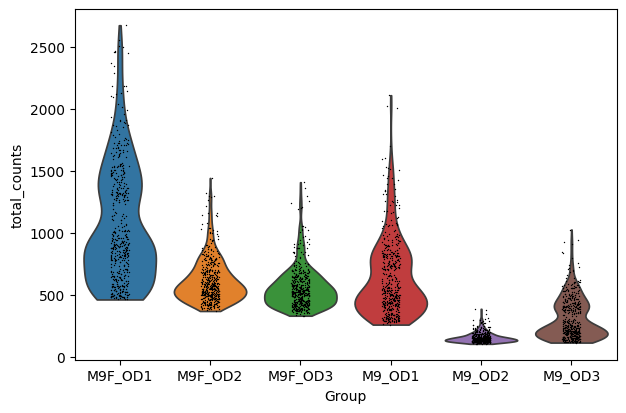

In [ ]:
sc.pl.violin(adata1, ["total_counts"], groupby="Group", multi_panel=True)

<ipython-input-178-266cf97ce455>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-178-266cf97ce455>:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")


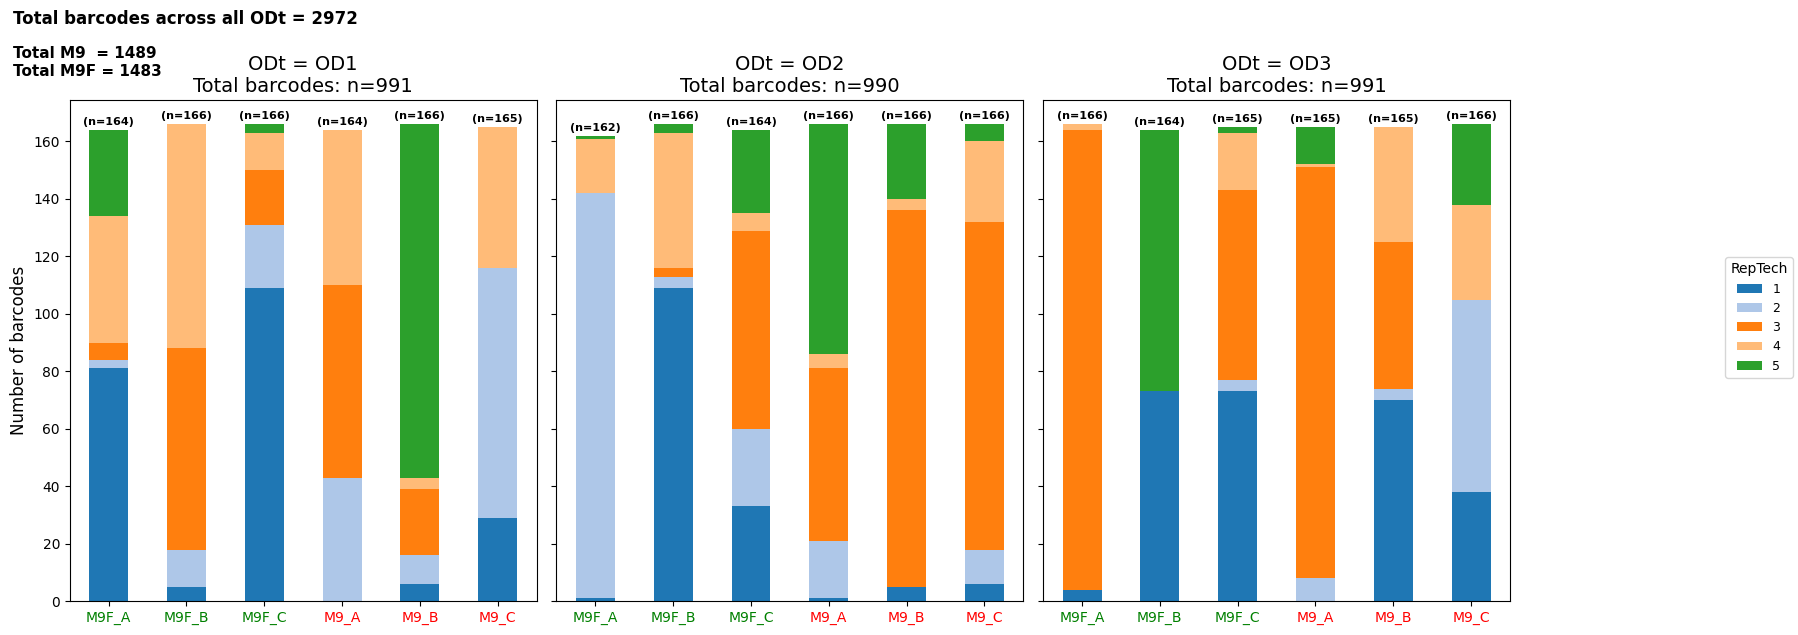

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata1.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Number of barcodes", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

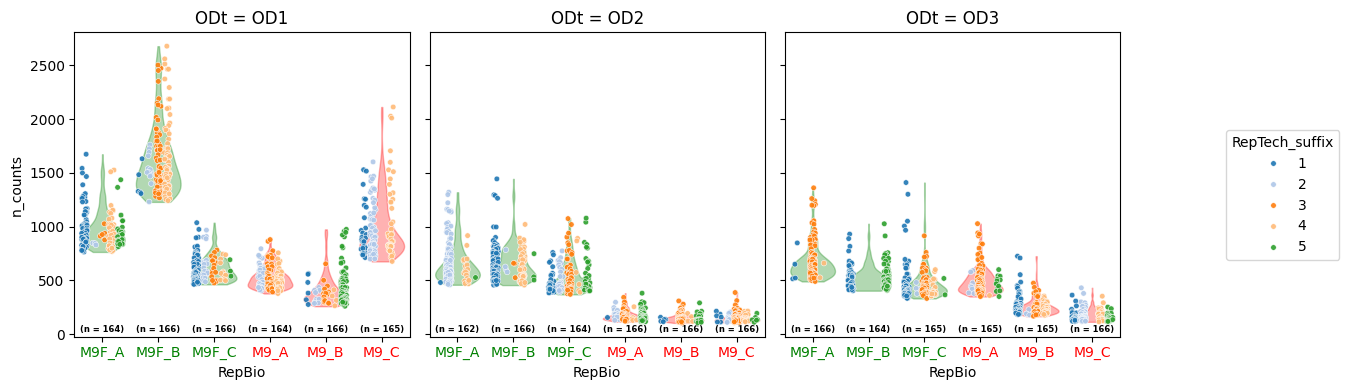

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Preprocessing
df = adata1.obs.copy()
df["n_counts"] = adata1.obs["total_counts"]
df["RepTech_suffix"] = df["RepTech"].astype(str).str.split("_").str[-1]
df["ODt"] = df["ODt"].astype(str)
df["RepBio"] = df["RepBio"].astype(str)
df["RepTech_suffix"] = df["RepTech_suffix"].astype(str)

# Paramètres
col_wrap = 3
repbios = sorted(df["RepBio"].unique())
odts = sorted(df["ODt"].unique())

# Palette tab20 personnalisée dans l'ordre numérique
reptech_suffixes = sorted(df["RepTech_suffix"].unique(), key=lambda x: int(x))
tab20_colors = sns.color_palette("tab20", n_colors=len(reptech_suffixes))
palette = dict(zip(reptech_suffixes, tab20_colors))

# Groupes à colorer
group_vert = ["M9F_A", "M9F_B", "M9F_C"]
group_rouge = ["M9_A", "M9_B", "M9_C"]
repbio_colors = {
    repbio: (
        "green" if repbio in group_vert else "red" if repbio in group_rouge else "gray"
    )
    for repbio in repbios
}

# Setup grid
n_cols = col_wrap
n_rows = int(np.ceil(len(odts) / col_wrap))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, odt in enumerate(odts):
    ax = axes[i]
    data_odt = df[df["ODt"] == odt]

    for j, repbio in enumerate(repbios):
        data_subset = data_odt[data_odt["RepBio"] == repbio]
        values = data_subset["n_counts"].dropna()

        if len(values) < 2:
            continue

        # KDE
        kde = gaussian_kde(values, bw_method=0.3)
        x_vals = np.linspace(values.min(), values.max(), 100)
        density = kde(x_vals)
        width = 0.4
        density = density / density.max() * width

        violin_color = repbio_colors.get(repbio, "gray")

        # Tracé du violon
        ax.fill_betweenx(
            x_vals, j - density, j + density, color=violin_color, alpha=0.3, linewidth=1
        )

        # Affiche n
        ax.text(
            j,
            0.01,
            f"(n = {len(values)})",
            ha="center",
            va="bottom",
            fontsize=6,
            fontweight="bold",
            color="black",
        )

    # Stripplot avec hue_order pour contrôler l'ordre de la légende
    sns.stripplot(
        data=data_odt,
        x="RepBio",
        y="n_counts",
        hue="RepTech_suffix",
        dodge=True,
        jitter=0.25,
        size=4,
        ax=ax,
        alpha=0.9,
        edgecolor="white",
        linewidth=0.4,
        palette=palette,
        order=repbios,
        hue_order=reptech_suffixes,  # Ordre numérique 1 à 5
    )

    if handles is None and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        ax.legend_.remove()

    ax.set_title(f"ODt = {odt}")
    ax.set_xticks(range(len(repbios)))
    ax.set_xticklabels(repbios, rotation=0)

    # Colorer étiquettes x
    for tick_label in ax.get_xticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(repbio_colors.get(label_text, "gray"))

# Supprimer les axes vides
for j in range(len(odts), len(axes)):
    fig.delaxes(axes[j])

# Légende commune dans l'ordre voulu
if handles is not None:
    fig.legend(
        handles,
        labels,
        title="RepTech_suffix",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
    )

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
# filter genes expressed in less than 3 cells
print(f"Number of genes before filtering: {adata1.n_vars:,}")
adata1_genes_filtered = adata1.copy()
sc.pp.filter_genes(adata1_genes_filtered, min_cells=3)
print(f"Number of genes after filtering: {adata1_genes_filtered.n_vars:,}")
# number of genes before and after filtering
n_genes_before_filtering = adata1.n_vars
n_genes_after_filtering = adata1_genes_filtered.n_vars

# number of removed genes
print(f"Number of removed genes: {n_genes_before_filtering - n_genes_after_filtering}")

Number of genes before filtering: 6,099
Number of genes after filtering: 5,670
Number of removed genes: 429


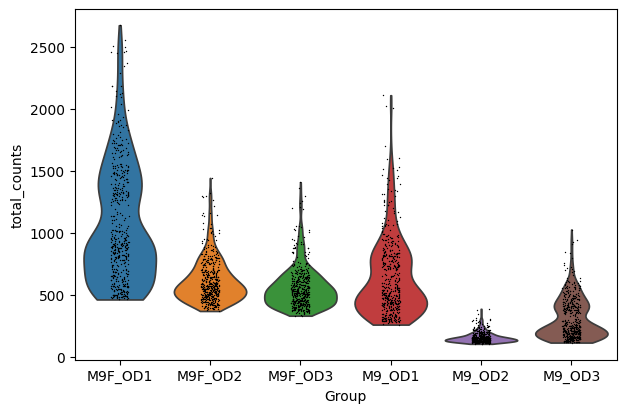

In [ ]:
sc.pl.violin(adata1_genes_filtered, ["total_counts"], groupby="Group", multi_panel=True)

<ipython-input-182-6d6cdd5eda96>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
<ipython-input-182-6d6cdd5eda96>:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")


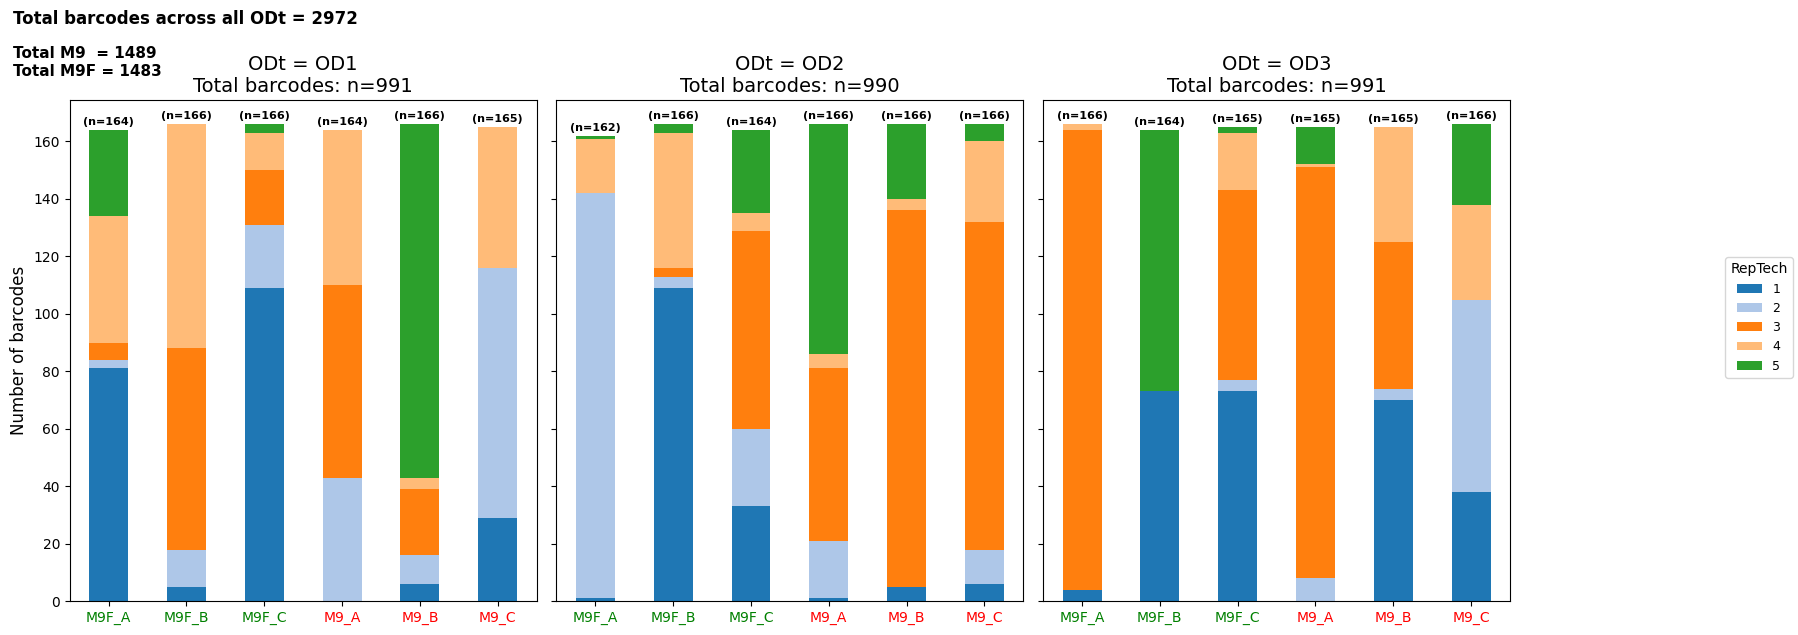

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper les données
counts = (
    adata1_genes_filtered.obs.groupby(["ODt", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Paramètres
odt_values = counts["ODt"].unique()
n = len(odt_values)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, odt in zip(axes, odt_values):
    df_odt = counts[counts["ODt"] == odt]
    pivot_df = df_odt.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    ax.set_title(f"ODt = {odt}\nTotal barcodes: n={int(total_plot)}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Number of barcodes", fontsize=12)

    # Couleur des étiquettes X
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha="center")

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

# Légende globale (sans total global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    fontsize=9,
    title_fontsize=10,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all ODt = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut_no.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage en haut à gauche, sous le total global
fig.text(
    0.01,
    0.99,
    f"Total M9  = {total_by_medium['M9']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)
fig.text(
    0.01,
    0.96,
    f"Total M9F = {total_by_medium['M9F']}",
    ha="left",
    va="top",
    fontsize=11,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
print(adata1_genes_filtered.obs["RepTech"].value_counts())

RepTech
M9F_A_OD3_3    160
M9_A_OD3_3     143
M9F_A_OD2_2    141
M9_B_OD2_3     131
M9_B_OD1_5     123
              ... 
M9F_C_OD3_5      2
M9F_A_OD2_5      1
M9_A_OD3_4       1
M9F_A_OD2_1      1
M9_A_OD2_1       1
Name: count, Length: 75, dtype: int64


In [ ]:
# filter genes expresed in 15 % of the cells
# print(f"📊 Nombre de gènes avant filtrage: {adata1.n_vars:,}")
# sc.pp.filter_genes(adata1, min_cells=0.1 * adata1.n_obs)
# print(f"📊 Nombre de gènes après filtrage: {adata1.n_vars:,}")

In [ ]:
import numpy as np


def mark_and_filter_genes_by_group_annotated(
    adata,
    groupby: str,
    min_pct_cells: float = 0.05,
    annotate_only: bool = True,
    filter_mode: str = None,  # "union", "intersection", ou None
    verbose: bool = True,
):
    """
    Annoter (et éventuellement filtrer) les gènes exprimés dans ≥ `min_pct_cells` des cellules
    pour les groupes définis par `groupby`. Ajoute deux colonnes d'annotation dans `adata.var` :

    - gene_pass_union_<groupby>_<xxpct>
    - gene_pass_intersection_<groupby>_<xxpct>

    Paramètres :
    -----------
    adata : AnnData
        Objet AnnData à annoter.
    groupby : str
        Nom de la colonne de regroupement dans `adata.obs`.
    min_pct_cells : float
        Seuil de pourcentage (ex: 0.05 pour 5%).
    annotate_only : bool
        Si True, ajoute uniquement les colonnes d'annotation.
    filter_mode : str
        "union", "intersection" ou None. Active le filtrage si non None.
    verbose : bool
        Affiche les logs.

    Retour :
    -------
    AnnData annoté (et éventuellement filtré)
    """

    if groupby not in adata.obs.columns:
        raise ValueError(f"🛑 '{groupby}' n'existe pas dans adata.obs.")
    if filter_mode not in [None, "union", "intersection"]:
        raise ValueError("🛑 'filter_mode' doit être None, 'union' ou 'intersection'.")

    is_expressed = adata.X > 0
    n_genes = adata.n_vars
    unique_groups = adata.obs[groupby].unique()
    pct_label = f"{int(min_pct_cells * 100)}pct"
    var_prefix = f"{groupby}_{pct_label}"

    union_mask = np.zeros(n_genes, dtype=bool)
    intersection_mask = np.ones(n_genes, dtype=bool)

    for group in unique_groups:
        mask = adata.obs[groupby] == group
        subset_expr = is_expressed[mask.to_numpy(), :]
        min_cells = int(min_pct_cells * mask.sum())
        genes_ok = np.asarray((subset_expr.sum(axis=0) >= min_cells)).ravel()

        union_mask |= genes_ok
        intersection_mask &= genes_ok

        if verbose:
            print(
                f"🔍 {group}: {genes_ok.sum()} gènes retenus (≥ {min_cells} cellules)"
            )

    # Ajoute les colonnes avec noms explicites
    union_col = f"gene_pass_union_{var_prefix}"
    inter_col = f"gene_pass_intersection_{var_prefix}"

    adata.var[union_col] = union_mask
    adata.var[inter_col] = intersection_mask

    if verbose:
        print(
            f"✅ Union : {union_mask.sum()} gènes — Intersection : {intersection_mask.sum()} gènes"
        )
        print(f"📝 Colonnes ajoutées : {union_col}, {inter_col}")

    if annotate_only:
        return adata

    if filter_mode == "union":
        return adata[:, union_mask].copy()
    elif filter_mode == "intersection":
        return adata[:, intersection_mask].copy()

In [ ]:
# Annoter uniquement (sans filtrer)
adata1 = mark_and_filter_genes_by_group_annotated(
    adata1_genes_filtered, groupby="OD", min_pct_cells=0.05, annotate_only=True
)

adata1 = mark_and_filter_genes_by_group_annotated(
    adata1_genes_filtered, groupby="OD", min_pct_cells=0.10, annotate_only=True
)

adata1 = mark_and_filter_genes_by_group_annotated(
    adata1_genes_filtered, groupby="OD", min_pct_cells=0.15, annotate_only=True
)


# Voir les colonnes ajoutées
adata1.var[
    [
        "gene_pass_union_OD_5pct",
        "gene_pass_intersection_OD_5pct",
        "gene_pass_union_OD_10pct",
        "gene_pass_intersection_OD_10pct",
        "gene_pass_union_OD_15pct",
        "gene_pass_intersection_OD_15pct",
    ]
].head()


# ✂️ Filtrer les gènes qui passent le filtre union
adata_union = mark_and_filter_genes_by_group_annotated(
    adata1_genes_filtered, groupby="OD", filter_mode="union", annotate_only=False
)

# ✂️ Filtrer les gènes qui passent le filtre intersection
adata_inter = mark_and_filter_genes_by_group_annotated(
    adata1_genes_filtered, groupby="OD", filter_mode="intersection", annotate_only=False
)

🔍 M9F_A_OD1: 2657 gènes retenus (≥ 8 cellules)
🔍 M9F_A_OD2: 2038 gènes retenus (≥ 8 cellules)
🔍 M9F_A_OD3: 2128 gènes retenus (≥ 8 cellules)
🔍 M9F_B_OD1: 3445 gènes retenus (≥ 8 cellules)
🔍 M9F_B_OD2: 2076 gènes retenus (≥ 8 cellules)
🔍 M9F_B_OD3: 1794 gènes retenus (≥ 8 cellules)
🔍 M9F_C_OD1: 2017 gènes retenus (≥ 8 cellules)
🔍 M9F_C_OD2: 1832 gènes retenus (≥ 8 cellules)
🔍 M9F_C_OD3: 1675 gènes retenus (≥ 8 cellules)
🔍 M9_A_OD1: 1800 gènes retenus (≥ 8 cellules)
🔍 M9_A_OD2: 747 gènes retenus (≥ 8 cellules)
🔍 M9_A_OD3: 1722 gènes retenus (≥ 8 cellules)
🔍 M9_B_OD1: 1515 gènes retenus (≥ 8 cellules)
🔍 M9_B_OD2: 677 gènes retenus (≥ 8 cellules)
🔍 M9_B_OD3: 1081 gènes retenus (≥ 8 cellules)
🔍 M9_C_OD1: 2673 gènes retenus (≥ 8 cellules)
🔍 M9_C_OD2: 675 gènes retenus (≥ 8 cellules)
🔍 M9_C_OD3: 751 gènes retenus (≥ 8 cellules)
✅ Union : 3586 gènes — Intersection : 483 gènes
📝 Colonnes ajoutées : gene_pass_union_OD_5pct, gene_pass_intersection_OD_5pct
🔍 M9F_A_OD1: 1619 gènes retenus (≥ 16 cel

In [ ]:
# Voir les colonnes ajoutées
adata1.var[["gene_pass_union_OD_5pct", "gene_pass_intersection_OD_5pct"]].head()

,gene_pass_union_OD_5pct,gene_pass_intersection_OD_5pct
gene_id,,
QLH64-00030,True,False
QLH64-00035,True,False
QLH64-00040,True,False
QLH64-00045,False,False
QLH64-00050,True,False


In [ ]:
adata1.var["gene_pass_union_OD_5pct"].value_counts()

gene_pass_union_OD_5pct
True     3586
False    2084
Name: count, dtype: int64

In [ ]:
adata1.var["gene_pass_union_OD_10pct"].value_counts()

gene_pass_union_OD_10pct
False    3344
True     2326
Name: count, dtype: int64

In [ ]:
adata1.var["gene_pass_union_OD_15pct"].value_counts()

gene_pass_union_OD_15pct
False    3962
True     1708
Name: count, dtype: int64

In [ ]:
adata1.var["gene_pass_intersection_OD_5pct"].value_counts()
adata1.var["gene_pass_intersection_OD_10pct"].value_counts()
adata1.var["gene_pass_intersection_OD_15pct"].value_counts()

gene_pass_intersection_OD_15pct
False    5513
True      157
Name: count, dtype: int64

In [ ]:
adata1.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,gene_pass_union_OD_5pct,gene_pass_intersection_OD_5pct,gene_pass_union_OD_10pct,gene_pass_intersection_OD_10pct,gene_pass_union_OD_15pct,gene_pass_intersection_OD_15pct
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00030,gene-QLH64_00030,QLH64-00030,Gene Expression,CP125961.1,5894,9346,unknown,plus,exodeoxyribonuclease V subunit gamma,recC,...,94.751009,161,5.087596,156,True,False,True,False,False,False
QLH64-00035,gene-QLH64_00035,QLH64-00035,Gene Expression,CP125961.1,9343,13032,unknown,plus,exodeoxyribonuclease V subunit beta,recB,...,95.995962,122,4.812184,119,True,False,True,False,False,False
QLH64-00040,gene-QLH64_00040,QLH64-00040,Gene Expression,CP125961.1,13029,15125,unknown,plus,exodeoxyribonuclease V subunit alpha,recD,...,96.332436,114,4.744932,109,True,False,True,False,False,False
QLH64-00045,gene-QLH64_00045,QLH64-00045,Gene Expression,CP125961.1,15265,15840,chromosome,plus,YfiR family protein,NaN,...,98.048452,58,4.077537,58,False,False,False,False,False,False
QLH64-00050,gene-QLH64_00050,QLH64-00050,Gene Expression,CP125961.1,15837,17105,chromosome,plus,diguanylate cyclase,NaN,...,98.519515,45,3.828641,44,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,96.702557,104,4.653960,98,True,False,True,False,False,False
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,98.048452,60,4.110874,58,True,False,False,False,False,False
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,98.855989,34,3.555348,34,False,False,False,False,False,False


In [ ]:
adata1.n_obs

2972

In [ ]:
adata1.n_vars

5670

In [ ]:
adata1.var

,feature_id,gene_id,feature_type,Accession,Begin,End,Chromosome,Orientation,Name,Symbol,...,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,gene_pass_union_OD_5pct,gene_pass_intersection_OD_5pct,gene_pass_union_OD_10pct,gene_pass_intersection_OD_10pct,gene_pass_union_OD_15pct,gene_pass_intersection_OD_15pct
gene_id,,,,,,,,,,,,,,,,,,,,,
QLH64-00030,gene-QLH64_00030,QLH64-00030,Gene Expression,CP125961.1,5894,9346,unknown,plus,exodeoxyribonuclease V subunit gamma,recC,...,94.751009,161,5.087596,156,True,False,True,False,False,False
QLH64-00035,gene-QLH64_00035,QLH64-00035,Gene Expression,CP125961.1,9343,13032,unknown,plus,exodeoxyribonuclease V subunit beta,recB,...,95.995962,122,4.812184,119,True,False,True,False,False,False
QLH64-00040,gene-QLH64_00040,QLH64-00040,Gene Expression,CP125961.1,13029,15125,unknown,plus,exodeoxyribonuclease V subunit alpha,recD,...,96.332436,114,4.744932,109,True,False,True,False,False,False
QLH64-00045,gene-QLH64_00045,QLH64-00045,Gene Expression,CP125961.1,15265,15840,chromosome,plus,YfiR family protein,NaN,...,98.048452,58,4.077537,58,False,False,False,False,False,False
QLH64-00050,gene-QLH64_00050,QLH64-00050,Gene Expression,CP125961.1,15837,17105,chromosome,plus,diguanylate cyclase,NaN,...,98.519515,45,3.828641,44,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QLH64-31225,gene-QLH64_31225,QLH64-31225,Gene Expression,CP125962.1,295284,295577,plasmid,minus,hypothetical protein,NaN,...,96.702557,104,4.653960,98,True,False,True,False,False,False
QLH64-31230,gene-QLH64_31230,QLH64-31230,Gene Expression,CP125962.1,295561,296616,unknown,minus,recombinase RecA,recA_2,...,98.048452,60,4.110874,58,True,False,False,False,False,False
QLH64-31235,gene-QLH64_31235,QLH64-31235,Gene Expression,CP125962.1,296791,297501,plasmid,plus,helix-hairpin-helix domain-containing protein,NaN,...,98.855989,34,3.555348,34,False,False,False,False,False,False


In [ ]:
adata1.write_h5ad("data/anndata_objects_with_gene_metadata/final_adata_filtered.h5ad")

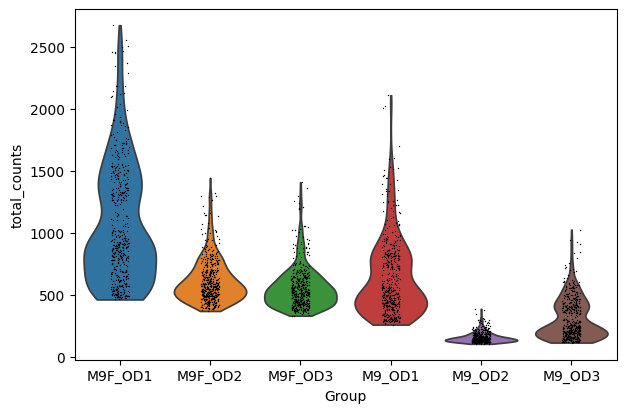

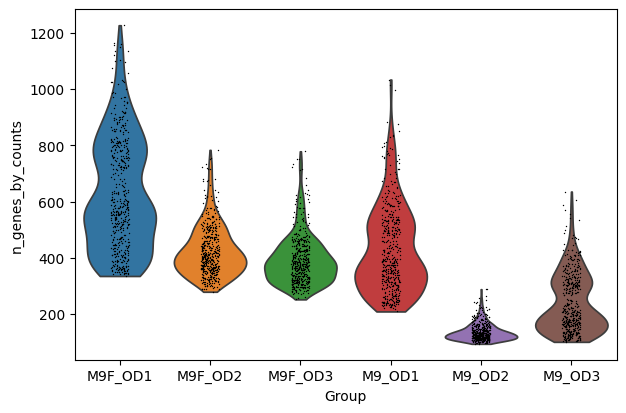

In [ ]:
sc.pl.violin(adata1, ["total_counts"], groupby="Group")
sc.pl.violin(adata1, ["n_genes_by_counts"], groupby="Group")

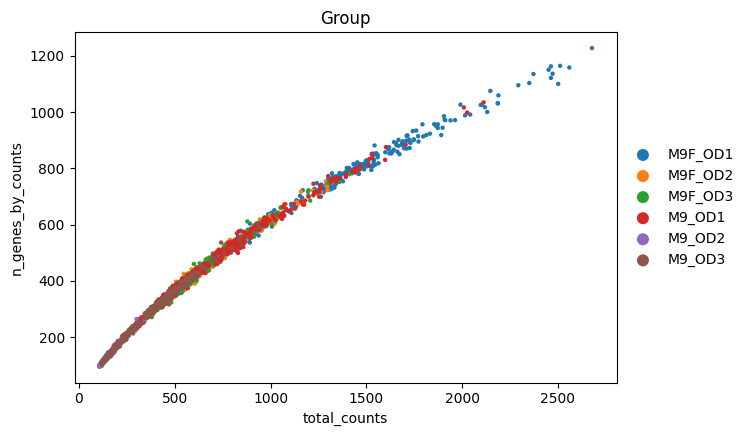

In [ ]:
sc.pl.scatter(adata1, "total_counts", "n_genes_by_counts", color="Group")

<ipython-input-199-9b90e9417499>:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut.obs.groupby(["group", "RepBio", "RepTech_suffix"])
<ipython-input-199-9b90e9417499>:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_fcell_100UMI_noOut.obs.groupby("CultureMedium")


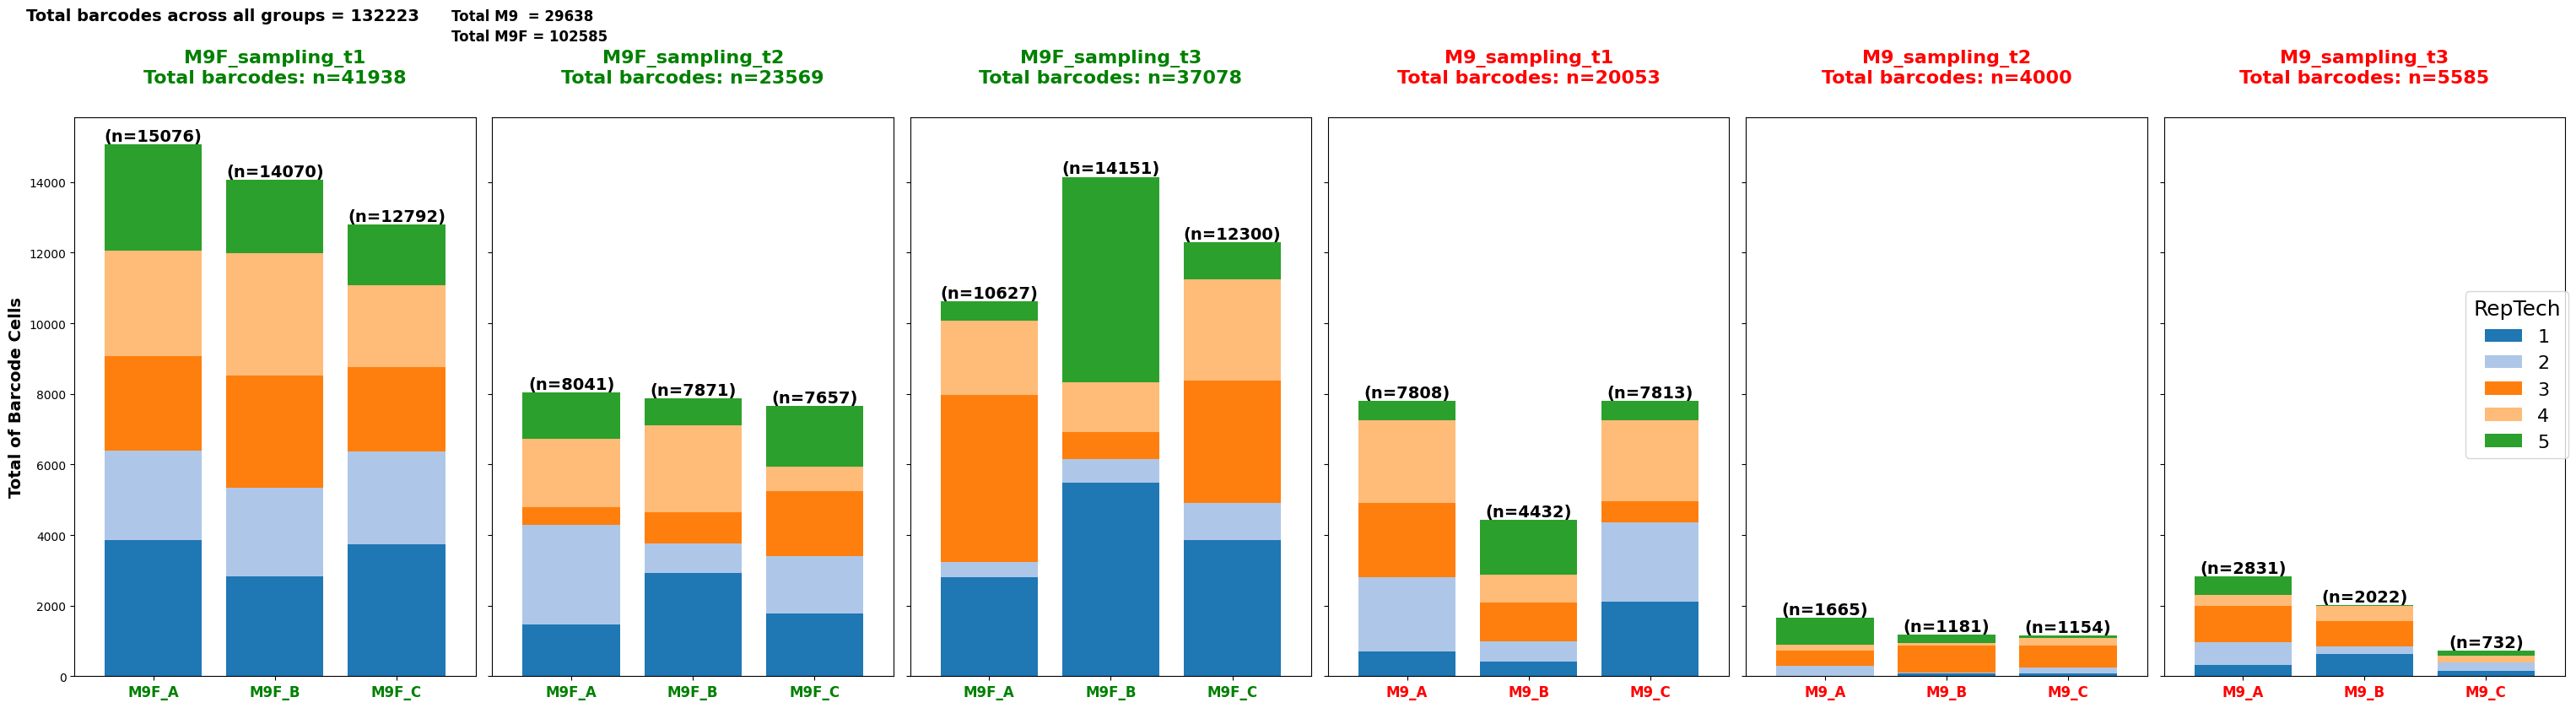

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


adata_fcell_100UMI_noOut.obs["group"] = adata_fcell_100UMI_noOut.obs.apply(
    assign_group, axis=1
)

# Grouper les données par la nouvelle colonne 'group', RepBio et RepTech_suffix
counts = (
    adata_fcell_100UMI_noOut.obs.groupby(["group", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Obtenir la liste des groupes (panels)
group_labels = sorted(counts["group"].unique())
n = len(group_labels)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 8), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, group in zip(axes, group_labels):
    df_group = counts[counts["group"] == group]

    # Extraire culture_medium (M9 ou M9F) et temps
    culture_medium = group.split("_")[0]  # M9 ou M9F
    sampling_time = group.split("_")[1]  # sampling_t1, sampling_t2, sampling_t3

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    df_group = df_group[df_group["RepBio"].isin(expected_repbios)]

    # Pivot pour format barres empilées
    pivot_df = df_group.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)

    # Réorganiser les colonnes dans l'ordre attendu
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    # Réorganiser les lignes dans l'ordre attendu
    if culture_medium == "M9":
        pivot_df = pivot_df.reindex(index=["M9_A", "M9_B", "M9_C"], fill_value=0)
    elif culture_medium == "M9F":
        pivot_df = pivot_df.reindex(index=["M9F_A", "M9F_B", "M9F_C"], fill_value=0)

    # Plot empilé
    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
        width=0.8,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}\nTotal barcodes: n={int(total_plot)}",
        fontsize=16,
        fontweight="bold",
        color=title_color,
        pad=20,
        y=1.02,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=14, fontweight="bold")

    # Couleur des étiquettes X : vert si M9F, rouge si M9
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(
        xtick_labels, rotation=0, ha="center", fontsize=12, fontweight="bold"
    )

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # Affichage des counts (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold",
        )

# Légende globale
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    bbox_to_anchor=(0.85, 0.5),
    fontsize=16,
    title_fontsize=18,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all groups = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata_fcell_100UMI_noOut.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage juste à droite du total global
fig.text(
    0.15,
    1.02,
    f"Total M9  = {total_by_medium.get('M9', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
fig.text(
    0.15,
    0.99,
    f"Total M9F = {total_by_medium.get('M9F', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

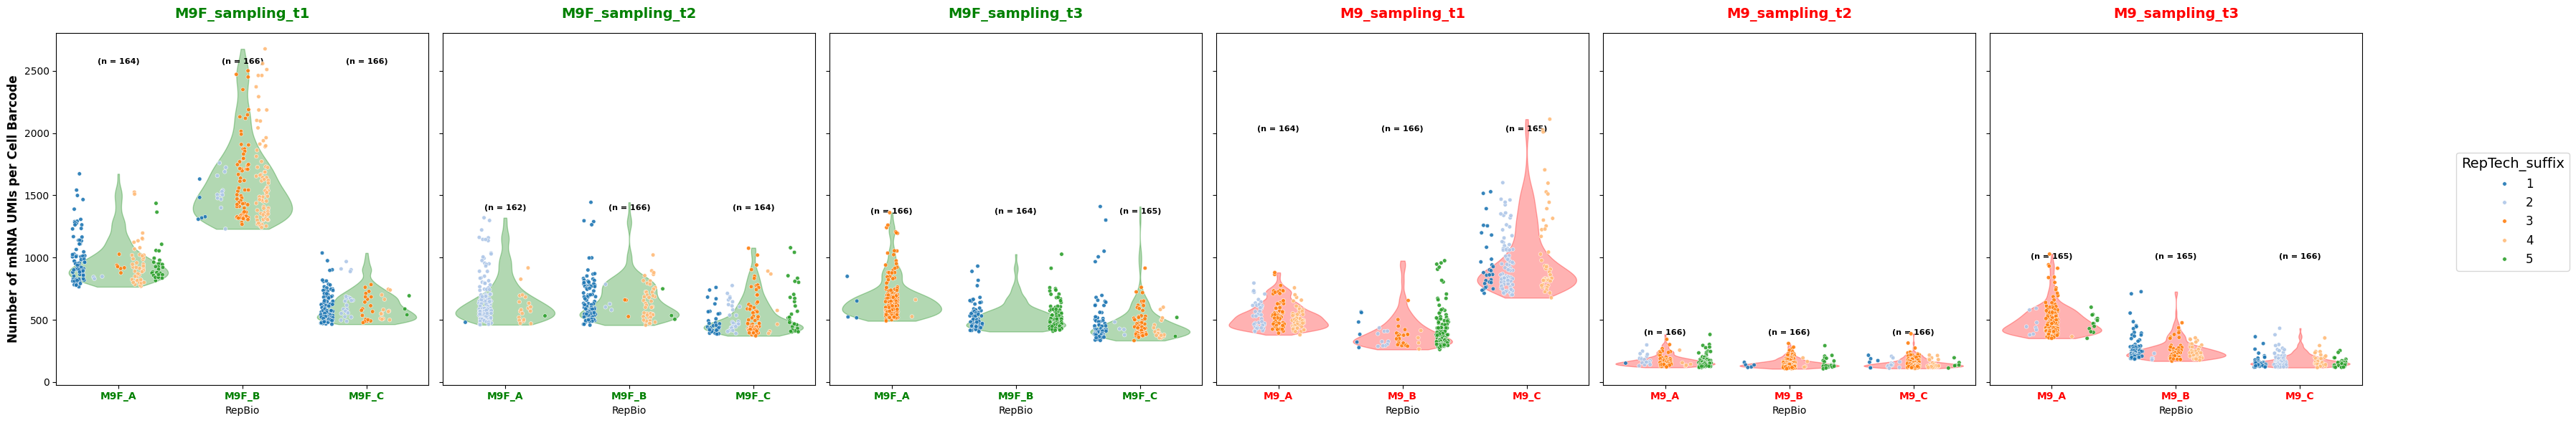

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Preprocessing
df = adata1_genes_filtered.obs.copy()
df["n_counts"] = adata1_genes_filtered.obs["total_counts"]
df["RepTech_suffix"] = df["RepTech"].astype(str).str.split("_").str[-1]
df["ODt"] = df["ODt"].astype(str)
df["RepBio"] = df["RepBio"].astype(str)
df["RepTech_suffix"] = df["RepTech_suffix"].astype(str)


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


df["group"] = df.apply(assign_group, axis=1)

# Paramètres
group_labels = sorted(df["group"].unique())
n = len(group_labels)

repbios = sorted(df["RepBio"].unique())

# Palette tab20 personnalisée dans l'ordre numérique
reptech_suffixes = sorted(df["RepTech_suffix"].unique(), key=lambda x: int(x))
tab20_colors = sns.color_palette("tab20", n_colors=len(reptech_suffixes))
palette = dict(zip(reptech_suffixes, tab20_colors))

# Groupes à colorer
group_vert = ["M9F_A", "M9F_B", "M9F_C"]
group_rouge = ["M9_A", "M9_B", "M9_C"]
repbio_colors = {
    repbio: (
        "green" if repbio in group_vert else "red" if repbio in group_rouge else "gray"
    )
    for repbio in repbios
}

# Setup grid - une ligne avec toutes les facettes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)
if n == 1:
    axes = [axes]

handles, labels = None, None

for i, group in enumerate(group_labels):
    ax = axes[i]
    data_group = df[df["group"] == group]

    # Extraire culture_medium (M9 ou M9F) pour définir les RepBio attendus
    culture_medium = group.split("_")[0]  # M9 ou M9F

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    data_group = data_group[data_group["RepBio"].isin(expected_repbios)]

    for j, repbio in enumerate(expected_repbios):
        data_subset = data_group[data_group["RepBio"] == repbio]
        values = data_subset["n_counts"].dropna()

        if len(values) < 2:
            continue

        # KDE
        kde = gaussian_kde(values, bw_method=0.3)
        x_vals = np.linspace(values.min(), values.max(), 100)
        density = kde(x_vals)
        width = 0.4
        density = density / density.max() * width

        violin_color = repbio_colors.get(repbio, "gray")

        # Tracé du violon
        ax.fill_betweenx(
            x_vals, j - density, j + density, color=violin_color, alpha=0.3, linewidth=1
        )

        # Affiche n
        ax.text(
            j,
            data_group["n_counts"].max() * 0.95,
            f"(n = {len(values)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
            color="black",
        )

    # Stripplot avec hue_order pour contrôler l'ordre de la légende
    sns.stripplot(
        data=data_group,
        x="RepBio",
        y="n_counts",
        hue="RepTech_suffix",
        dodge=True,
        jitter=0.25,
        size=4,
        ax=ax,
        alpha=0.9,
        edgecolor="white",
        linewidth=0.4,
        palette=palette,
        order=expected_repbios,
        hue_order=reptech_suffixes,  # Ordre numérique 1 à 5
    )

    if handles is None and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        ax.legend_.remove()

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}",
        fontsize=14,
        fontweight="bold",
        color=title_color,
        pad=15,
    )
    ax.set_xticks(range(len(expected_repbios)))
    ax.set_xticklabels(expected_repbios, rotation=0, fontsize=10, fontweight="bold")
    ax.set_ylabel(
        "Number of mRNA UMIs per Cell Barcode", fontsize=12, fontweight="bold"
    )

    # Colorer étiquettes x
    for tick_label in ax.get_xticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(repbio_colors.get(label_text, "gray"))

# Légende commune dans l'ordre voulu
if handles is not None:
    fig.legend(
        handles,
        labels,
        title="RepTech_suffix",
        loc="center left",
        bbox_to_anchor=(0.95, 0.5),
        fontsize=12,
        title_fontsize=14,
    )

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()

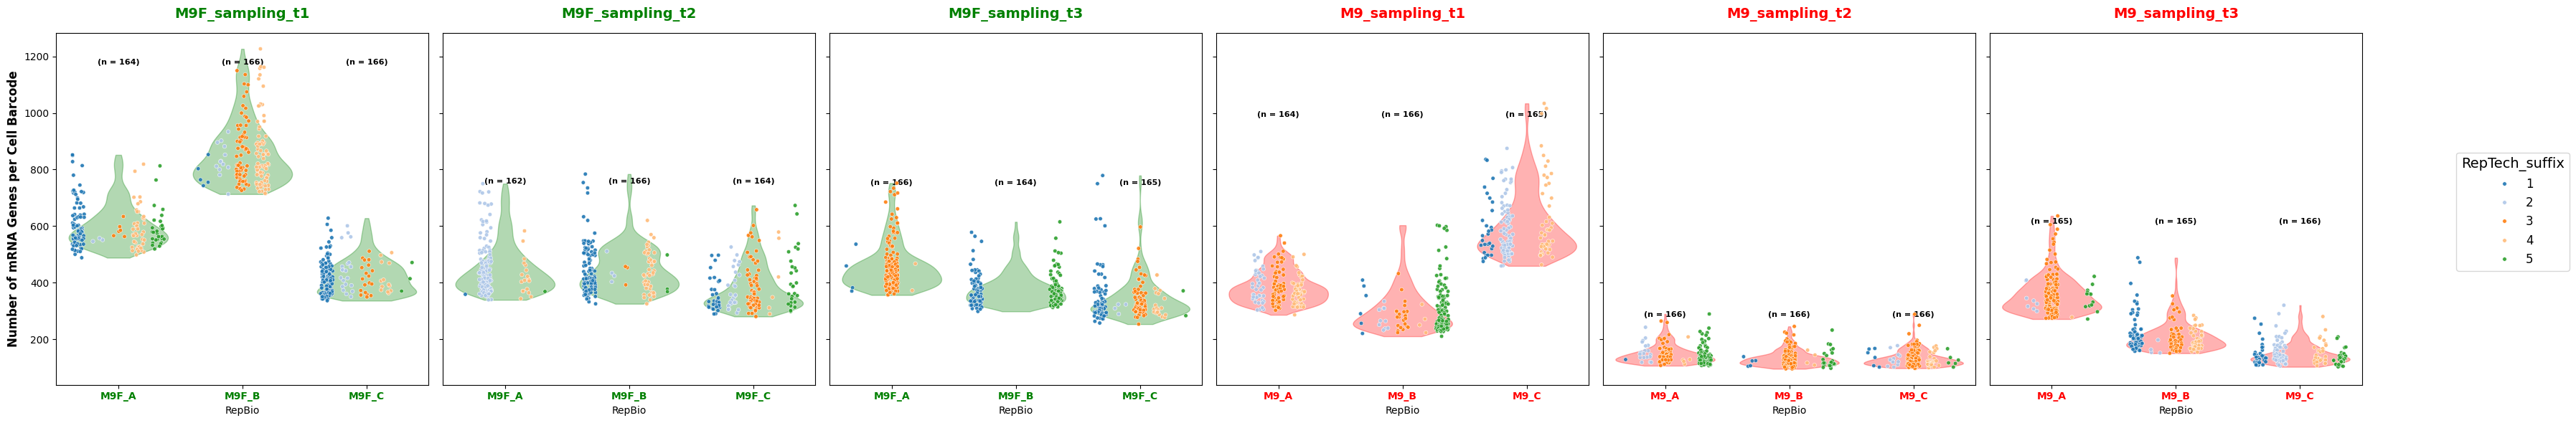

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Preprocessing
df = adata1_genes_filtered.obs.copy()
df["n_genes_by_counts"] = adata1_genes_filtered.obs["n_genes_by_counts"]
df["RepTech_suffix"] = df["RepTech"].astype(str).str.split("_").str[-1]
df["ODt"] = df["ODt"].astype(str)
df["RepBio"] = df["RepBio"].astype(str)
df["RepTech_suffix"] = df["RepTech_suffix"].astype(str)


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


df["group"] = df.apply(assign_group, axis=1)

# Paramètres
group_labels = sorted(df["group"].unique())
n = len(group_labels)

repbios = sorted(df["RepBio"].unique())

# Palette tab20 personnalisée dans l'ordre numérique
reptech_suffixes = sorted(df["RepTech_suffix"].unique(), key=lambda x: int(x))
tab20_colors = sns.color_palette("tab20", n_colors=len(reptech_suffixes))
palette = dict(zip(reptech_suffixes, tab20_colors))

# Groupes à colorer
group_vert = ["M9F_A", "M9F_B", "M9F_C"]
group_rouge = ["M9_A", "M9_B", "M9_C"]
repbio_colors = {
    repbio: (
        "green" if repbio in group_vert else "red" if repbio in group_rouge else "gray"
    )
    for repbio in repbios
}

# Setup grid - une ligne avec toutes les facettes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)
if n == 1:
    axes = [axes]

handles, labels = None, None

for i, group in enumerate(group_labels):
    ax = axes[i]
    data_group = df[df["group"] == group]

    # Extraire culture_medium (M9 ou M9F) pour définir les RepBio attendus
    culture_medium = group.split("_")[0]  # M9 ou M9F

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    data_group = data_group[data_group["RepBio"].isin(expected_repbios)]

    for j, repbio in enumerate(expected_repbios):
        data_subset = data_group[data_group["RepBio"] == repbio]
        values = data_subset["n_genes_by_counts"].dropna()

        if len(values) < 2:
            continue

        # KDE
        kde = gaussian_kde(values, bw_method=0.3)
        x_vals = np.linspace(values.min(), values.max(), 100)
        density = kde(x_vals)
        width = 0.4
        density = density / density.max() * width

        violin_color = repbio_colors.get(repbio, "gray")

        # Tracé du violon
        ax.fill_betweenx(
            x_vals, j - density, j + density, color=violin_color, alpha=0.3, linewidth=1
        )

        # Affiche n
        ax.text(
            j,
            data_group["n_genes_by_counts"].max() * 0.95,
            f"(n = {len(values)})",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
            color="black",
        )

    # Stripplot avec hue_order pour contrôler l'ordre de la légende
    sns.stripplot(
        data=data_group,
        x="RepBio",
        y="n_genes_by_counts",
        hue="RepTech_suffix",
        dodge=True,
        jitter=0.25,
        size=4,
        ax=ax,
        alpha=0.9,
        edgecolor="white",
        linewidth=0.4,
        palette=palette,
        order=expected_repbios,
        hue_order=reptech_suffixes,  # Ordre numérique 1 à 5
    )

    if handles is None and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        ax.legend_.remove()

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}",
        fontsize=14,
        fontweight="bold",
        color=title_color,
        pad=15,
    )
    ax.set_xticks(range(len(expected_repbios)))
    ax.set_xticklabels(expected_repbios, rotation=0, fontsize=10, fontweight="bold")
    ax.set_ylabel(
        "Number of mRNA Genes per Cell Barcode", fontsize=12, fontweight="bold"
    )

    # Colorer étiquettes x
    for tick_label in ax.get_xticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(repbio_colors.get(label_text, "gray"))

# Légende commune dans l'ordre voulu
if handles is not None:
    fig.legend(
        handles,
        labels,
        title="RepTech_suffix",
        loc="center left",
        bbox_to_anchor=(0.95, 0.5),
        fontsize=12,
        title_fontsize=14,
    )

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()

<ipython-input-202-b6ad0644e8ae>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
<ipython-input-202-b6ad0644e8ae>:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby("CultureMedium")


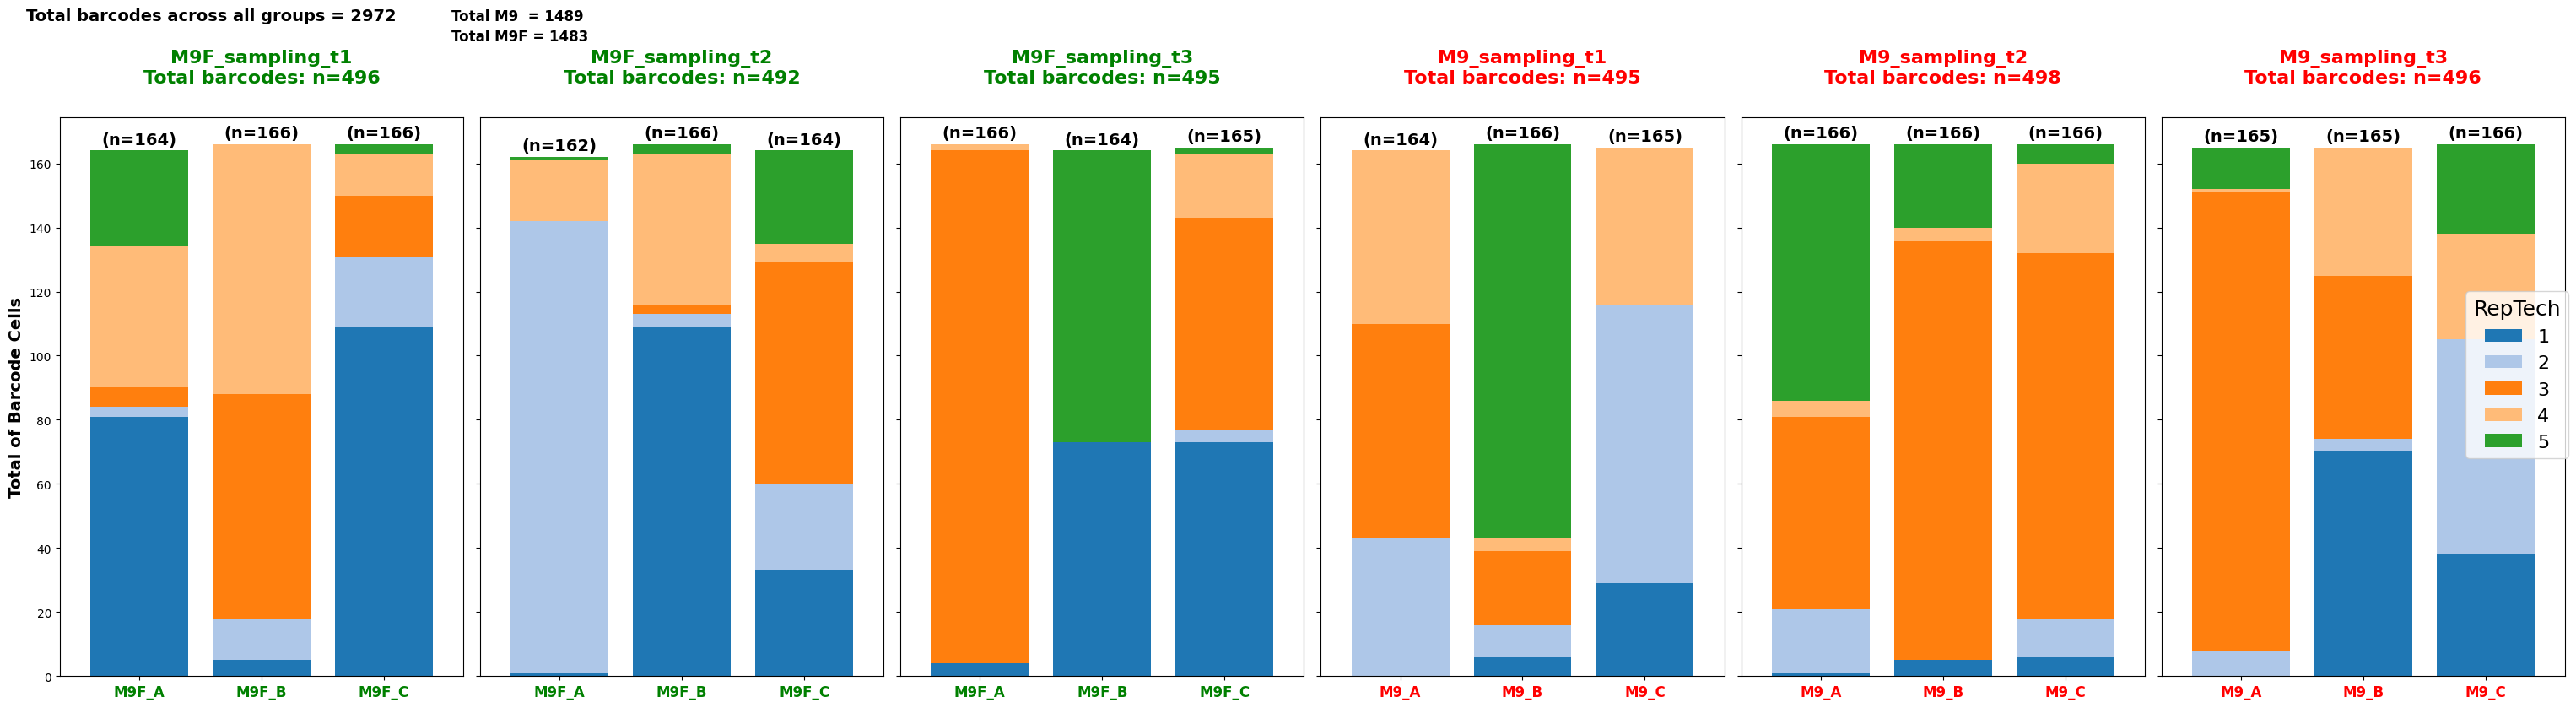

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


adata1_genes_filtered.obs["group"] = adata1_genes_filtered.obs.apply(
    assign_group, axis=1
)

# Grouper les données par la nouvelle colonne 'group', RepBio et RepTech_suffix
counts = (
    adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Obtenir la liste des groupes (panels)
group_labels = sorted(counts["group"].unique())
n = len(group_labels)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 8), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, group in zip(axes, group_labels):
    df_group = counts[counts["group"] == group]

    # Extraire culture_medium (M9 ou M9F) et temps
    culture_medium = group.split("_")[0]  # M9 ou M9F
    sampling_time = group.split("_")[1]  # sampling_t1, sampling_t2, sampling_t3

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    df_group = df_group[df_group["RepBio"].isin(expected_repbios)]

    # Pivot pour format barres empilées
    pivot_df = df_group.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)

    # Réorganiser les colonnes dans l'ordre attendu
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    # Réorganiser les lignes dans l'ordre attendu
    if culture_medium == "M9":
        pivot_df = pivot_df.reindex(index=["M9_A", "M9_B", "M9_C"], fill_value=0)
    elif culture_medium == "M9F":
        pivot_df = pivot_df.reindex(index=["M9F_A", "M9F_B", "M9F_C"], fill_value=0)

    # Plot empilé
    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
        width=0.8,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}\nTotal barcodes: n={int(total_plot)}",
        fontsize=16,
        fontweight="bold",
        color=title_color,
        pad=20,
        y=1.02,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=14, fontweight="bold")

    # Couleur des étiquettes X : vert si M9F, rouge si M9
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(
        xtick_labels, rotation=0, ha="center", fontsize=12, fontweight="bold"
    )

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # Affichage des counts (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold",
        )

# Légende globale
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    bbox_to_anchor=(0.85, 0.5),
    fontsize=16,
    title_fontsize=18,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all groups = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata1_genes_filtered.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage juste à droite du total global
fig.text(
    0.15,
    1.02,
    f"Total M9  = {total_by_medium.get('M9', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
fig.text(
    0.15,
    0.99,
    f"Total M9F = {total_by_medium.get('M9F', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

<ipython-input-203-c5d8090fcb15>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
<ipython-input-203-c5d8090fcb15>:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby("CultureMedium")


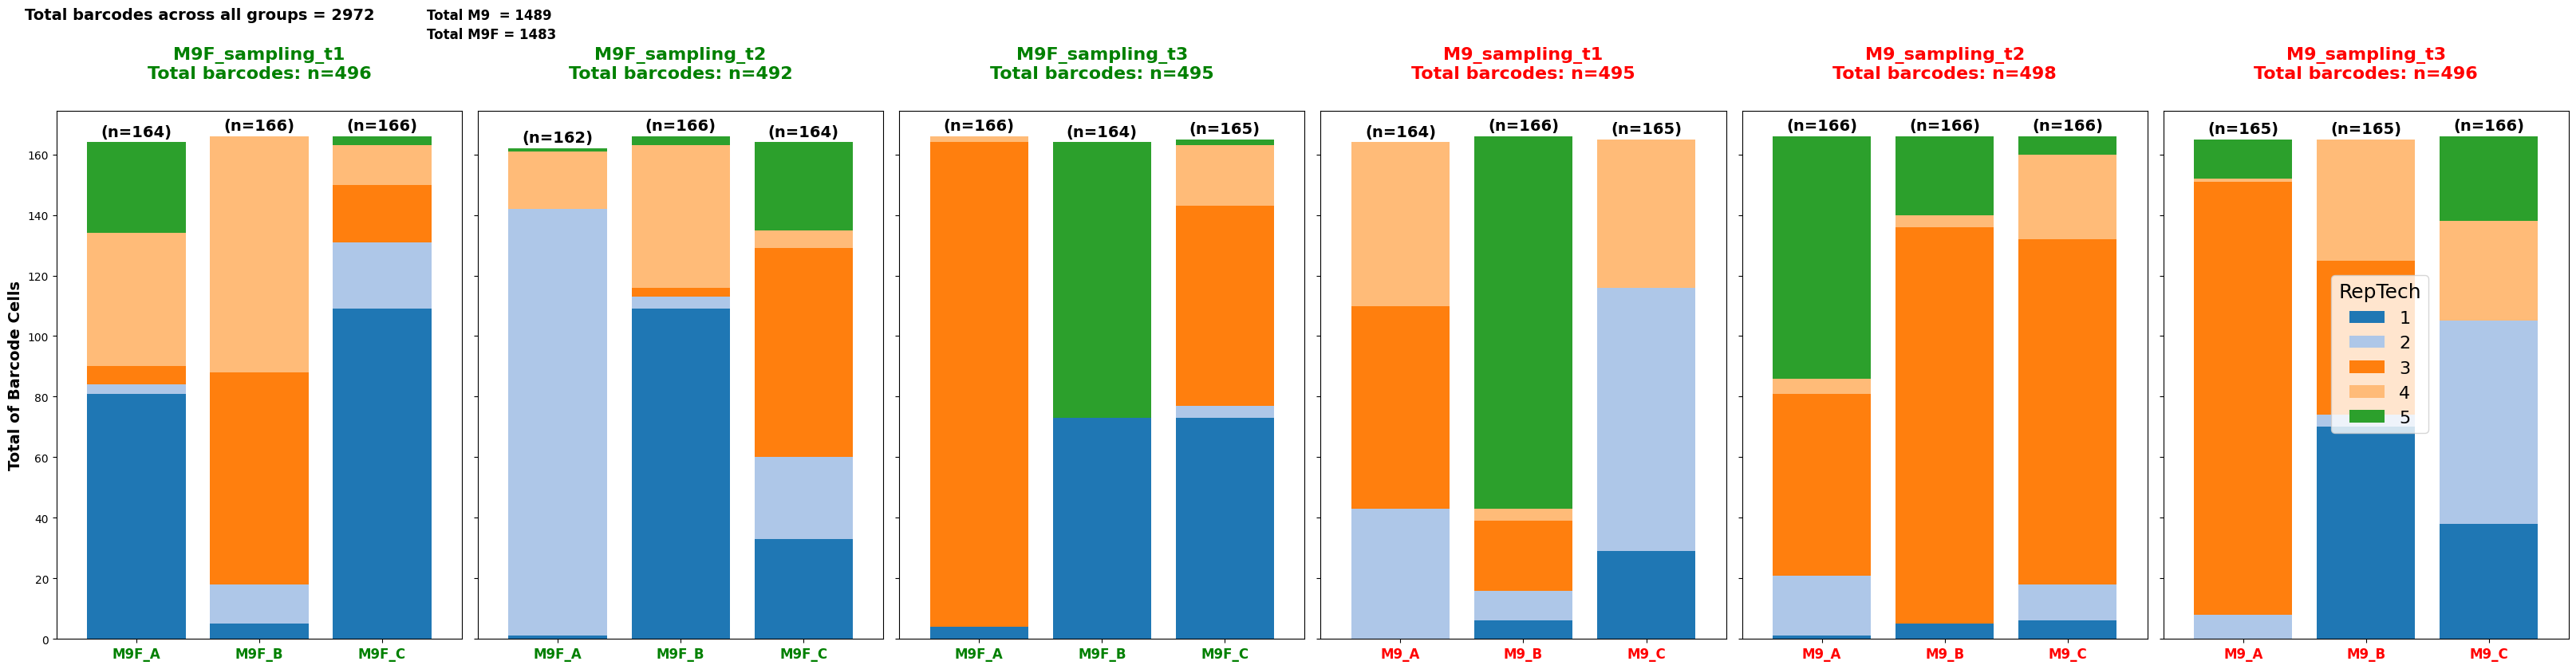

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


adata1_genes_filtered.obs["group"] = adata1_genes_filtered.obs.apply(
    assign_group, axis=1
)

# Grouper les données par la nouvelle colonne 'group', RepBio et RepTech_suffix
counts = (
    adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Obtenir la liste des groupes (panels)
group_labels = sorted(counts["group"].unique())
n = len(group_labels)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 8), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, group in zip(axes, group_labels):
    df_group = counts[counts["group"] == group]

    # Extraire culture_medium (M9 ou M9F) et temps
    culture_medium = group.split("_")[0]  # M9 ou M9F
    sampling_time = group.split("_")[1]  # sampling_t1, sampling_t2, sampling_t3

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    df_group = df_group[df_group["RepBio"].isin(expected_repbios)]

    # Pivot pour format barres empilées
    pivot_df = df_group.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)

    # Réorganiser les colonnes dans l'ordre attendu
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    # Réorganiser les lignes dans l'ordre attendu
    if culture_medium == "M9":
        pivot_df = pivot_df.reindex(index=["M9_A", "M9_B", "M9_C"], fill_value=0)
    elif culture_medium == "M9F":
        pivot_df = pivot_df.reindex(index=["M9F_A", "M9F_B", "M9F_C"], fill_value=0)

    # Plot empilé
    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
        width=0.8,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}\nTotal barcodes: n={int(total_plot)}",
        fontsize=16,
        fontweight="bold",
        color=title_color,
        pad=20,
        y=1.02,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=14, fontweight="bold")

    # Couleur des étiquettes X : vert si M9F, rouge si M9
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(
        xtick_labels, rotation=0, ha="center", fontsize=12, fontweight="bold"
    )

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # Affichage des counts (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold",
        )

# Légende globale
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    bbox_to_anchor=(0.85, 0.5),
    fontsize=16,
    title_fontsize=18,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all groups = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata1_genes_filtered.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage juste à droite du total global
fig.text(
    0.15,
    1.02,
    f"Total M9  = {total_by_medium.get('M9', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
fig.text(
    0.15,
    0.99,
    f"Total M9F = {total_by_medium.get('M9F', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.90, 1])
plt.show()

<ipython-input-204-c1f3582b204f>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
<ipython-input-204-c1f3582b204f>:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby("CultureMedium")


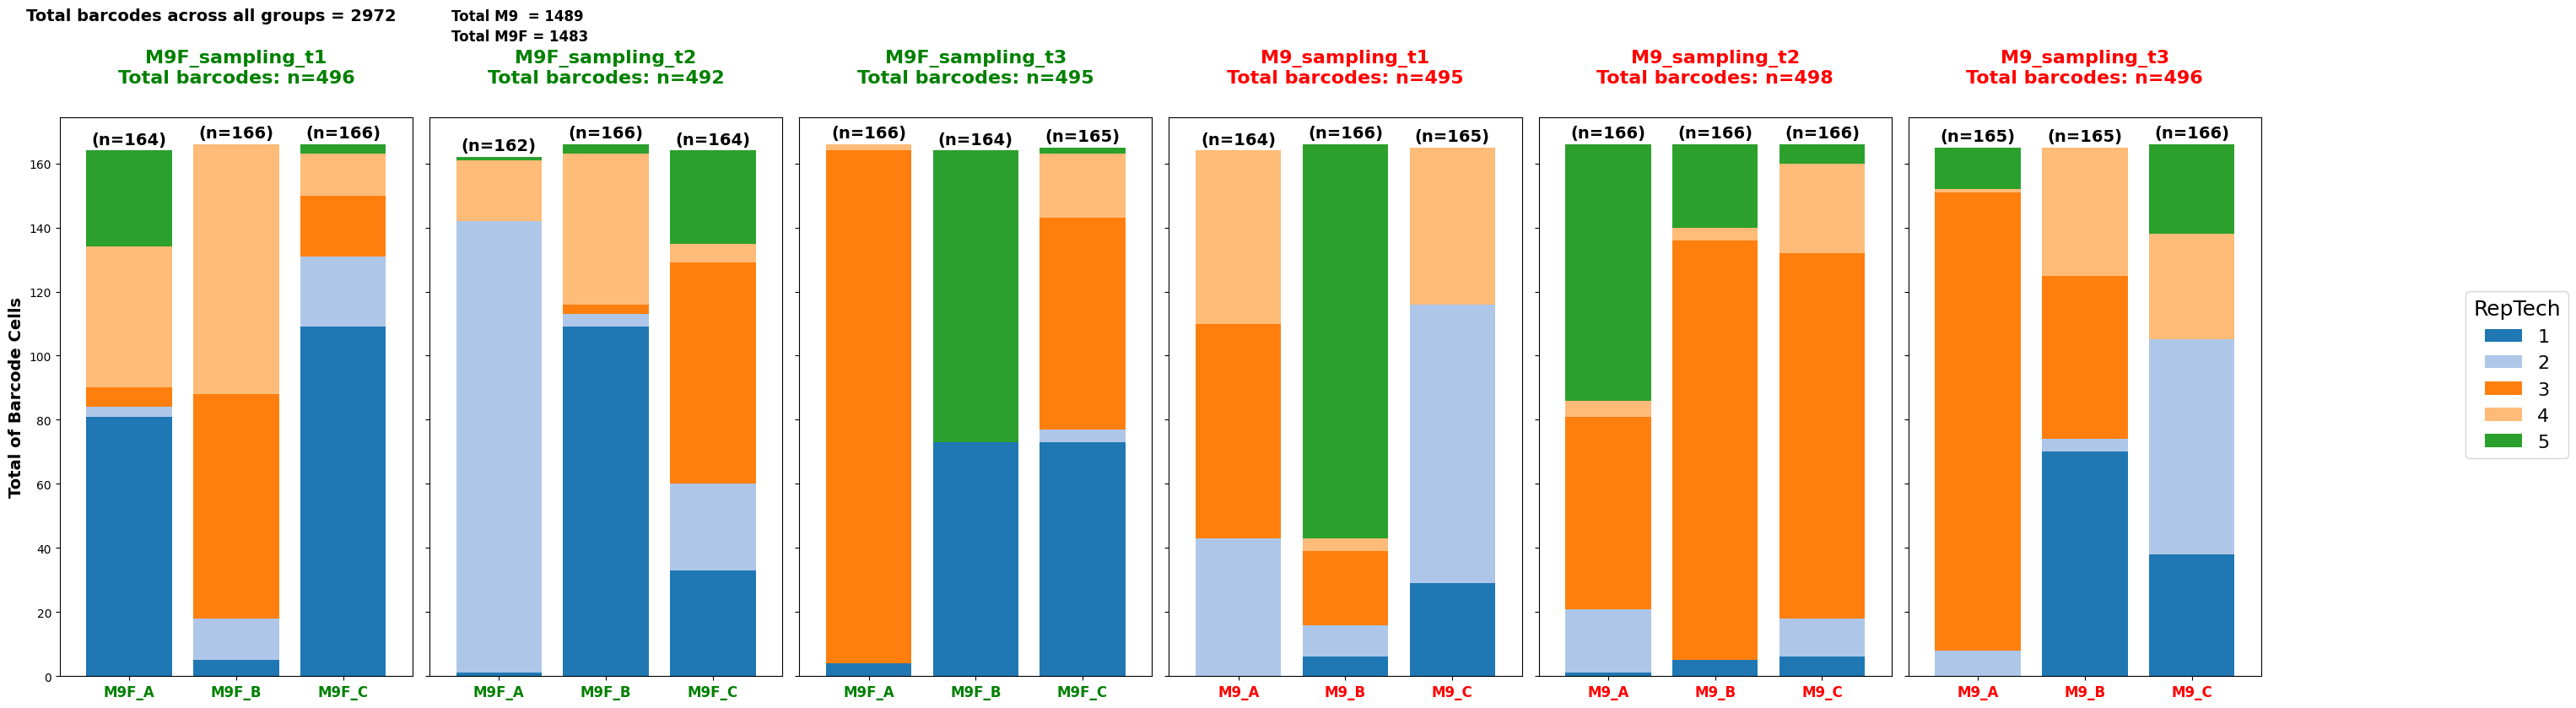

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


adata1_genes_filtered.obs["group"] = adata1_genes_filtered.obs.apply(
    assign_group, axis=1
)

# Grouper les données par la nouvelle colonne 'group', RepBio et RepTech_suffix
counts = (
    adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Obtenir la liste des groupes (panels)
group_labels = sorted(counts["group"].unique())
n = len(group_labels)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 8), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, group in zip(axes, group_labels):
    df_group = counts[counts["group"] == group]

    # Extraire culture_medium (M9 ou M9F) et temps
    culture_medium = group.split("_")[0]  # M9 ou M9F
    sampling_time = group.split("_")[1]  # sampling_t1, sampling_t2, sampling_t3

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    df_group = df_group[df_group["RepBio"].isin(expected_repbios)]

    # Pivot pour format barres empilées
    pivot_df = df_group.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)

    # Réorganiser les colonnes dans l'ordre attendu
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    # Réorganiser les lignes dans l'ordre attendu
    if culture_medium == "M9":
        pivot_df = pivot_df.reindex(index=["M9_A", "M9_B", "M9_C"], fill_value=0)
    elif culture_medium == "M9F":
        pivot_df = pivot_df.reindex(index=["M9F_A", "M9F_B", "M9F_C"], fill_value=0)

    # Plot empilé
    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
        width=0.8,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}\nTotal barcodes: n={int(total_plot)}",
        fontsize=16,
        fontweight="bold",
        color=title_color,
        pad=20,
        y=1.02,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=14, fontweight="bold")

    # Couleur des étiquettes X : vert si M9F, rouge si M9
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(
        xtick_labels, rotation=0, ha="center", fontsize=12, fontweight="bold"
    )

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # Affichage des counts (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold",
        )

# Légende globale
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    bbox_to_anchor=(0.85, 0.5),
    fontsize=16,
    title_fontsize=18,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all groups = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata1_genes_filtered.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage juste à droite du total global
fig.text(
    0.15,
    1.02,
    f"Total M9  = {total_by_medium.get('M9', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
fig.text(
    0.15,
    0.99,
    f"Total M9F = {total_by_medium.get('M9F', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

<ipython-input-205-346d2900caf2>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
<ipython-input-205-346d2900caf2>:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata1_genes_filtered.obs.groupby("CultureMedium")


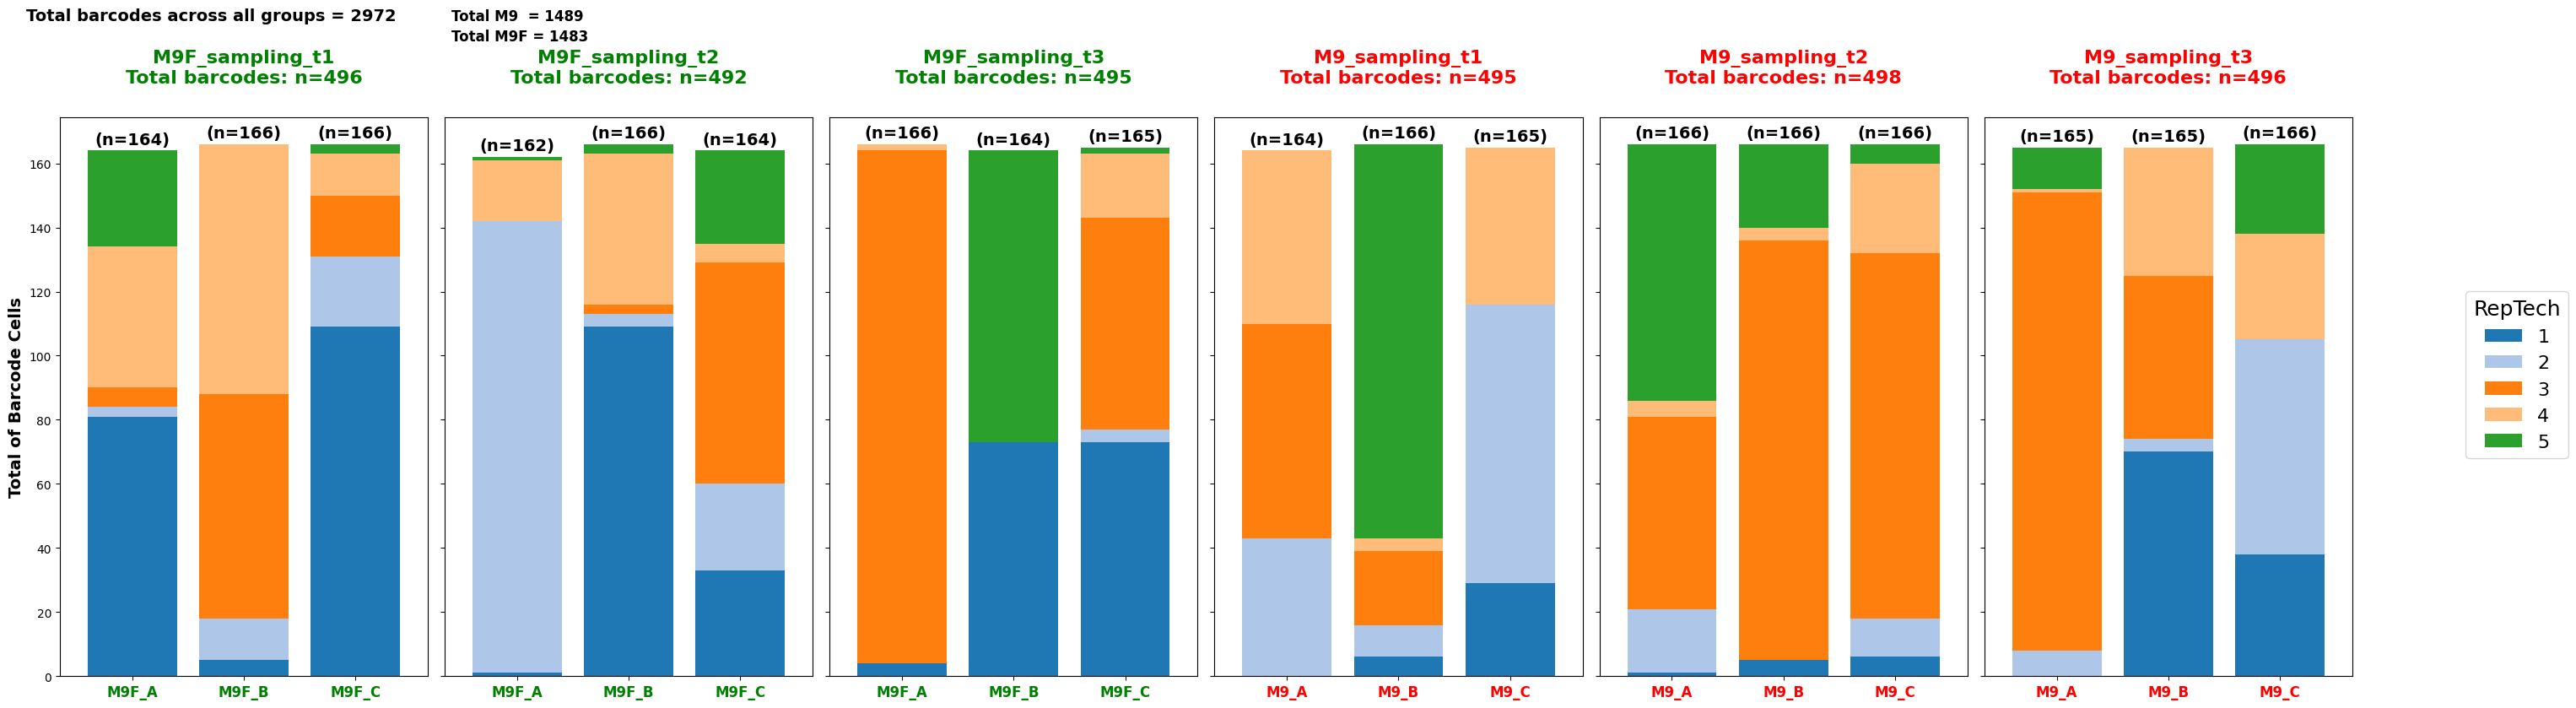

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Création de la colonne de regroupement 'group' selon la logique demandée
def assign_group(row):
    prefix = row["CultureMedium"]  # M9 ou M9F
    odt = row["ODt"]
    if odt == "OD1":
        suffix = "sampling_t1"
    elif odt == "OD2":
        suffix = "sampling_t2"
    elif odt == "OD3":
        suffix = "sampling_t3"
    else:
        suffix = "sampling_unknown"
    return f"{prefix}_{suffix}"


adata1_genes_filtered.obs["group"] = adata1_genes_filtered.obs.apply(
    assign_group, axis=1
)

# Grouper les données par la nouvelle colonne 'group', RepBio et RepTech_suffix
counts = (
    adata1_genes_filtered.obs.groupby(["group", "RepBio", "RepTech_suffix"])
    .size()
    .reset_index(name="counts")
)

# Obtenir la liste des groupes (panels)
group_labels = sorted(counts["group"].unique())
n = len(group_labels)

all_suffixes = sorted(counts["RepTech_suffix"].unique())
colors = plt.get_cmap("tab20").colors
color_map = {suffix: colors[i % len(colors)] for i, suffix in enumerate(all_suffixes)}

# Création des sous-graphes
fig, axes = plt.subplots(1, n, figsize=(6 * n, 8), sharey=True)

if n == 1:
    axes = [axes]

total_all = 0

for ax, group in zip(axes, group_labels):
    df_group = counts[counts["group"] == group]

    # Extraire culture_medium (M9 ou M9F) et temps
    culture_medium = group.split("_")[0]  # M9 ou M9F
    sampling_time = group.split("_")[1]  # sampling_t1, sampling_t2, sampling_t3

    # Définir les RepBio attendus pour ce groupe
    if culture_medium == "M9":
        expected_repbios = ["M9_A", "M9_B", "M9_C"]
    elif culture_medium == "M9F":
        expected_repbios = ["M9F_A", "M9F_B", "M9F_C"]
    else:
        expected_repbios = []

    # Filtrer pour garder seulement les RepBio attendus
    df_group = df_group[df_group["RepBio"].isin(expected_repbios)]

    # Pivot pour format barres empilées
    pivot_df = df_group.pivot(
        index="RepBio", columns="RepTech_suffix", values="counts"
    ).fillna(0)

    # Réorganiser les colonnes dans l'ordre attendu
    pivot_df = pivot_df.reindex(columns=all_suffixes, fill_value=0)

    # Réorganiser les lignes dans l'ordre attendu
    if culture_medium == "M9":
        pivot_df = pivot_df.reindex(index=["M9_A", "M9_B", "M9_C"], fill_value=0)
    elif culture_medium == "M9F":
        pivot_df = pivot_df.reindex(index=["M9F_A", "M9F_B", "M9F_C"], fill_value=0)

    # Plot empilé
    pivot_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map[col] for col in pivot_df.columns],
        legend=False,
        width=0.8,
    )

    bar_sums = pivot_df.sum(axis=1)
    total_plot = bar_sums.sum()
    total_all += total_plot

    # Couleur du titre selon le medium
    title_color = "green" if "M9F" in group else "red"
    ax.set_title(
        f"{group}\nTotal barcodes: n={int(total_plot)}",
        fontsize=16,
        fontweight="bold",
        color=title_color,
        pad=20,
        y=1.02,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Total of Barcode Cells", fontsize=14, fontweight="bold")

    # Couleur des étiquettes X : vert si M9F, rouge si M9
    xtick_labels = pivot_df.index.tolist()
    colors_xticks = ["green" if "M9F" in label else "red" for label in xtick_labels]
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(
        xtick_labels, rotation=0, ha="center", fontsize=12, fontweight="bold"
    )

    for label, color in zip(ax.get_xticklabels(), colors_xticks):
        label.set_color(color)

    # Affichage des counts (n=...) au-dessus des barres
    for i, val in enumerate(bar_sums):
        ax.text(
            i,
            val + 1,
            f"(n={int(val)})",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold",
        )

# Légende globale
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="RepTech",
    loc="center right",
    bbox_to_anchor=(0.85, 0.5),
    fontsize=16,
    title_fontsize=18,
)

# Total global en haut à gauche
fig.text(
    0.01,
    1.02,
    f"Total barcodes across all groups = {int(total_all)}",
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
)

# Total par CultureMedium
total_by_medium = (
    adata1_genes_filtered.obs.groupby("CultureMedium")
    .size()
    .reindex(["M9", "M9F"])  # pour garder l'ordre
    .fillna(0)
    .astype(int)
)

# Affichage juste à droite du total global
fig.text(
    0.15,
    1.02,
    f"Total M9  = {total_by_medium.get('M9', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
fig.text(
    0.15,
    0.99,
    f"Total M9F = {total_by_medium.get('M9F', 0)}",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

# Mise en page finale
plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.show()